## Описание задачи

На порталах с объявлениями о работе нередко встречаются вакансии без указания заработной платы. Часто хочется узнать, на какую зарплату можно претендовать по описанию вакансии. Также в описании вакансии содержатся ключевые навыки кандидата - полезно их автоматически анализировать и делать выводы.

Возможные задачи:
- Скачать объявления с сайта
- По набору ключевых навыков:
    -  вывести вакансии, содержащие эти навыки;
    -  вывести среднюю зарплату по таким вакансиям;
    -  вывести среднюю зарплату по всем вакансиям, содержащим каждый из перечисленных навыков.
- Собрать по всем вакансиям с одинаковыми названиям (например, ML engineer) список навыков и для каждого навыка вывести среднюю зп по всем вакансиям, содержащим такой навык. Упорядочить навыки по убыванию средней зп.
- Обучить модель ML, предсказывающую зп по описанию вакансии
- Обучить модель DL, предсказывающую зп по описанию вакансии
- Построить визуализацию вакансий по требуемому запросу (облако вакансий: кластеры - вакансии по разным направлениям, либо по схожим навыкам, либо по зп)
- Динамика изменения зп и изменения ключевых навыков во времени (возможно, нужно парсить не только hh).
- Обучить модель ML для кластеризации вакансий
- Обучить модель DL для определения числового вектора вакансии. Можно потом искать вакансию, наиболее похожую на заданное описание.

## Импорты, константы и функции

In [4]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
tqdm.pandas()

#from parser import Parser

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="dark")
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from scipy import stats
from scipy.stats import kstest, kruskal, ttest_ind

from phik.report import plot_correlation_matrix
from phik.binning import bin_data

from geopy.distance import distance

In [ ]:
######################################################## nan_plot ##############################################################

def nan_plot(data):

    '''Визуализация NaN значений в таблице'''
    
    nan_dict = {}
    for column in data:
        nan_dict[column] = data[column].isna().sum() / data.shape[0]

    df_nan = pd.DataFrame(data=list(nan_dict.values()),
                          index=list(nan_dict.keys()),
                          columns=['Процент пропущенных значений'])


    ### Построим barplot с NaN значениями
    plt.figure(figsize=(25,13))

    plots = sns.barplot(data=df_nan,
                        x=list(df_nan.index),
                        y = 'Процент пропущенных значений',
                        palette = 'coolwarm')
    plt.title(f'Процент и количество пропущенных значений в данных', fontsize=18)
    plt.xticks(rotation=90)
    
    ### Поставим annot
    i = 0
    for bar in plots.patches:
        plots.annotate(format(bar.get_height(), '.0%'),
                       (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                       size=5, xytext=(0, 8),
                       textcoords='offset points')
        i += 1
    
    plt.show()

    return df_nan

## Сбор данных

In [ ]:
parser = Parser()
df = parser(month_from = 9, month_to = 10,
            day_from = 1, day_to = 31)

## Знакомство с данными

In [111]:
df = pd.read_csv('../vacancies.csv')
df = df.dropna(axis=1, how='all')

print('*' * 70)
print()
print(f'Было найдено {df.shape[0]} вакансий с появлением {df.duplicated().sum()} строк-дубликатов.')
print(f'В каждой вакансии {df.shape[1]} переменных.')
print()
print('*' * 70)
print()
display(df.info(memory_usage='deep'))
print()
print('*' * 70)
print()
display(df.describe(include='all'))
print()
print('*' * 70)
print()
display(df.sample(5))

df.drop_duplicates(inplace=True)

**********************************************************************
Было найдено 709572 вакансий с появлением 4 строк-дубликатов.
В каждой вакансии 122 переменных.

**********************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709572 entries, 0 to 709571
Columns: 122 entries, id to immediate_redirect_vacancy_id
dtypes: bool(8), float64(41), int64(3), object(70)
memory usage: 3.5 GB


None


**********************************************************************


id premium                  name has_test  \
count   7.095720e+05  709572                709572   709572   
unique           NaN       2                274710        2   
top              NaN   False  Менеджер по продажам    False   
freq             NaN  707212                  7715   706128   
mean    1.067054e+08     NaN                   NaN      NaN   
std     4.170641e+06     NaN                   NaN      NaN   
min     1.144542e+07     NaN                   NaN      NaN   
25%     1.071795e+08     NaN                   NaN      NaN   
50%     1.078980e+08     NaN                   NaN      NaN   
75%     1.083951e+08     NaN                   NaN      NaN   
max     1.088986e+08     NaN                   NaN      NaN   

       response_letter_required        area_id area_name  \
count                    709572  709572.000000    709572   
unique                        2            NaN      6218   
top                       False            NaN    Москва   
freq                     703630            NaN    115708   
mean                        NaN     674.079125       NaN   
std                         NaN    1325.039359       NaN   
min                         NaN       1.000000       NaN   
25%                         NaN       3.000000       NaN   
50%                         NaN      76.000000       NaN   
75%                         NaN    1201.000000       NaN   
max                         NaN   11520.000000       NaN   

                         area_url   salary_from     salary_to salary_currency  \
count                      709572  6.682740e+05  3.967090e+05          709572   
unique                       6218           NaN           NaN               9   
top     https://api.hh.ru/areas/1           NaN           NaN             RUR   
freq                       115708           NaN           NaN          662513   
mean                          NaN  1.116740e+05  1.936850e+05             NaN   
std                           NaN  4.523422e+05  1.107720e+06             NaN   
min                           NaN  1.000000e+00  1.000000e+00             NaN   
25%                           NaN  4.500000e+04  5.800000e+04             NaN   
50%                           NaN  7.000000e+04  9.000000e+04             NaN   
75%                           NaN  1.000000e+05  1.500000e+05             NaN   
max                           NaN  6.000000e+07  1.700000e+08             NaN   

       salary_gross type_id type_name address_city address_street  \
count        709236  709572    709572       466977         432674   
unique            2       4         4        11348          31342   
top           False    open  Открытая       Москва   улица Ленина   
freq         470027  708334    708334        79112           3925   
mean            NaN     NaN       NaN          NaN            NaN   
std             NaN     NaN       NaN          NaN            NaN   
min             NaN     NaN       NaN          NaN            NaN   
25%             NaN     NaN       NaN          NaN            NaN   
50%             NaN     NaN       NaN          NaN            NaN   
75%             NaN     NaN       NaN          NaN            NaN   
max             NaN     NaN       NaN          NaN            NaN   

       address_building    address_lat    address_lng address_raw  \
count            414765  471455.000000  471455.000000      471503   
unique            16513            NaN            NaN      172128   
top                   1            NaN            NaN      Москва   
freq              13942            NaN            NaN        1918   
mean                NaN      54.326423      52.598646         NaN   
std                 NaN       4.567003      25.109862         NaN   
min                 NaN     -34.608470    -173.218920         NaN   
25%                 NaN      53.197950      37.555885         NaN   
50%                 NaN      55.673027      39.870188         NaN   
75%                 NaN      56.253477      60.7


**********************************************************************


id  premium                                               name  \
170610  107712827    False  Менеджер по организации международных перевозо...   
400459  108290840    False            Экспедитор на доставку пивной продукции   
491819  103937878    False                                Помощник бухгалтера   
350808   96371287    False  Менеджер-консультант в салон сотовой связи Т2 ...   
374676  108213507    False            Пекарь (Рязань, Интернациональная, 11А)   

        has_test  response_letter_required  area_id        area_name  \
170610     False                     False     1002            Минск   
400459     False                     False     1753        Череповец   
491819     False                     False        2  Санкт-Петербург   
350808     False                     False       54       Красноярск   
374676     False                     False       77           Рязань   

                            area_url  salary_from  salary_to salary_currency  \
170610  https://api.hh.ru/areas/1002        500.0     2000.0             EUR   
400459  https://api.hh.ru/areas/1753          NaN    60000.0             RUR   
491819     https://api.hh.ru/areas/2      50000.0    50000.0             RUR   
350808    https://api.hh.ru/areas/54      50000.0        NaN             RUR   
374676    https://api.hh.ru/areas/77      40000.0    47000.0             RUR   

       salary_gross type_id type_name     address_city  \
170610        False    open  Открытая            Минск   
400459        False    open  Открытая        Череповец   
491819        False    open  Открытая  Санкт-Петербург   
350808        False    open  Открытая       Красноярск   
374676         True    open  Открытая           Рязань   

                                           address_street address_building  \
170610                               проспект Победителей              129   
400459         Индустриальный район, улица Стройиндустрии               15   
491819                                  улица Решетникова               15   
350808  Ленинский район, микрорайон Черёмушки, Амурска...            30А/2   
374676                                  Интернациональная              11А   

        address_lat  address_lng  \
170610    53.941018    27.466071   
400459    59.118904    37.865876   
491819    59.878798    30.329963   
350808    55.988746    93.014825   
374676    54.671609    39.658893   

                                              address_raw  \
170610                   Минск, проспект Победителей, 129   
400459  Череповец, Индустриальный район, улица Стройин...   
491819             Санкт-Петербург, улица Решетникова, 15   
350808  Красноярск, Ленинский район, микрорайон Черёму...   
374676                     Рязань, Интернациональная, 11А   

       address_metro_station_name  address_metro_line_name  \
170610                     Немига            Автозаводская   
400459                        NaN                      NaN   
491819                Электросила  Московско-Петроградская   
350808                        NaN                      NaN   
374676                        NaN                      NaN   

        address_metro_station_id  address_metro_line_id  address_metro_lat  \
170610                    63.422                   63.0          53.905615   
400459                       NaN                    NaN                NaN   
491819                    15.222                   15.0          59.879189   
350808                       NaN                    NaN                NaN   
374676                       NaN                    NaN                NaN   

        address_metro_lng address_metro_stations_0_station_name  \
170610          27.554150                                Немига   
400459                NaN                                   NaN   
491819          30.318659                           Электросила   
350808                NaN                                   NaN   
374676                NaN          

После парсинга мы получили DF с 709.572 наблюдениями и 122 фичами, этого будет более, чем достаточно. В дальнейшем, возможно, понадобиться масшабирование, чтобы снизить вес данных, нынешний вес составляет 3.5 ГБ. В таблице есть категориальные, непрерывные и дискретные переменные, будем рассматривать каждый признак по отдельности. Также наш датасет имеет уйму пропусков, которые необходимо будет предобработать для некоторых моделей ML.

Стоит посмотреть на столбцы salary_from	и salary_to, которые являются нашим таргетом. В дальнейшем необходимо агрегировать два столбца, чтобы не угадывать вилку, а конкретную цифру.

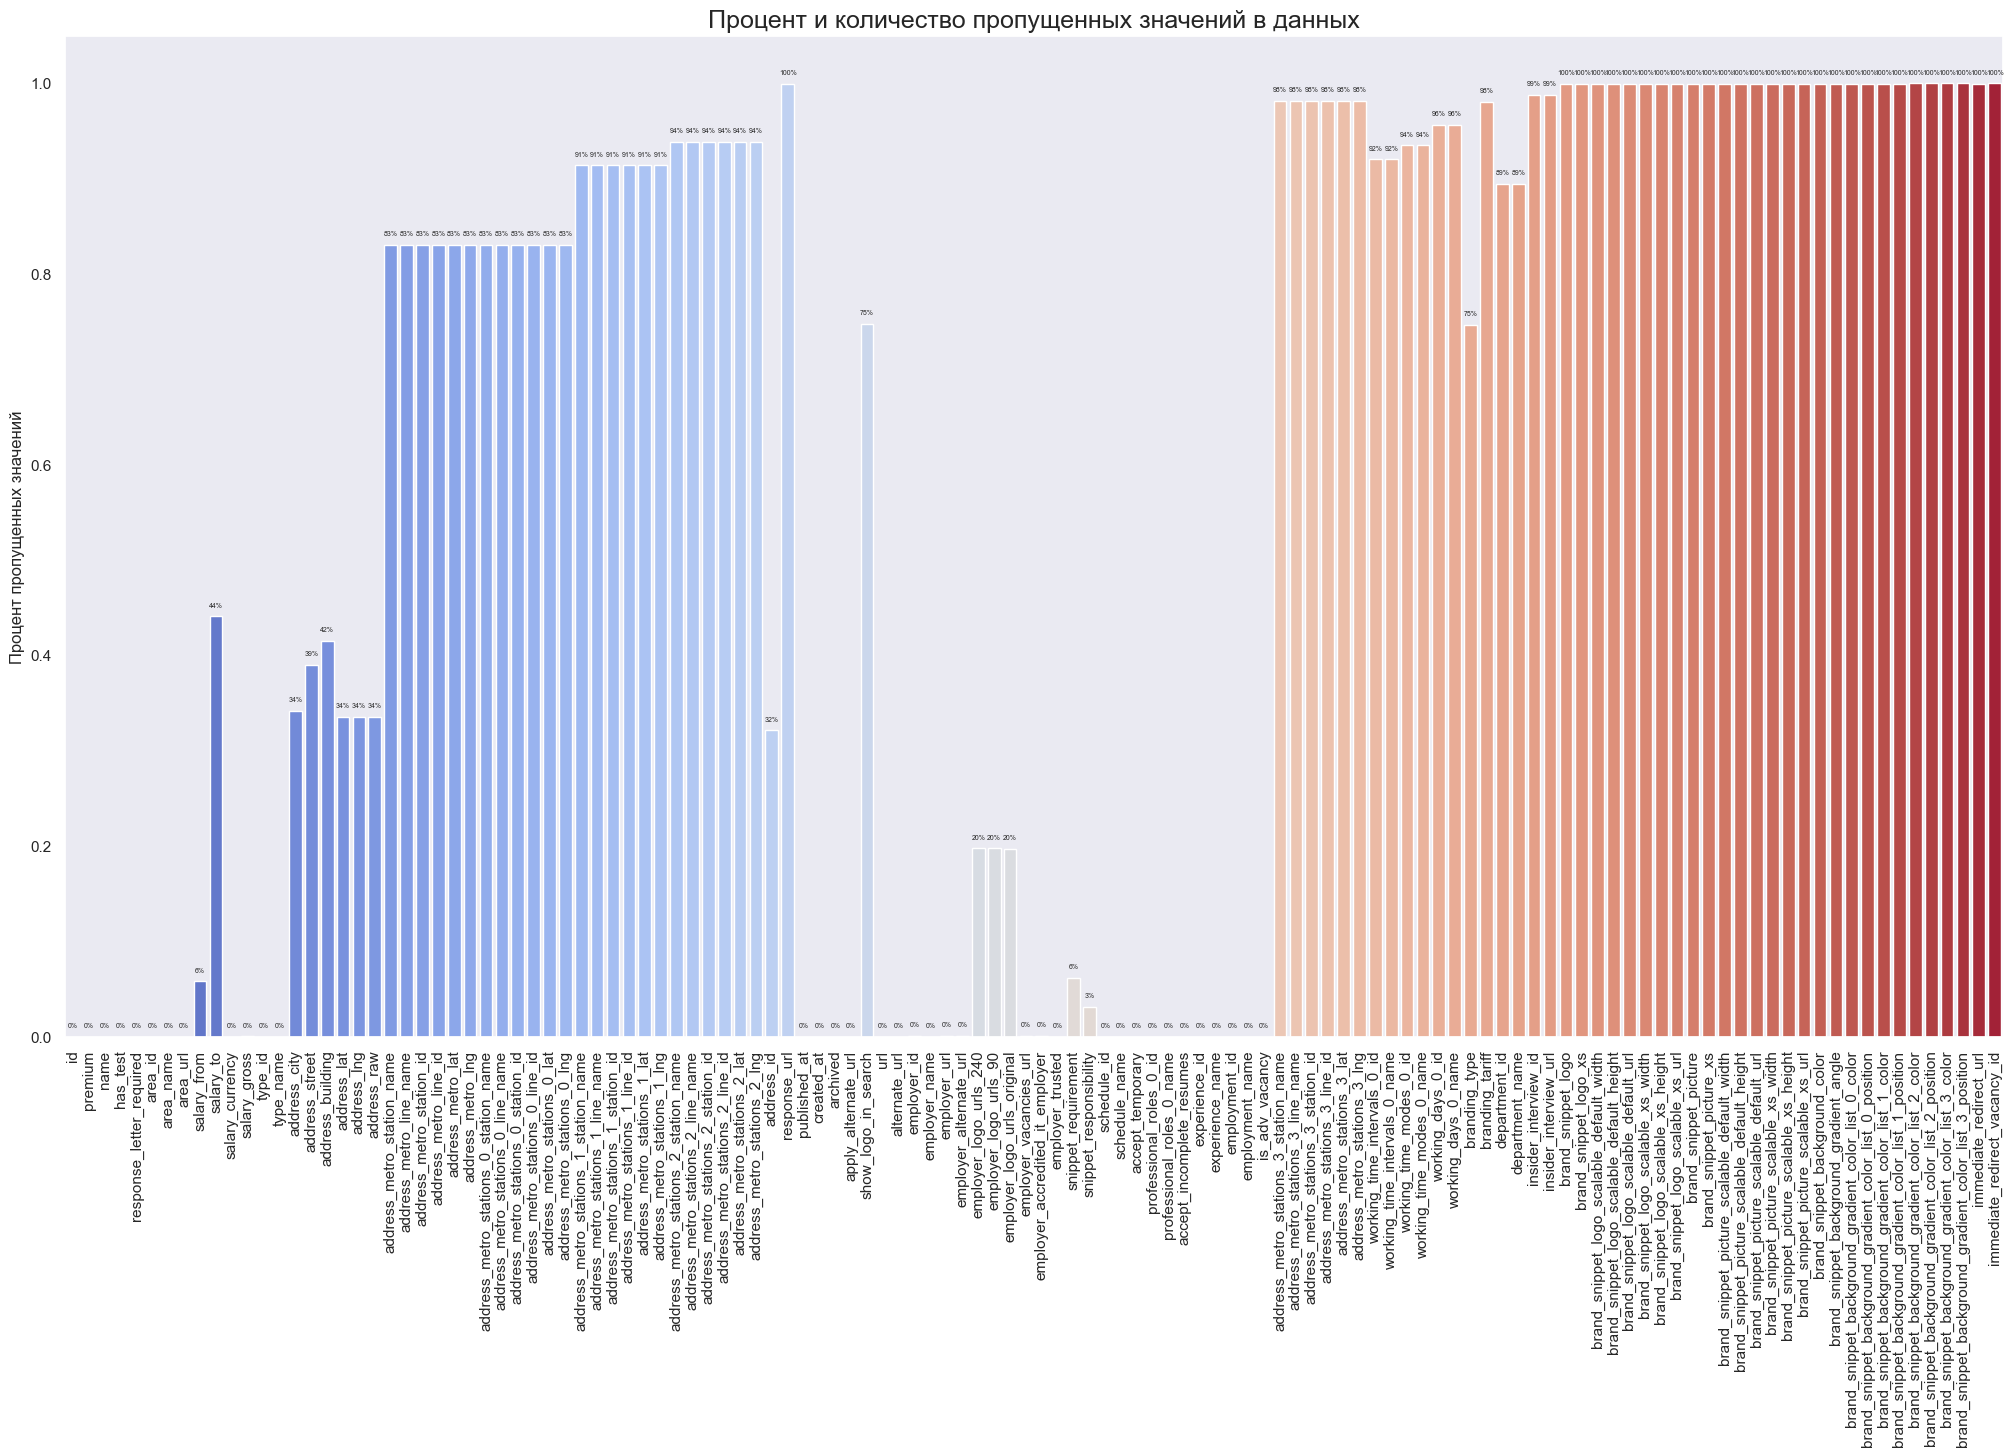

In [4]:
### Просмотр количества NaN значений по всему DF
df_nan = nan_plot(df)

Как уже говорилось, наш DF имеет достаточно много NaN значений, в некоторых столбцах доходит до 99%. Однако, что самое важное: мы имеем пропуски в заработной плате. В дальнейшем необходимо исправить пропуски в каждом столбце.

In [5]:
df

id  premium                                               name  \
0       107085827    False  Менеджер по работе с клиентами / менеджер по п...   
1       107411111    False                           Ночной сборщик-упаковщик   
2       107411126    False        Специалист по уходу за животными (котоняня)   
3       107506759    False  Менеджер маркетплейсов Ozon ( Менеджер Озон / ...   
4       107513688    False  Инженер-конструктор химико-технологического об...   
...           ...      ...                                                ...   
709567   93496776    False  Сборщик интернет-заказов/Продавец (ТЦ Балканский)   
709568   94512841    False             Врач-косметолог (м.Ленинский проспект)   
709569  108563565    False                       Продавец-консультант SOKOLOV   
709570   96265952    False  Менеджер по продажам недвижимости (поток клиен...   
709571  107276604    False                  Преподаватель Construct для детей   

        has_test  response_letter_required  area_id        area_name  \
0          False                     False        1           Москва   
1          False                     False        1           Москва   
2          False                      True        1           Москва   
3          False                     False       88           Казань   
4          False                     False       66  Нижний Новгород   
...          ...                       ...      ...              ...   
709567     False                     False        2  Санкт-Петербург   
709568     False                     False        2  Санкт-Петербург   
709569     False                     False        1           Москва   
709570     False                     False       53        Краснодар   
709571     False                     False        1           Москва   

                          area_url  salary_from  salary_to salary_currency  \
0        https://api.hh.ru/areas/1     100000.0   150000.0             RUR   
1        https://api.hh.ru/areas/1      45000.0    60000.0             RUR   
2        https://api.hh.ru/areas/1      51000.0    66000.0             RUR   
3       https://api.hh.ru/areas/88      60000.0    90000.0             RUR   
4       https://api.hh.ru/areas/66     110000.0        NaN             RUR   
...                            ...          ...        ...             ...   
709567   https://api.hh.ru/areas/2      58500.0        NaN             RUR   
709568   https://api.hh.ru/areas/2     150000.0        NaN             RUR   
709569   https://api.hh.ru/areas/1      90000.0        NaN             RUR   
709570  https://api.hh.ru/areas/53      90000.0   399990.0             RUR   
709571   https://api.hh.ru/areas/1      65000.0   120000.0             RUR   

       salary_gross type_id type_name     address_city  \
0              True    open  Открытая           Москва   
1             False    open  Открытая           Москва   
2             False    open  Открытая           Москва   
3             False    open  Открытая           Москва   
4              True    open  Открытая           Москва   
...             ...     ...       ...              ...   
709567         True    open  Открытая  Санкт-Петербург   
709568         True    open  Открытая  Санкт-Петербург   
709569        False    open  Открытая              NaN   
709570        False    open  Открытая        Краснодар   
709571        False    open  Открытая              NaN   

                      address_street address_building  address_lat  \
0            Дербеневская набережная              7с2    55.723328   
1            Краснобогатырская улица              2с2    55.814983   
2                  Дубининская улица             55к1    55.721275   
3             Пресненская набережная               12    55.749633   
4                  шоссе Энтузиастов               23    55.754411   
...                              ...              ...          ...   
709567            Балканская площадь              5АД

##### Столбец salary (target)

In [113]:
### У нас есть два толбца: salary_from и salary_to - вилка ЗП. Нам необходимо преобразовать их в один общий столбец с нашей целевой переменной

def calculate_salary(row):
    if pd.isna(row['salary_from']):
        return row['salary_to']
    if pd.isna(row['salary_to']):
        return row['salary_from']
    return (row['salary_from'] + row['salary_to']) // 2

df['salary'] = df.progress_apply(calculate_salary, axis=1)
df['salary'][:5]

100%|██████████| 709568/709568 [00:09<00:00, 72062.24it/s] 


0    125000.0
1     52500.0
2     58500.0
3     75000.0
4    110000.0
Name: salary, dtype: float64

In [114]:
# Удалим "вилочные" столбцы
for column in ['salary_from', 'salary_to']:
    del df[column]

In [115]:
# Посмотрим на топ ЗП
df['salary'].sort_values(ascending=False).head(15)

159831    115000000.0
51020      76000000.0
263494     60000000.0
156332     60000000.0
527748     57500000.0
191078     52500000.0
233576     52500000.0
317316     50500000.0
96096      50000000.0
418073     50000000.0
53644      40000000.0
614959     40000000.0
86906      40000000.0
294222     38000000.0
249473     35000000.0
Name: salary, dtype: float64

In [116]:
# Посмотрим на валюты топа ЗП
df.loc[df['salary'] > 35000000, ['salary', 'salary_currency']]

salary salary_currency
51020    76000000.0             UZS
53644    40000000.0             UZS
86906    40000000.0             UZS
96096    50000000.0             RUR
156332   60000000.0             UZS
159831  115000000.0             UZS
191078   52500000.0             UZS
233576   52500000.0             UZS
263494   60000000.0             UZS
294222   38000000.0             UZS
317316   50500000.0             UZS
418073   50000000.0             UZS
527748   57500000.0             UZS
614959   40000000.0             UZS

Как мы можем видеть, на некоторых вакансиях ЗП указана в других валютах. Нам необходимо нормализировать зарабаток в рубли.

In [117]:
df['salary_currency'].unique()

array(['RUR', 'USD', 'EUR', 'KZT', 'BYR', 'UZS', 'AZN', 'GEL', 'KGS'],
      dtype=object)

In [118]:
# Выставляем курс на момент 22.10.24

salary_currency_dict_to_RUR = {
    'RUR': 1,
    'USD': 96.09,
    'EUR': 104.4,
    'KZT': 0.198112,
    'BYR': 29.2,
    'UZS': 0.007498,
    'AZN': 56.52,
    'GEL': 35.38,
    'KGS': 1.12
}

df['salary'] = df['salary'] * df['salary_currency'].map(salary_currency_dict_to_RUR)

In [119]:
df.loc[df['salary'] > 4600000]

premium                                               name  has_test  \
11439     False  Менеджер в департамент продаж международной не...     False   
11823     False  Ведущий менеджер по продажам международной эли...     False   
45872     False                   Агент по загородной недвижимости     False   
69710     False                                     Bookkeeper NYC     False   
96096     False                            Диспетчер по транспорту     False   
138651    False                     Менеджер по работе с клиентами     False   
174162    False  Брокер по продажам премиальной недвижимости (в...     False   
271875    False                               Бригада Монолитчиков     False   
542254    False          Менеджер по продаже и аренде недвижимости     False   
652609    False                           Инженер ПТО (г.Курчатов)     False   
666077    False                            Системный администратор     False   

        response_letter_required  area_id     area_name  \
11439                      False        1        Москва   
11823                      False        1        Москва   
45872                      False       53     Краснодар   
69710                      False       85           США   
96096                      False       53     Краснодар   
138651                     False     1162     Минусинск   
174162                     False        1        Москва   
271875                     False        3  Екатеринбург   
542254                      True      236          Кипр   
652609                     False      132          Сумы   
666077                     False        1        Москва   

                            area_url salary_currency salary_gross type_id  \
11439      https://api.hh.ru/areas/1             RUR        False    open   
11823      https://api.hh.ru/areas/1             RUR        False    open   
45872     https://api.hh.ru/areas/53             RUR        False    open   
69710     https://api.hh.ru/areas/85             USD         True    open   
96096     https://api.hh.ru/areas/53             RUR        False    open   
138651  https://api.hh.ru/areas/1162             RUR        False    open   
174162     https://api.hh.ru/areas/1             RUR        False    open   
271875     https://api.hh.ru/areas/3             RUR        False    open   
542254   https://api.hh.ru/areas/236             EUR        False    open   
652609   https://api.hh.ru/areas/132             EUR         True    open   
666077     https://api.hh.ru/areas/1             EUR        False    open   

       type_name            address_city  \
11439   Открытая                  Москва   
11823   Открытая                  Москва   
45872   Открытая                    Сочи   
69710   Открытая                     NaN   
96096   Открытая  посёлок Индустриальный   
138651  Открытая               Минусинск   
174162  Открытая                  Москва   
271875  Открытая            Екатеринбург   
542254  Открытая                   Пафос   
652609  Открытая                     NaN   
666077  Открытая                  Москва   

                                    address_street address_building  \
11439                      улица Ленинская Слобода             26с5   
11823                      улица Ленинская Слобода             26с5   
45872   микрорайон Центральный, улица Орджоникидзе               4Б   
69710                                          NaN              NaN   
96096                          Евдокимовская улица              125   
138651                                         NaN              NaN   
174162                        Чистопрудный бульвар               21   
271875                                         NaN              NaN   
542254                                         NaN              NaN   
652609                                         NaN              NaN   
666077                             Верейская улица            29с33   

        address_lat  address_ln

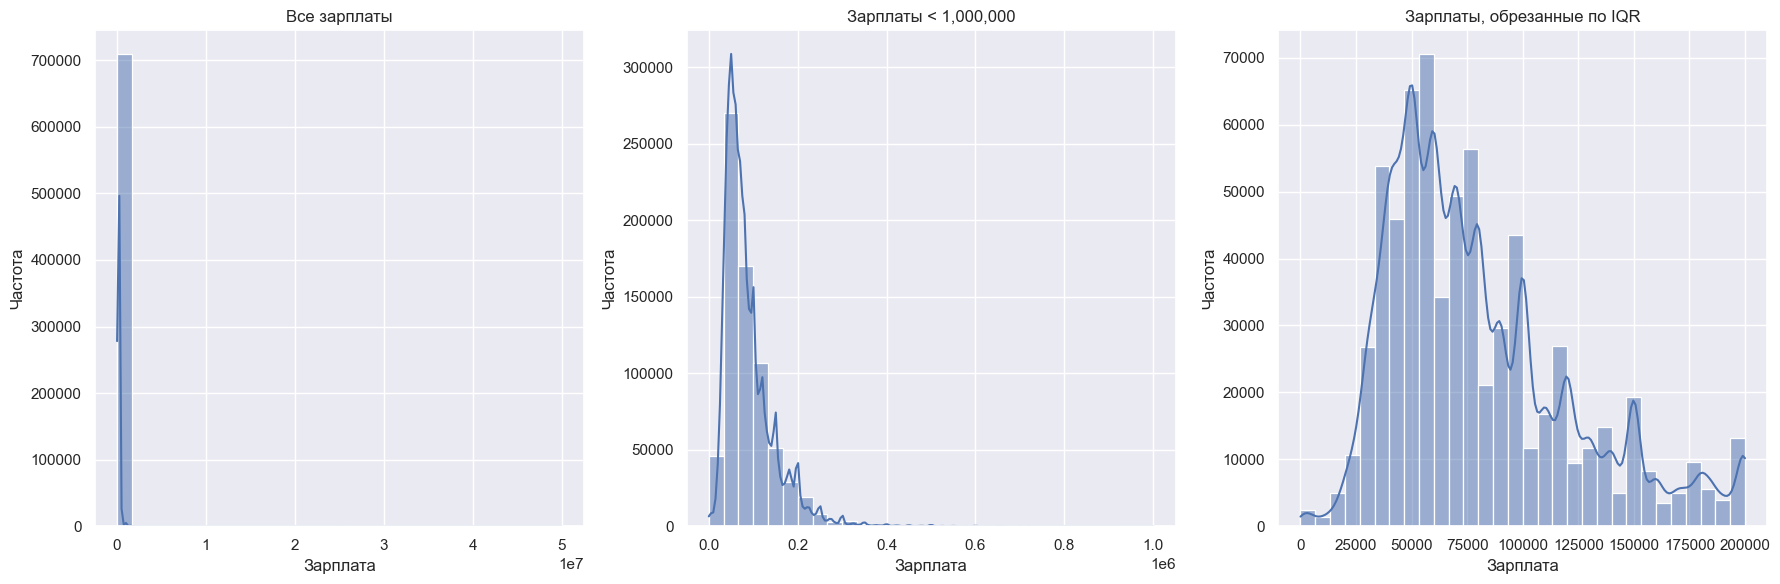

In [120]:
Q1 = df['salary'].quantile(0.25)
Q3 = df['salary'].quantile(0.75)
IQR = Q3 - Q1

df_iqr = df[(df['salary'] >= Q1 - 1.5 * IQR) & (df['salary'] <= Q3 + 1.5 * IQR)]

plt.figure(figsize=(18, 6))

#Все зарплаты
plt.subplot(1, 3, 1)
sns.histplot(df['salary'], bins=30, kde=True)
plt.grid(True)
plt.title('Все зарплаты')
plt.xlabel('Зарплата')
plt.ylabel('Частота')

#Зарплаты < 1 000 000
plt.subplot(1, 3, 2)
sns.histplot(df.loc[df['salary'] < 1000000, 'salary'], bins=30, kde=True)
plt.grid(True)
plt.title('Зарплаты < 1,000,000')
plt.xlabel('Зарплата')
plt.ylabel('Частота')

#Зарплаты, обрезанные по IQR
plt.subplot(1, 3, 3)
sns.histplot(df_iqr['salary'], bins=30, kde=True)
plt.grid(True)
plt.title('Зарплаты, обрезанные по IQR')
plt.xlabel('Зарплата')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

In [121]:
# Посмотрим нормальность распределение без ассиметрии 

salary = df['salary']
mean = np.mean(salary)
std = np.std(salary)
stat, p_value = kstest(salary, 'norm', args=(mean, std))
print(f'K-S Test Статистика: {stat}, p-value: {p_value}')

# Интерпретация результата
alpha = 0.05
if p_value > alpha:
    print('Убедительных доказательств против гипотезы о нормальности нет (не отвергаем H0)')
else:
    print('Гипотеза о нормальности отвергается (отвергаем H0)')

K-S Test Статистика: 0.23989213789786568, p-value: 0.0
Гипотеза о нормальности отвергается (отвергаем H0)


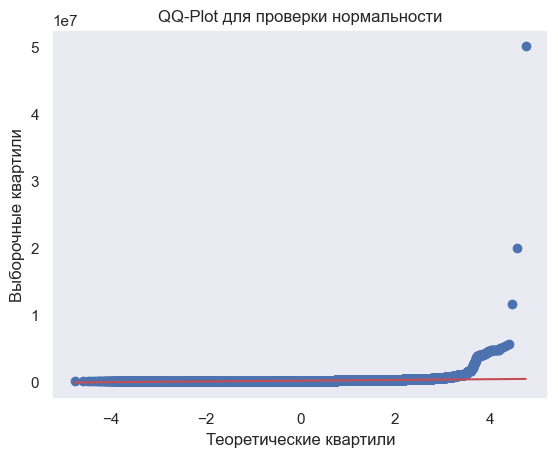

In [122]:
# Докажем ещё одним способом
fig = plt.figure()
ax = fig.add_subplot(111)
stats.probplot(salary, dist="norm", plot=ax)
ax.get_lines()[1].set_color('r')
ax.set_title('QQ-Plot для проверки нормальности')
ax.set_xlabel('Теоретические квартили')
ax.set_ylabel('Выборочные квартили')
plt.show()

Был добавлен новый столбец - salary, целевая переменная путём усреднения данных столбцов salary_from и salary_to (0% NaN). Также некоторые ЗП были указаны в других валютах, необходимо было перевести на RUR.

В данных есть выбросы: ЗП по 3-9 млн. рублей, в дальнейшем никак не будем их удалять - информация является достоверной, указанной на сайте HH. Большинство вакансий с такой вилкой - агенты по недвижимости.

Целевая переменная имеет вид нормального распределения с правосторонней ассиметрией. В дальнейшем можно попробовать прогогорифмировать данные, это позволить снизить выбросы и добавить линейности данным.

##### Столбец id

##### Столбец premium

0
[False  True]
premium
False    707208
True       2360
Name: count, dtype: int64
            count           mean            std          min      25%  \
premium                                                                 
False    707208.0   88972.640104   98162.878434     0.007498  50000.0   
True       2360.0  124888.856774  306310.950805  1700.000000  50000.0   

             50%       75%         max  
premium                                 
False    70000.0  110000.0  50000000.0  
True     80000.0  125000.0   4545000.0  
premium
False     88972.640104
True     124888.856774
Name: salary, dtype: float64
   premium         salary  difference_from_overall
0    False   88972.640104              -119.456164
1     True  124888.856774             35796.760506


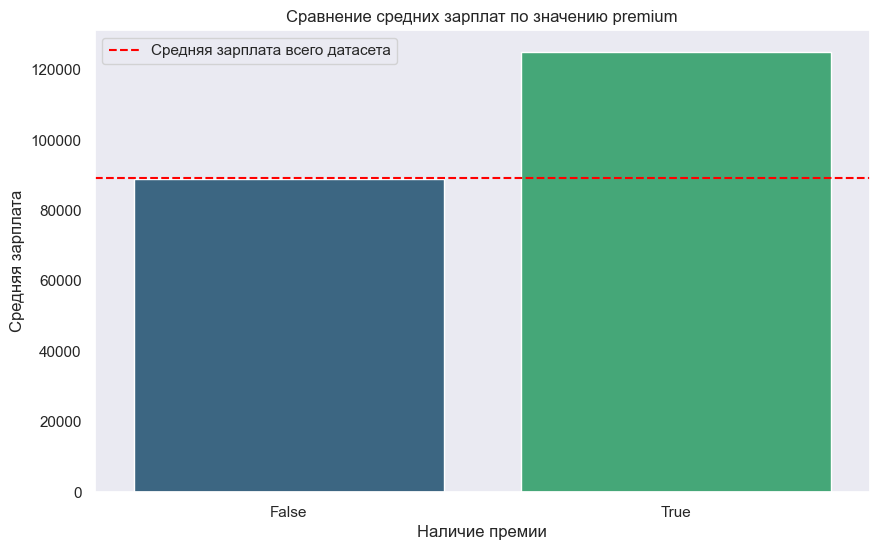

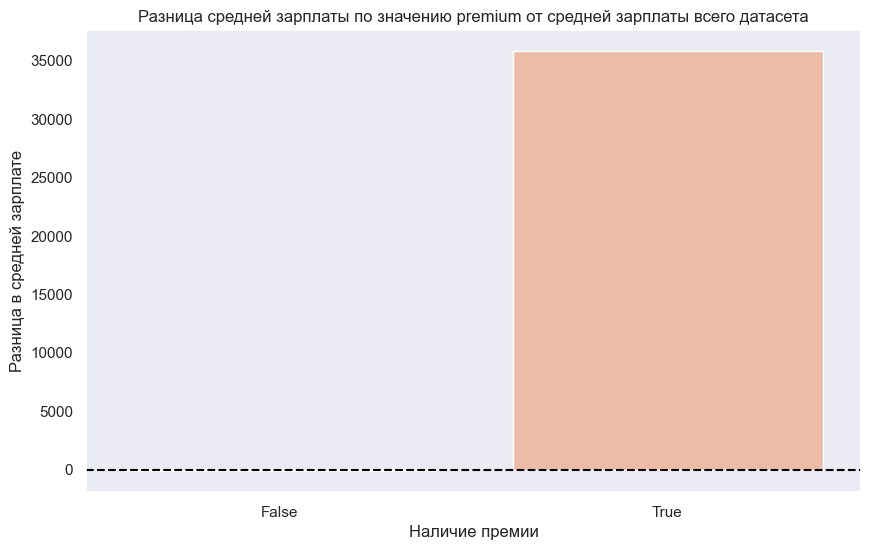

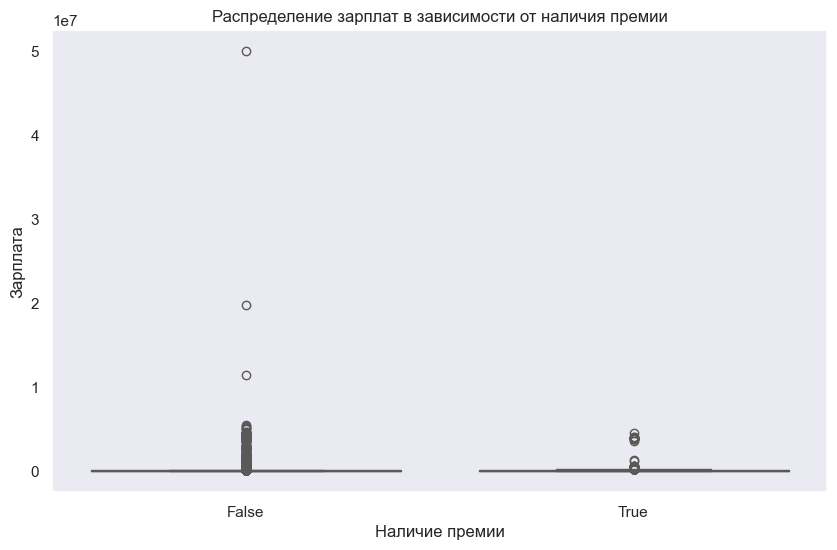

In [187]:
import matplotlib.ticker as ticker
# Проверка пропусков и уникальных значений
print(df['premium'].isnull().sum())  # Количество пропусков
print(df['premium'].unique())          # Уникальные значения
premium_counts = df['premium'].value_counts()
print(premium_counts)

premium_salary_stats = df.groupby('premium')['salary'].describe()
print(premium_salary_stats)

average_salary_premium = df.groupby('premium')['salary'].mean()
print(average_salary_premium)

# Расчет средней зарплаты для каждого значения переменной premium
mean_salary_by_premium = df.groupby('premium')['salary'].mean().reset_index()

# Расчет общей средней зарплаты
overall_mean_salary = df['salary'].mean()

# Расчет разницы средней зарплаты для каждой группы
mean_salary_by_premium['difference_from_overall'] = mean_salary_by_premium['salary'] - overall_mean_salary

print(mean_salary_by_premium)

plt.figure(figsize=(10, 6))

# Создание столбчатой диаграммы для сравнения средних зарплат
sns.barplot(x='premium', y='salary', data=mean_salary_by_premium, palette='viridis')

plt.title('Сравнение средних зарплат по значению premium')
plt.xlabel('Наличие премии')
plt.ylabel('Средняя зарплата')
plt.axhline(y=overall_mean_salary, color='red', linestyle='--', label='Средняя зарплата всего датасета')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))

# Создание столбчатой диаграммы для разницы средней зарплаты
sns.barplot(x='premium', y='difference_from_overall', data=mean_salary_by_premium, palette='coolwarm')

plt.title('Разница средней зарплаты по значению premium от средней зарплаты всего датасета')
plt.xlabel('Наличие премии')
plt.ylabel('Разница в средней зарплате')
plt.axhline(0, color='black', linestyle='--')  # Линия нуля
plt.show()

plt.figure(figsize=(10, 6))



###### Из выше привденного анализа можно сделать следующие выводы:
###### Вакансий с премиумом гараздо меньше чем без него
###### Вакансии с премиумом несут в себе большие зарплаты чем без него примерно на 35.000 рублей, что довольно таки весомо

##### Столбец name

##### Столбец department

###### Данный стобец полностью отсутствует и все его данные NAN, поэтому его можно удалить

##### Столбец has_test

False
[False  True]
Средняя зарплата (has_test=True): 114700.20, Количество строк: 3444
Средняя зарплата (has_test=False): 88967.20, Количество строк: 706124


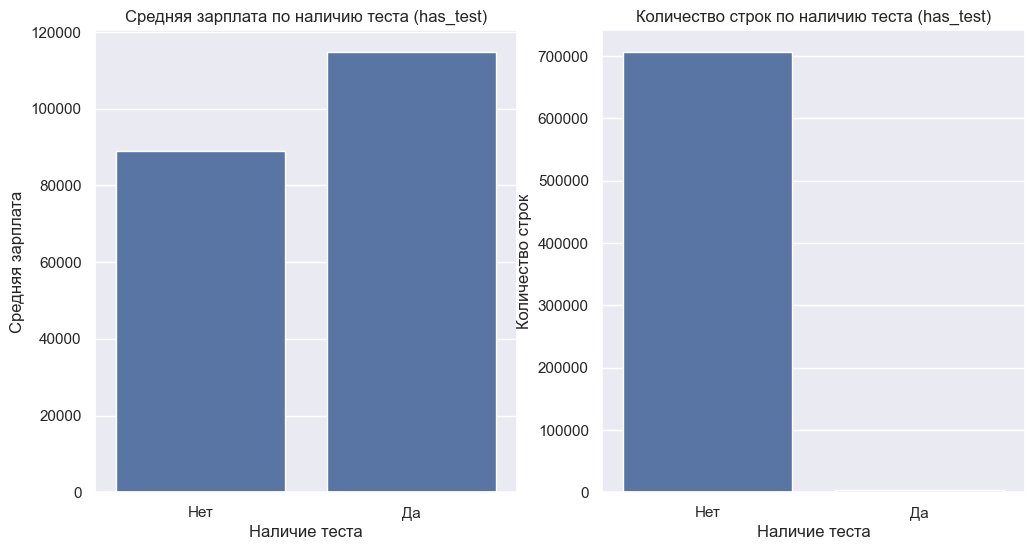

In [123]:
# Проверка на то что все значения в столбце заданы
print(df['has_test'].isna().any())
print(df['has_test'].unique())

# Фильтрация строк с has_test == True и подсчет средней зарплаты
average_salary_true = df[df['has_test'] == True]['salary'].mean()
count_true = df[df['has_test'] == True].shape[0]

# Фильтрация строк с has_test == False и подсчет средней зарплаты
average_salary_false = df[df['has_test'] == False]['salary'].mean()
count_false = df[df['has_test'] == False].shape[0]

# Вывод результатов
print(f"Средняя зарплата (has_test=True): {average_salary_true:.2f}, Количество строк: {count_true}")
print(f"Средняя зарплата (has_test=False): {average_salary_false:.2f}, Количество строк: {count_false}")

# 1. График средней зарплаты по значениям has_test
plt.figure(figsize=(12, 6))

# Средняя зарплата по значениям столбца has_test
plt.subplot(1, 2, 1)
sns.barplot(x='has_test', y='salary', data=df, ci=None)
plt.title('Средняя зарплата по наличию теста (has_test)')
plt.xlabel('Наличие теста')
plt.ylabel('Средняя зарплата')
plt.xticks([0, 1], ['Нет', 'Да'])  # Обозначаем True/False
plt.grid(axis='y')

# 2. График количества строк по значениям has_test
plt.subplot(1, 2, 2)
sns.countplot(x='has_test', data=df)
plt.title('Количество строк по наличию теста (has_test)')
plt.xlabel('Наличие теста')
plt.ylabel('Количество строк')
plt.xticks([0, 1], ['Нет', 'Да'])  # Обозначаем True/False
plt.grid(axis='y')

###### Можно сделать следующие выводы:
###### Кол-во вакансий с тестм очень мало
###### Для вакансий с наличием теста зарплата больше, что говорит а более требовательным но при этом более оплачиваемой должности

##### Столбец response_letter_required

False
[False  True]
Средняя зарплата (response_letter_required=True): 102976.94, Количество строк: 5942
Средняя зарплата (response_letter_required=False): 88974.84, Количество строк: 703626


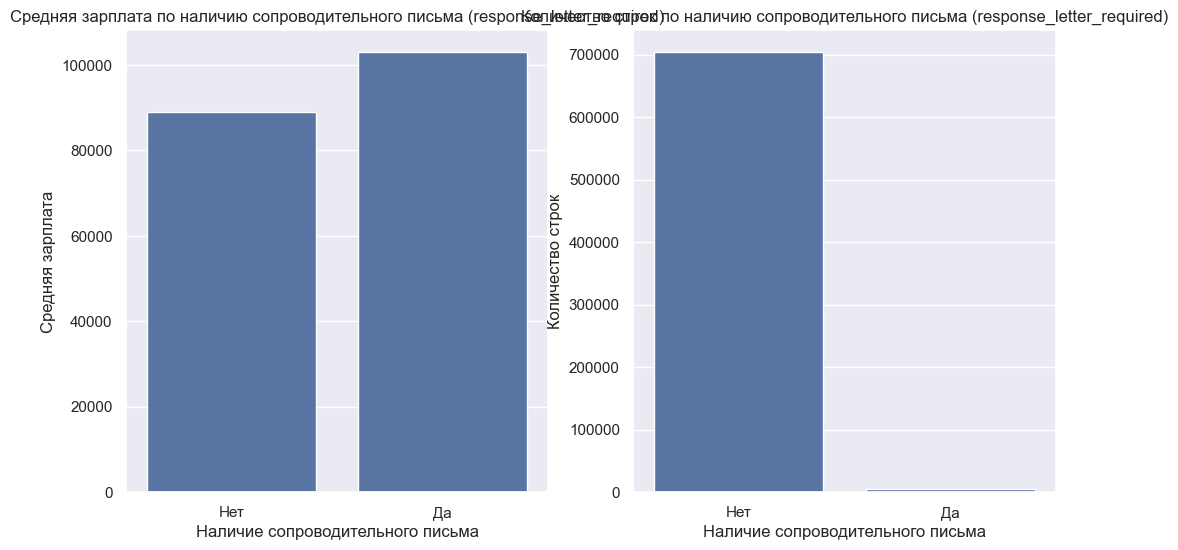

In [188]:
# Проверка на то что все значения в столбце заданы
print(df['response_letter_required'].isna().any())
print(df['response_letter_required'].unique())

# Фильтрация строк с has_test == True и подсчет средней зарплаты
average_salary_true = df[df['response_letter_required'] == True]['salary'].mean()
count_true = df[df['response_letter_required'] == True].shape[0]

# Фильтрация строк с has_test == False и подсчет средней зарплаты
average_salary_false = df[df['response_letter_required'] == False]['salary'].mean()
count_false = df[df['response_letter_required'] == False].shape[0]

# Вывод результатов
print(f"Средняя зарплата (response_letter_required=True): {average_salary_true:.2f}, Количество строк: {count_true}")
print(f"Средняя зарплата (response_letter_required=False): {average_salary_false:.2f}, Количество строк: {count_false}")

# 1. График средней зарплаты по значениям response_letter_required
plt.figure(figsize=(12, 6))

# Средняя зарплата по значениям столбцаresponse_letter_required
plt.subplot(1, 2, 1)
sns.barplot(x='response_letter_required', y='salary', data=df, ci=None)
plt.title('Средняя зарплата по наличию сопроводительного письма (response_letter_required)')
plt.xlabel('Наличие сопроводительного письма')
plt.ylabel('Средняя зарплата')
plt.xticks([0, 1], ['Нет', 'Да'])  # Обозначаем True/False
plt.grid(axis='y')

# 2. График количества строк по значениям response_letter_required
plt.subplot(1, 2, 2)
sns.countplot(x='response_letter_required', data=df)
plt.title('Количество строк по наличию сопроводительного письма (response_letter_required)')
plt.xlabel('Наличие сопроводительного письма')
plt.ylabel('Количество строк')
plt.xticks([0, 1], ['Нет', 'Да'])  # Обозначаем True/False
plt.grid(axis='y')

###### Можно сделать следующие выводы:
###### Кол-во вакансий с сопроводительным письмом очень мало
###### Для вакансий с наличием письма зарплата больше, что говорит а более требовательной но при этом более оплачиваемой должности

##### Столбец area_id

###### Ввиду повторения (наслаивания) уникальных значений у нас может возникнуть мультикорреляция данных, что плохо отразиться на обещающей способности модели. Удалим столбцы несущие схожую информацию.

In [49]:
del df['area_id']

KeyError: 'area_id'

##### Столбец area_url

In [ ]:
del df['area_url']

###### Данный столбец не нужен так как он копирует данные из столбца area_id, которые не нужен в датасете. Данный столбец можно удалить

##### Столбец area_name

0
Уникальные населённые пункты:
['Москва' 'Казань' 'Нижний Новгород' ... 'Аккистау' 'Лавры' 'Ала-Бука']

Количество записей по каждому населенному пункту:
area_name
Москва                         115708
Санкт-Петербург                 45125
Екатеринбург                    18191
Новосибирск                     16884
Красноярск                      13520
                                ...  
Депутатский                         1
Красное (Калужская область)         1
Хрипуново                           1
Горное Лоо                          1
Ала-Бука                            1
Name: count, Length: 6218, dtype: int64

Статистика по зарплатам:
                                                    mean    median       min  \
area_name                                                                      
1-й Воин                                    73024.000000   60600.0   38650.0   
1-я Михайловка                              50000.000000   50000.0   50000.0   
2-я Гавриловка                 

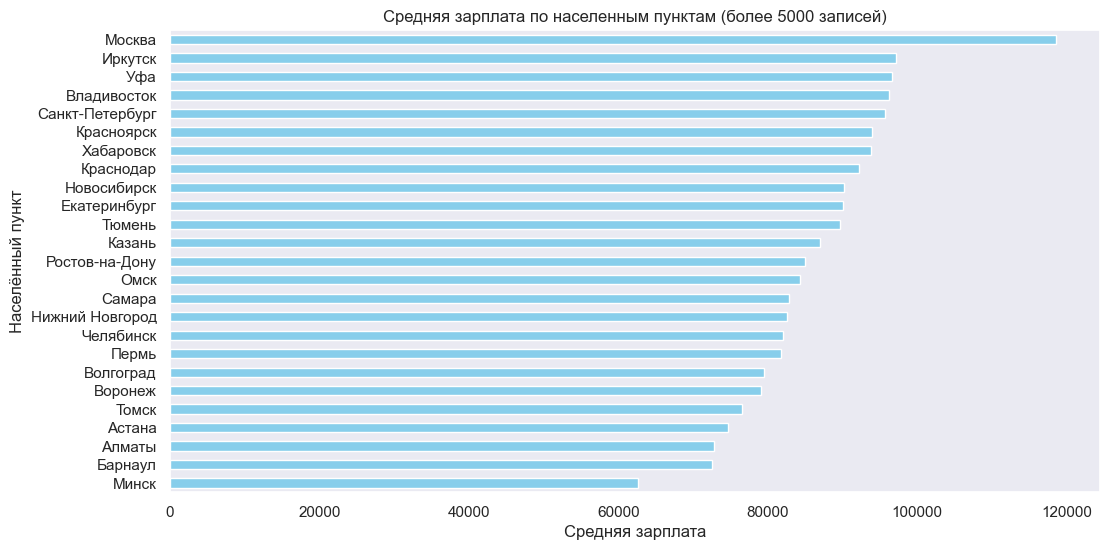

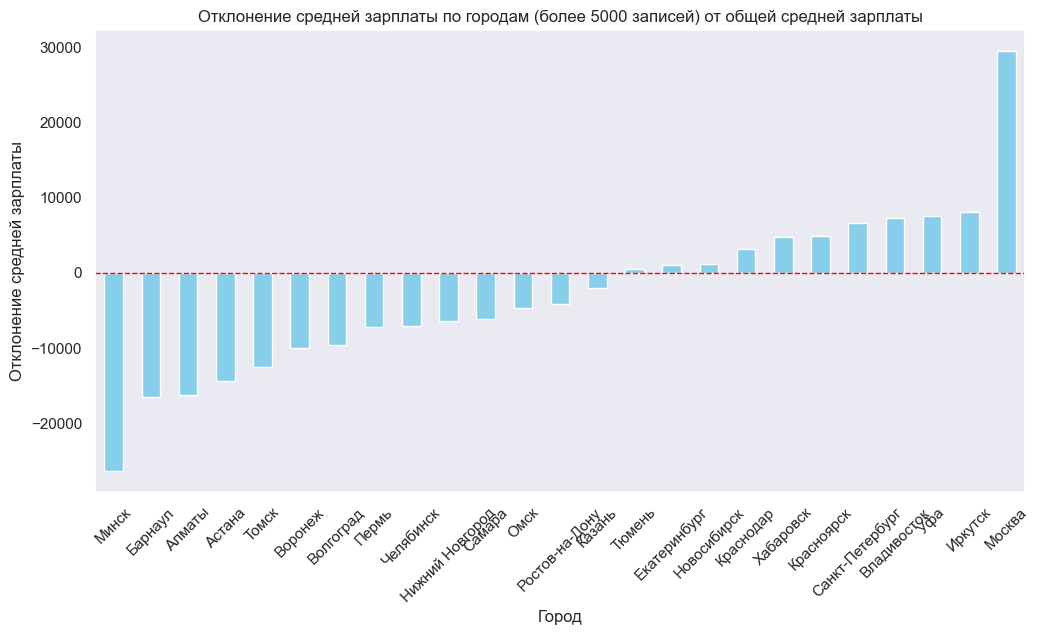

T-статистика: 34.75903885342295, p-значение: 9.713265916324123e-264


In [173]:
print(df['area_name'].isna().sum())

# 1. Общие сведения
print("Уникальные населённые пункты:")
print(df['area_name'].unique())
print("\nКоличество записей по каждому населенному пункту:")
print(df['area_name'].value_counts())

# 2. Анализ зарплат
salary_summary = df.groupby('area_name')['salary'].agg(['mean', 'median', 'min', 'max', 'std'])
print("\nСтатистика по зарплатам:")
print(salary_summary)

# Подсчёт количества записей по каждому населенному пункту
city_counts = df['area_name'].value_counts()

# Фильтрация городов с более чем 1000 записями
cities_with_enough_data = city_counts[city_counts > 5000].index

# Фильтрация DataFrame
filtered_df = df[df['area_name'].isin(cities_with_enough_data)]

# 1. График средних зарплат по населённым пунктам
mean_salary_by_city = filtered_df.groupby('area_name')['salary'].mean().sort_values()

plt.figure(figsize=(12, 6))
mean_salary_by_city.plot(kind='barh', color='skyblue')
plt.title('Средняя зарплата по населенным пунктам (более 5000 записей)')
plt.xlabel('Средняя зарплата')
plt.ylabel('Населённый пункт')
plt.show()

average_salary_by_city = filtered_df.groupby('area_name')['salary'].mean()

overall_average_salary = df['salary'].mean()

deviation = average_salary_by_city - overall_average_salary

# Создание диаграммы
plt.figure(figsize=(12, 6))
deviation.sort_values().plot(kind='bar', color='skyblue')
plt.axhline(0, color='red', linewidth=1, linestyle='--')  # линия нуля
plt.title('Отклонение средней зарплаты по городам (более 5000 записей) от общей средней зарплаты')
plt.xlabel('Город')
plt.ylabel('Отклонение средней зарплаты')
plt.xticks(rotation=45)
plt.show()


# 5. Корреляция и статистические тесты
# Например, тест на значимость различий между зарплатами для двух групп
group1 = df[df['area_name'] == 'Москва']['salary']
group2 = df[df['area_name'] == 'Санкт-Петербург']['salary']
t_stat, p_value = stats.ttest_ind(group1, group2)
print(f"T-статистика: {t_stat}, p-значение: {p_value}")

###### В датасете представлено множество различных географических зон, больше всего вакансий ориентированы на следующие города: Москва                        , Санкт-Петербург, Екатеринбург, Новосибирск, Красноярск
###### Если смотреть на зарплату для самых популярных зон, то можно сказать, что самая большая зарплата будет в Москве, Иркутске и Уфе
###### Средняя зарплата, в городах милиониках больше чем средняя зарплата по датасету
###### Можно вывести закономерность, чем больше вакансий в городе, тем больше средняя зарплата
###### Если сравнить два города Москву и Санкт-Петербург то можно сказать следующее 
###### Сильное различие: T-статистика и p-значение указывают на то, что средние значения групп существенно различаются.
###### Отказ от нулевой гипотезы: Вы можете с высокой степенью уверенности отвергнуть нулевую гипотезу о том, что средние значения двух групп равны.
###### Практическая значимость: Несмотря на статистическую значимость, важно также оценить практическую значимость разницы, учитывая контекст ваших данных и исследования.

##### Столбцы address_city, address_street, address_building, address_raw

###### Столбцы area_name, address_city несут в себе практчески одинаковое значение, поэтому заполним пустые значения столбца address_city значениями из столбца area-name.

0
0
0
0
Частотный анализ по городам:
address_city
Москва               108096
Санкт-Петербург       40923
Екатеринбург          17501
Новосибирск           15593
Красноярск            12671
                      ...  
станица Манычская         1
Шри-Ланка                 1
деревня Елисеевка         1
посёлок Пятовский         1
деревня Лупполово         1
Name: count, Length: 14730, dtype: int64

Топ-10 самых популярных городов:
address_city
Москва             108096
Санкт-Петербург     40923
Екатеринбург        17501
Новосибирск         15593
Красноярск          12671
Краснодар           12005
Казань              10995
Нижний Новгород     10551
Челябинск           10470
Алматы               9833
Name: count, dtype: int64


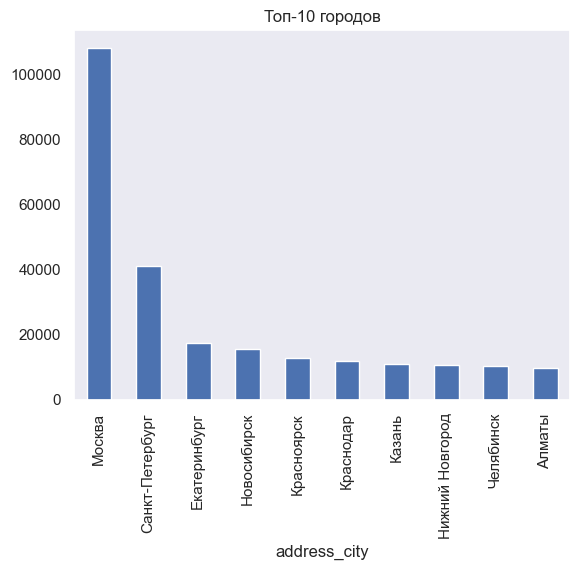

                            count           mean            std        min  \
address_city                                                                 
0.0,0.0                       1.0   52500.000000            NaN   52500.00   
0050211 (село Рождествено)    2.0  161000.000000   29698.484810  140000.00   
1                             8.0   53230.125000   18147.574576   30980.00   
1 Мая                         3.0   62833.333333    2020.725942   61000.00   
1 Раздолье                    2.0   48750.000000    5303.300859   45000.00   
...                           ...            ...            ...        ...   
штат Флорида                  1.0  110000.000000            NaN  110000.00   
шымкент ул Толе би 11         2.0   38631.840000    1400.863386   37641.28   
эмират Дубай                 13.0  330138.115385  378936.328053   50000.00   
№ 1                           1.0   51500.000000            NaN   51500.00   
№ 14                          3.0   76666.666667   31718.816708 

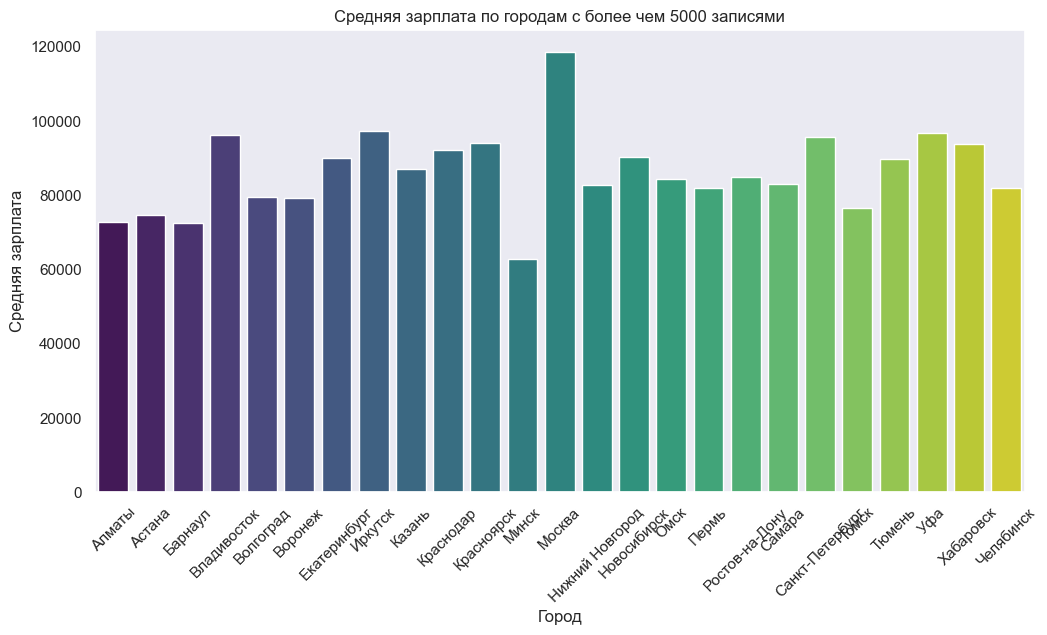

F-статистика: 3.75478037479764, p-значение: 0.0
Частотный анализ по улицам:
address_street
улица Ленина                                                                                   3925
проспект Ленина                                                                                2958
Советская улица                                                                                2923
Промышленная улица                                                                             1924
Ленина                                                                                         1763
                                                                                               ... 
Северо-Восточный административный округ, район Южное Медведково, жилой комплекс Полярная 25       1
М-7, подъезд к Владимиру, 21-й километр                                                           1
Вираншехир, улица 34323                                                                           1
микрорайо

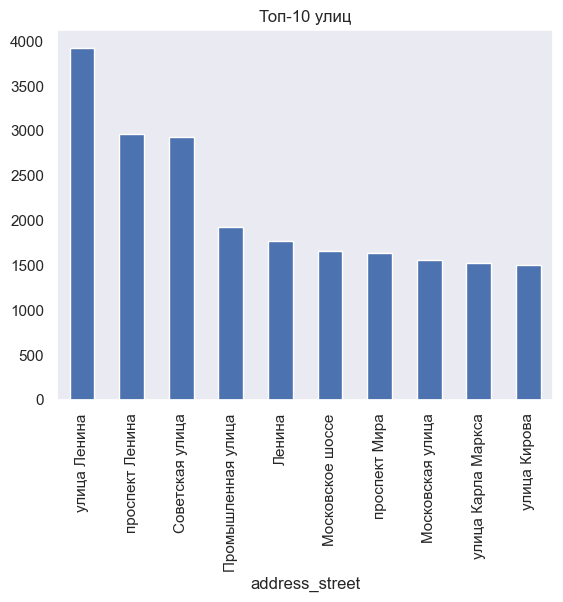

In [203]:
print(df['area_name'].isna().sum())
print(df['address_city'].isna().sum())
df['address_city'] = df['address_city'].replace('', np.nan)
df['address_city'] = df['address_city'].fillna(df['area_name'])
print(df['area_name'].isna().sum())
print(df['address_city'].isna().sum())

# Анализ столбца address_city
print("Частотный анализ по городам:")
print(df['address_city'].value_counts())

print("\nТоп-10 самых популярных городов:")
print(df['address_city'].value_counts().head(10))

# Визуализация распределения улиц (Топ-10)
top_cities = df['address_city'].value_counts().head(10)
top_cities.plot(kind='bar', title='Топ-10 городов')
plt.show()

# Статистические характеристики зарплат по городам
salary_stats_by_city = df.groupby('address_city')['salary'].describe()
print(salary_stats_by_city)

city_salary = df.groupby('area_name').agg(
    count=('salary', 'size'),
    mean_salary=('salary', 'mean')
).reset_index()

city_salary_filtered = city_salary[city_salary['count'] > 5000]

plt.figure(figsize=(12, 6))
sns.barplot(x='area_name', y='mean_salary', data=city_salary_filtered, palette='viridis')
plt.xticks(rotation=45)
plt.title('Средняя зарплата по городам с более чем 5000 записями')
plt.xlabel('Город')
plt.ylabel('Средняя зарплата')
plt.show()

city_groups = [group['salary'].values for name, group in df.groupby('address_city')]
f_statistic, p_value = stats.f_oneway(*city_groups)

print(f'F-статистика: {f_statistic}, p-значение: {p_value}')

# Анализ столбца address_street
print("Частотный анализ по улицам:")
print(df['address_street'].value_counts())

print("\nТоп-10 самых популярных улиц:")
print(df['address_street'].value_counts().head(10))

# Визуализация распределения улиц (Топ-10)
top_streets = df['address_street'].value_counts().head(10)
top_streets.plot(kind='bar', title='Топ-10 улиц')
plt.show()



###### Столбец address_raw несет в себе дублирование информации из столбцов address_city, address_street и adress_building, значит что то одно из этого должно быть удалено, в виду лишнего дублирования информации.
###### Столбце address_building, который несет в себе информацию по номеру дома не нужен в датасет для дальнейшегно анализа. Потому что он никак не колелирует с другими данныии, а так же не играет важной роли при учете заработрой платы. По данному столбцу так же не ведется фильтр на сайте HH.

In [158]:
del df['address_building']
del df['address_raw']

100%|██████████| 709568/709568 [01:14<00:00, 9524.25it/s] 


Строки с несовпадающими адресами:
                                      constructed_address  \
7                Москва, Складочная, д.3 стр.5, д.3 стр.5   
79                               Зеленоград, к1143, к1143   
121                                Зеленоград, к848, к848   
129     Москва, улица Мичуринский Проспект, Олимпийска...   
144            Москва, МКАД, 47-й километр, 47-й километр   
...                                                   ...   
709347  деревня Касимово, жилой комплекс Новокасимово,...   
709377                                  Шымкент, 426, 426   
709432                       посёлок Новый Свет, 102, 102   
709513                             деревня Грибки, 60, 60   
709520          Сектор 3, Заабиль, Бизнес Бей, Бизнес Бей   

                                              address_raw  
7                           Москва, Складочная, д.3 стр.5  
79                                      Зеленоград, к1143  
121                                      Зеленоград, 

##### Столбец address_lat,address_lng

In [174]:
import folium
moscow_df = df[df['area_name'] == 'Москва']

average_salary_moscow = moscow_df['salary'].mean()

map_moscow = folium.Map(location=[55.7558, 37.6176], zoom_start=11)

for idx in range(0, len(moscow_df), 250):  # Шаг 250
    row = moscow_df.iloc[idx]
    if pd.notna(row['address_lat']) and pd.notna(row['address_lng']):
        # Определение цвета маркера на основе зарплаты
        if row['salary'] > average_salary_moscow:
            color = 'red'  # выше средней
        else:
            color = 'blue'  # ниже средней
        
        folium.Marker(
            location=[row['address_lat'], row['address_lng']],
            popup=f"Зарплата: {row['salary']}",
            icon=folium.Icon(color=color)
        ).add_to(map_moscow)

map_moscow.save("moscow_salary_map_every_250.html")

###### Смотря на карту с вакансиями, можно понять, что почти все вакансии находятся в пределах МКАД и чем ближе к центру тем боьлше заработная плата.

##### Столбец address_description

In [160]:
print(df['address_description'].isna().all())

KeyError: 'address_description'

###### Данные столбца все равны NAN значит данный столбец не нужен при анализе датасета

##### Столбец type_id

###### Ввиду повторения (наслаивания) уникальных значений у нас может возникнуть мультикорреляция данных, что плохо отразиться на обещающей способности модели. Удалим столбцы несущие схожую информацию.

In [48]:
del df['type_id']

##### Столбец type_name

False
['Открытая' 'Анонимная' 'Рекламная' 'Закрытая']
Количество объявлений по типам:
type_name
Открытая     708330
Анонимная       804
Рекламная       432
Закрытая          2
Name: count, dtype: int64


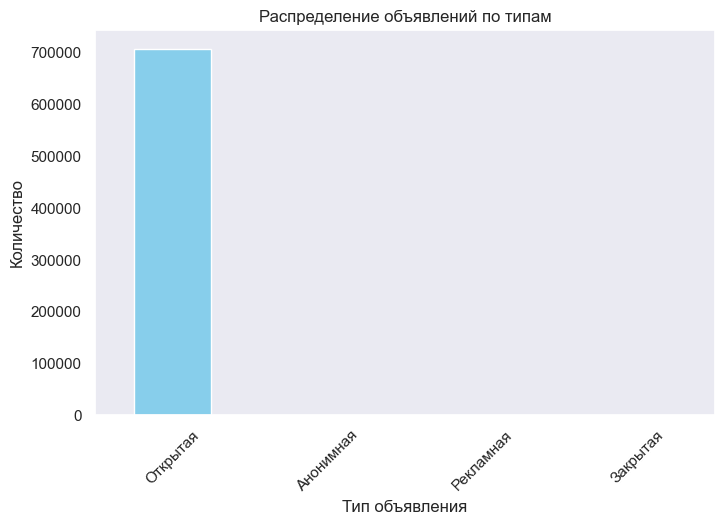


Средняя зарплата по типам объявлений:
type_name
Анонимная    143604.006946
Закрытая      90000.000000
Открытая      89050.571122
Рекламная     55721.990741
Name: salary, dtype: float64


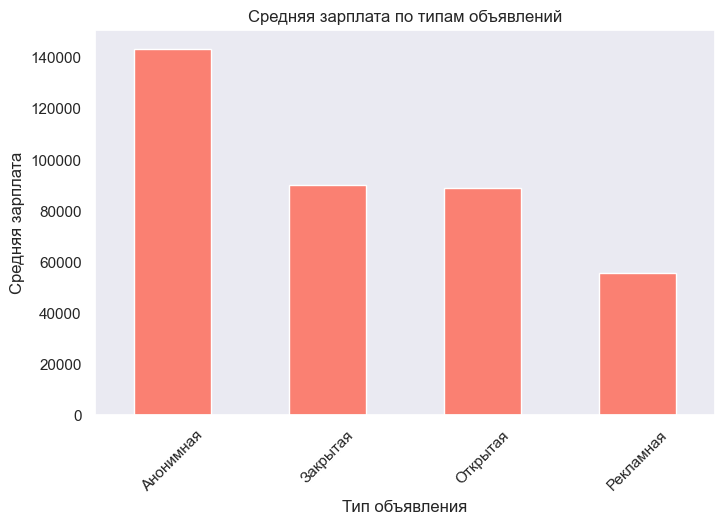

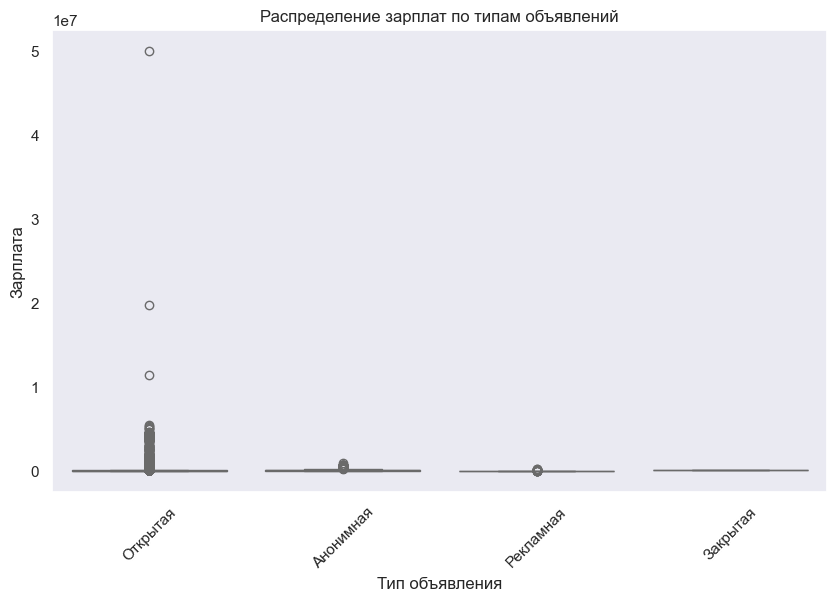


Пропуски в данных:
Пропуски в столбце salary: 0
Пропуски в столбце type_name: 0


In [164]:
print(df['type_name'].isna().any())
print(df['type_name'].unique())

type_counts = df['type_name'].value_counts()
print("Количество объявлений по типам:")
print(type_counts)

# Построение гистограммы для количества объявлений по типам
plt.figure(figsize=(8, 5))
type_counts.plot(kind='bar', color='skyblue')
plt.title('Распределение объявлений по типам')
plt.xlabel('Тип объявления')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

# 2. Средняя зарплата по типам объявлений
mean_salary_by_type = df.groupby('type_name')['salary'].mean()
print("\nСредняя зарплата по типам объявлений:")
print(mean_salary_by_type)

# Построение столбчатой диаграммы средней зарплаты по типам
plt.figure(figsize=(8, 5))
mean_salary_by_type.plot(kind='bar', color='salmon')
plt.title('Средняя зарплата по типам объявлений')
plt.xlabel('Тип объявления')
plt.ylabel('Средняя зарплата')
plt.xticks(rotation=45)
plt.show()

# 3. Boxplot (ящик с усами) зарплат по типам объявлений
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='type_name', y='salary', palette='Set3')
plt.title('Распределение зарплат по типам объявлений')
plt.xlabel('Тип объявления')
plt.ylabel('Зарплата')
plt.xticks(rotation=45)
plt.show()

# 4. Проверка пропусков в столбцах salary и type_name
missing_salary = df['salary'].isna().sum()
missing_type_name = df['type_name'].isna().sum()
print("\nПропуски в данных:")
print(f"Пропуски в столбце salary: {missing_salary}")
print(f"Пропуски в столбце type_name: {missing_type_name}")

In [165]:
from scipy.stats import f_oneway

# 1. Стандартное отклонение и медиана зарплат для каждого типа объявления
salary_stats_by_type = df.groupby('type_name')['salary'].agg(['mean', 'std', 'median'])
print("\nСредняя зарплата, стандартное отклонение и медиана по типам объявлений:")
print(salary_stats_by_type)

# 2. Тест на значимость различий зарплат между типами объявлений (ANOVA)
# Проверяем, достаточно ли данных для каждого типа объявления
grouped_data = [df[df['type_name'] == type_name]['salary'].dropna() for type_name in df['type_name'].unique()]

# Если есть хотя бы два разных типа с достаточными данными для теста:
if all(len(group) > 1 for group in grouped_data):
    anova_result = f_oneway(*grouped_data)
    print("\nРезультаты теста ANOVA на значимость различий между средними зарплатами по типам объявлений:")
    print(f"F-статистика: {anova_result.statistic:.2f}, p-значение: {anova_result.pvalue:.4f}")

    if anova_result.pvalue < 0.05:
        print("Различия между зарплатами по типам значимы на уровне 5%")
    else:
        print("Различия между зарплатами по типам НЕ значимы на уровне 5%")
else:
    print("Недостаточно данных для проведения ANOVA теста.")



Средняя зарплата, стандартное отклонение и медиана по типам объявлений:
                    mean            std    median
type_name                                        
Анонимная  143604.006946  107520.092306  110000.0
Закрытая    90000.000000       0.000000   90000.0
Открытая    89050.571122   99598.524557   70000.0
Рекламная   55721.990741   26343.325807   50000.0

Результаты теста ANOVA на значимость различий между средними зарплатами по типам объявлений:
F-статистика: 96.52, p-значение: 0.0000
Различия между зарплатами по типам значимы на уровне 5%


###### Судя по анализу приведеному выше, можно сделать следующие выводы:
###### Практически все объявления это открытые вакансии
###### Анонимные вакансии в среднем предлагают более большую заработную плату
###### Существенные различия: Результаты теста ANOVA показывают, что существует статистически значимое различие в средних зарплатах между типами объявлений.
###### Практическое значение: Эти различия могут быть важны для принятия решений или для дальнейшего анализа, например, для оценки, какие типы объявлений предлагают более высокие зарплаты.
###### Дальнейший анализ: Если ANOVA показала значимость различий, обычно полезно провести дополнительные пост-хок тесты (например, тест Тьюки), чтобы определить, какие конкретные группы (типы объявлений) отличаются друг от друга.

##### Столбец address_metro_station_name

In [124]:
# Проверяем на целостность данных
print(df['address_metro_stations_0_station_name'].isna().any())
print(df['address_metro_station_name'].isna().any())

# Города с метро, взято из приложения Яндекс.Метро
city_with_metro = [
    'Волгоград', 'Екатеринбург', 'Казань', 'Москва', 'Нижний Новгород', 'Новосибирск', 'Самара', 'Санкт-Петербург', 'Вена', 'Баку', 'Ереван', 'Минск', 
    'София', 'Будапешт', 'Берлин', 'Афины', 'Тбилиси', 'Милан', 'Рим', 'Алматы', 'Дубай', 'Варшава', 'Лиссабон', 'Бухарест',
    'Сан-Франциско', 'Адана', 'Анкара', 'Бурса', 'Измир', 'Стамбул', 'Ташкент', 'Днепр', 'Киев', 'Харьков', 'Хельсинки', 'Прага'
    'Стокгольм'
                   ]
# Замена значений
def replace_nan(row):
    if pd.isna(row['address_metro_station_name']) and row['area_name'] in city_with_metro:
        row['address_metro_station_name'] = 'Станция не указана'
    elif pd.isna(row['address_metro_station_name']):
        row['address_metro_station_name'] = 'Нет метро'
    
    if pd.isna(row['address_metro_stations_0_station_name']) and row['area_name'] in city_with_metro:
        row['address_metro_stations_0_station_name'] = 'Станция не указана'
    elif pd.isna(row['address_metro_stations_0_station_name']):
        row['address_metro_stations_0_station_name'] = 'Нет метро'
    
    return row

df = df.progress_apply(replace_nan, axis=1)

# Проверка на то что столбцы абсолютно одинаковы
print((df['address_metro_stations_0_station_name'] == df['address_metro_station_name']).all())

True
True


100%|██████████| 709568/709568 [00:48<00:00, 14768.39it/s]


True


###### Следуя из того что столбцы address_metro_stations_0_station_name и address_metro_station_name абсолютно одинаковы, то один из них можно удалить

In [108]:
del df['address_metro_stations_0_station_name']

###### Проанализируем оставшийся столбец

            Количество  Средняя зарплата
Есть метро      259898     101053.521636
Не указана           0          0.000000
Нет метро       449670      82178.691926


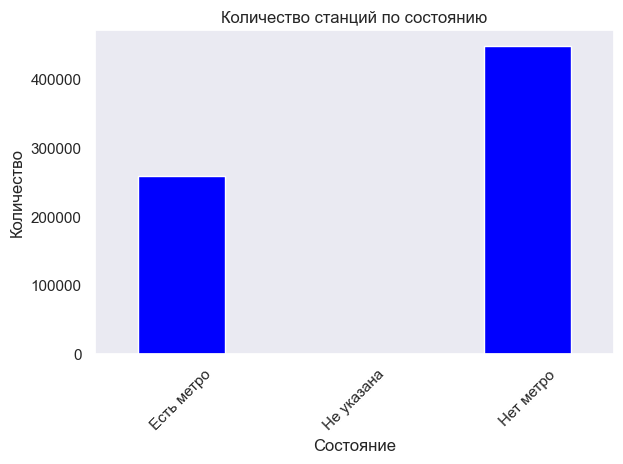

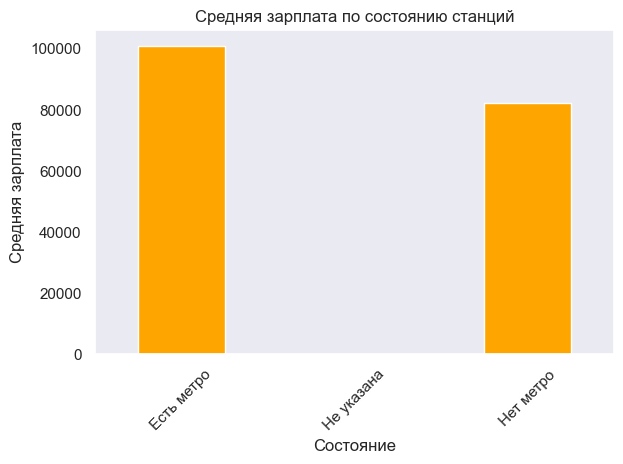

In [129]:
# Определяем условия для категорий
conditions = {
    'Есть метро': df['address_metro_station_name'] != 'Нет метро',
    'Не указана': df['address_metro_station_name'] == 'Не указана',
    'Нет метро': df['address_metro_station_name'] == 'Нет метро'
}

# Подсчет количества и средней зарплаты
summary = {
    'Количество': [],
    'Средняя зарплата': []
}

# Заполнение summary
for key, condition in conditions.items():
    count = len(df[condition])
    average_salary = df[condition]['salary'].mean() if count > 0 else 0
    summary['Количество'].append(count)
    summary['Средняя зарплата'].append(average_salary)

# Создание DataFrame для результатов
summary_df = pd.DataFrame(summary, index=conditions.keys())

# Вывод результата в консоль
print(summary_df)

# Построение графика количества станций
summary_df[['Количество']].plot(kind='bar', legend=False, color='blue')
plt.title('Количество станций по состоянию')
plt.xlabel('Состояние')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Построение графика средней зарплаты
summary_df[['Средняя зарплата']].plot(kind='bar', legend=False, color='orange')
plt.title('Средняя зарплата по состоянию станций')
plt.xlabel('Состояние')
plt.ylabel('Средняя зарплата')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

###### Так же посмотрим на самые популярные станции и посмотрим в на каких станциях в Москве получают больше всего

                            Количество  Средняя зарплата
address_metro_station_name                              
Белорусская                       1513     129060.497026
Автозаводская                     1486     284877.724764
Деловой центр                     1429     137588.707698
Киевская                          1413     122446.482661
Авиамоторная                      1290     109154.598450


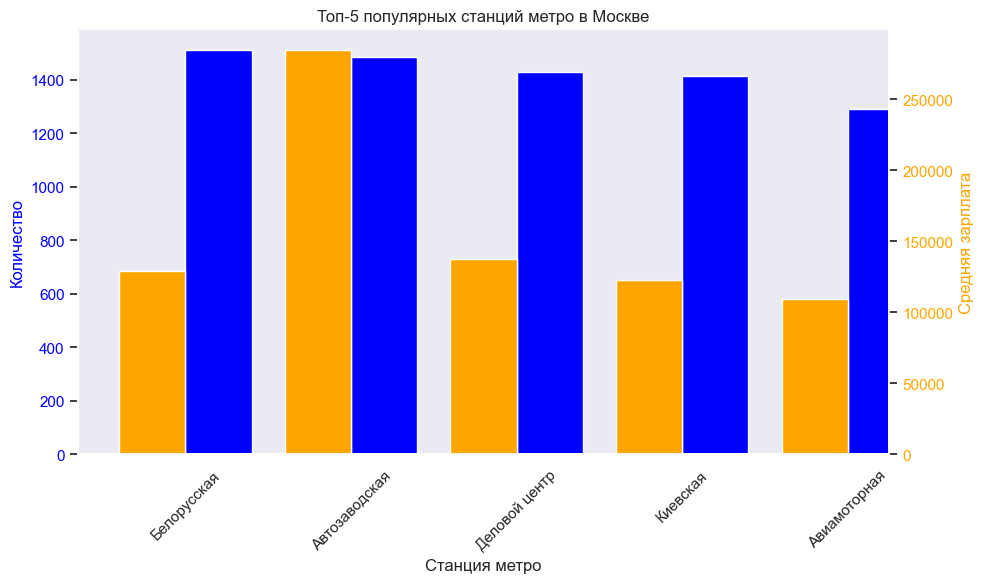

Топ-5 самых популярных станций по количеству (все города):
address_metro_station_name
Горьковская      1978
Автозаводская    1712
Белорусская      1537
Деловой центр    1459
Киевская         1415
Name: count, dtype: int64

Топ-5 станций по средней зарплате (только Москва):
address_metro_station_name
Автозаводская    300454.532793
Малино           300000.000000
Боровицкая       208893.900000
Лесопарковая     205000.000000
Давыдково        190309.980488
Name: salary, dtype: float64


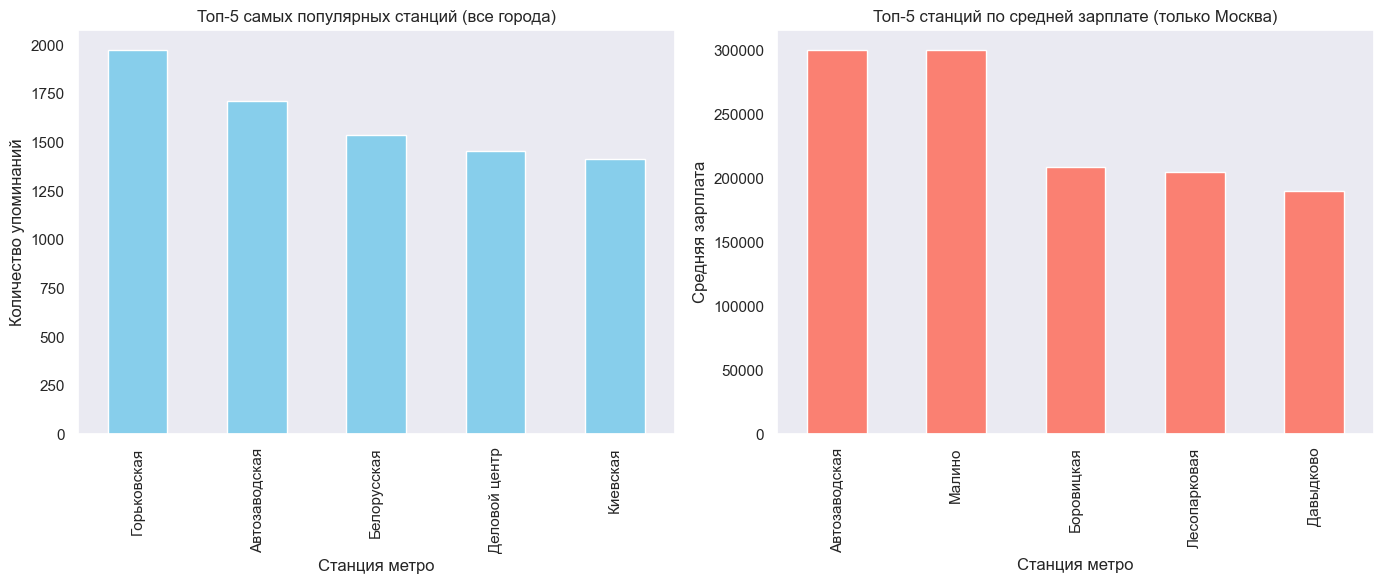

In [137]:
# Фильтрация данных для города Москва и только с указанными станциями
filtered_df = df[(df['area_name'] == 'Москва') & 
                 (df['address_metro_station_name'] != 'Нет метро') & 
                 (df['address_metro_station_name'] != 'Станция не указана')]

# Подсчет количества упоминаний и средней зарплаты по станциям
station_counts = filtered_df['address_metro_station_name'].value_counts().nlargest(5)
average_salaries = filtered_df.groupby('address_metro_station_name')['salary'].mean()

# Создание DataFrame для топ-5 станций
top_stations = pd.DataFrame({
    'Количество': station_counts,
    'Средняя зарплата': average_salaries[station_counts.index]
})

# Вывод результата в консоль
print(top_stations)

# Построение графика для топ-5 станций
fig, ax1 = plt.subplots(figsize=(10, 6))

# График количества станций
top_stations['Количество'].plot(kind='bar', ax=ax1, color='blue', position=0, width=0.4, label='Количество')
ax1.set_ylabel('Количество', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Создание второго Y-оси для средней зарплаты
ax2 = ax1.twinx()
top_stations['Средняя зарплата'].plot(kind='bar', ax=ax2, color='orange', position=1, width=0.4, label='Средняя зарплата')
ax2.set_ylabel('Средняя зарплата', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Настройки графика
plt.title('Топ-5 популярных станций метро в Москве')
ax1.set_xlabel('Станция метро')
ax1.set_xticklabels(top_stations.index, rotation=45)
plt.tight_layout()
plt.show()

# 1. Топ-5 самых популярных станций для всех городов (исключая "Нет метро" и "Не указана")
filtered_df_all = df[(df['address_metro_station_name'] != 'Нет метро') & (df['address_metro_station_name'] != 'Станция не указана')]
top_stations_all = filtered_df_all['address_metro_station_name'].value_counts().nlargest(5)

# 2. Топ-5 станций по средней зарплате для Москвы (исключая "Нет метро" и "Не указана")
filtered_df_moscow = df[(df['area_name'] == 'Москва') & (df['address_city'] == 'Москва') &
                        (df['address_metro_station_name'] != 'Нет метро') & 
                        (df['address_metro_station_name'] != 'Станция не указана')]
top_salary_stations_moscow = filtered_df_moscow.groupby('address_metro_station_name')['salary'].mean().nlargest(5)

print("Топ-5 самых популярных станций по количеству (все города):")
print(top_stations_all)
print("\nТоп-5 станций по средней зарплате (только Москва):")
print(top_salary_stations_moscow)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

top_stations_all.plot(kind='bar', ax=axs[0], color='skyblue')
axs[0].set_title('Топ-5 самых популярных станций (все города)')
axs[0].set_xlabel('Станция метро')
axs[0].set_ylabel('Количество упоминаний')

top_salary_stations_moscow.plot(kind='bar', ax=axs[1], color='salmon')
axs[1].set_title('Топ-5 станций по средней зарплате (только Москва)')
axs[1].set_xlabel('Станция метро')
axs[1].set_ylabel('Средняя зарплата')

# Показ графиков
plt.tight_layout()
plt.show()

##### Столбец address_metro_station_id 

###### Ввиду повторения (наслаивания) уникальных значений у нас может возникнуть мультикорреляция данных, что плохо отразиться на обещающей способности модели. Удалим столбцы несущие схожую информацию.

In [47]:
del df['address_metro_station_id']

##### Столбцы address_metro_lat и address_metro_lng

In [176]:
moscow_df = df[(df['area_name'] == 'Москва') & 
                (~df['address_metro_station_name'].isin(['Нет метро', 'Станция не указана']))]

top_stations = moscow_df['address_metro_station_name'].value_counts().nlargest(10).index.tolist()

map_moscow = folium.Map(location=[55.7558, 37.6176], zoom_start=11)

# Определяем уникальные цвета для каждой станции
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 
          'beige', 'darkblue', 'darkgreen']

for i, station in enumerate(top_stations):
    station_df = moscow_df[moscow_df['address_metro_station_name'] == station]
    
    avg_salary = station_df['salary'].mean()
    
    first_row = station_df.iloc[0]
    
    folium.Marker(
        location=[first_row['address_metro_lat'], first_row['address_metro_lng']],
        popup=f"{station}<br>Средняя зарплата: {avg_salary:.2f}",
        icon=folium.Icon(color=colors[i % len(colors)])  # Используем разные цвета для маркеров
    ).add_to(map_moscow)

map_moscow.save("moscow_top_stations_salary_map.html")

##### Столбец address_metro_stations_0_line_name и address_metro_line_name

True
True


100%|██████████| 709568/709568 [00:40<00:00, 17366.45it/s]


True
            Количество  Средняя зарплата
Есть метро      259898     101053.521636
Не указана      139731     100386.758021
Нет метро       449670      82178.691926


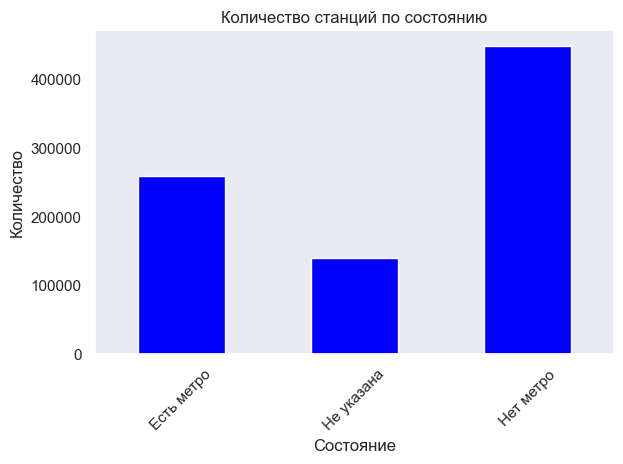

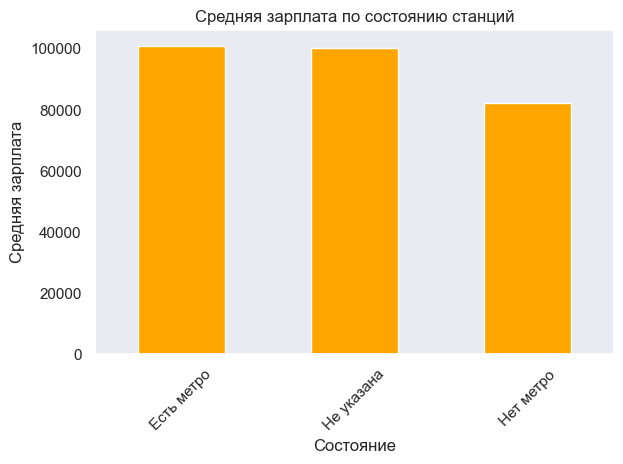

In [139]:
# Проверяем на целостность данных
print(df['address_metro_stations_0_line_name'].isna().any())
print(df['address_metro_line_name'].isna().any())

# Замена значений
def replace_nan_for_line_metro(row):
    if pd.isna(row['address_metro_line_name']) and row['area_name'] in city_with_metro:
        row['address_metro_line_name'] = 'Линия не указана'
    elif pd.isna(row['address_metro_line_name']):
        row['address_metro_line_name'] = 'Нет метро'
    
    if pd.isna(row['address_metro_stations_0_line_name']) and row['area_name'] in city_with_metro:
        row['address_metro_stations_0_line_name'] = 'Линия не указана'
    elif pd.isna(row['address_metro_stations_0_line_name']):
        row['address_metro_stations_0_line_name'] = 'Нет метро'
    
    return row

df = df.progress_apply(replace_nan_for_line_metro, axis=1)

# Проверка на то что столбцы абсолютно одинаковы
print((df['address_metro_stations_0_line_name'] == df['address_metro_line_name']).all())

# Определяем условия для категорий
conditions = {
    'Есть метро': df['address_metro_line_name'] != 'Нет метро',
    'Не указана': df['address_metro_line_name'] == 'Линия не указана',
    'Нет метро': df['address_metro_line_name'] == 'Нет метро'
}

# Подсчет количества и средней зарплаты
summary = {
    'Количество': [],
    'Средняя зарплата': []
}

# Заполнение summary
for key, condition in conditions.items():
    count = len(df[condition])
    average_salary = df[condition]['salary'].mean() if count > 0 else 0
    summary['Количество'].append(count)
    summary['Средняя зарплата'].append(average_salary)

# Создание DataFrame для результатов
summary_df = pd.DataFrame(summary, index=conditions.keys())

# Вывод результата в консоль
print(summary_df)

# Построение графика количества станций
summary_df[['Количество']].plot(kind='bar', legend=False, color='blue')
plt.title('Количество станций по состоянию')
plt.xlabel('Состояние')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Построение графика средней зарплаты
summary_df[['Средняя зарплата']].plot(kind='bar', legend=False, color='orange')
plt.title('Средняя зарплата по состоянию станций')
plt.xlabel('Состояние')
plt.ylabel('Средняя зарплата')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

                            Количество  Средняя зарплата
address_metro_line_name                                 
Замоскворецкая                   12136     135084.613299
Арбатско-Покровская              10451     109717.936083
Сокольническая                    8063     112346.264108
Таганско-Краснопресненская        5481     111540.503102
Калужско-Рижская                  5217     107739.190339


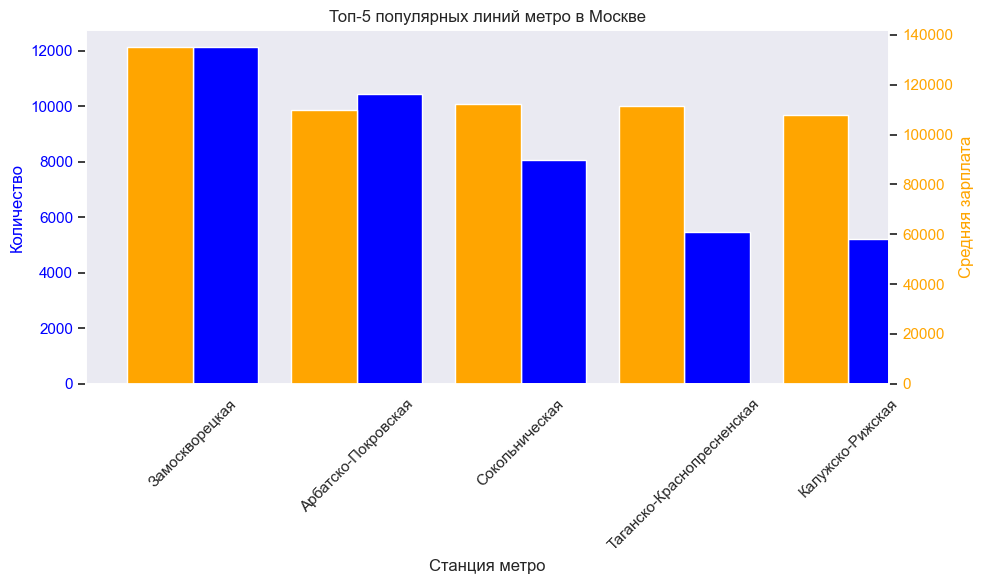

Топ-5 самых популярных линий по количеству (все города):
address_metro_line_name
Замоскворецкая                12433
Арбатско-Покровская           10683
Сокольническая                 8204
Кировско-Выборгская            6314
Таганско-Краснопресненская     5949
Name: count, dtype: int64

Топ-5 линий по средней зарплате (только Москва):
address_metro_line_name
Замоскворецкая             137250.081008
Большая кольцевая линия    124197.155533
Филевская                  120356.400856
Кольцевая                  119913.623922
Монорельс                  116095.982143
Name: salary, dtype: float64


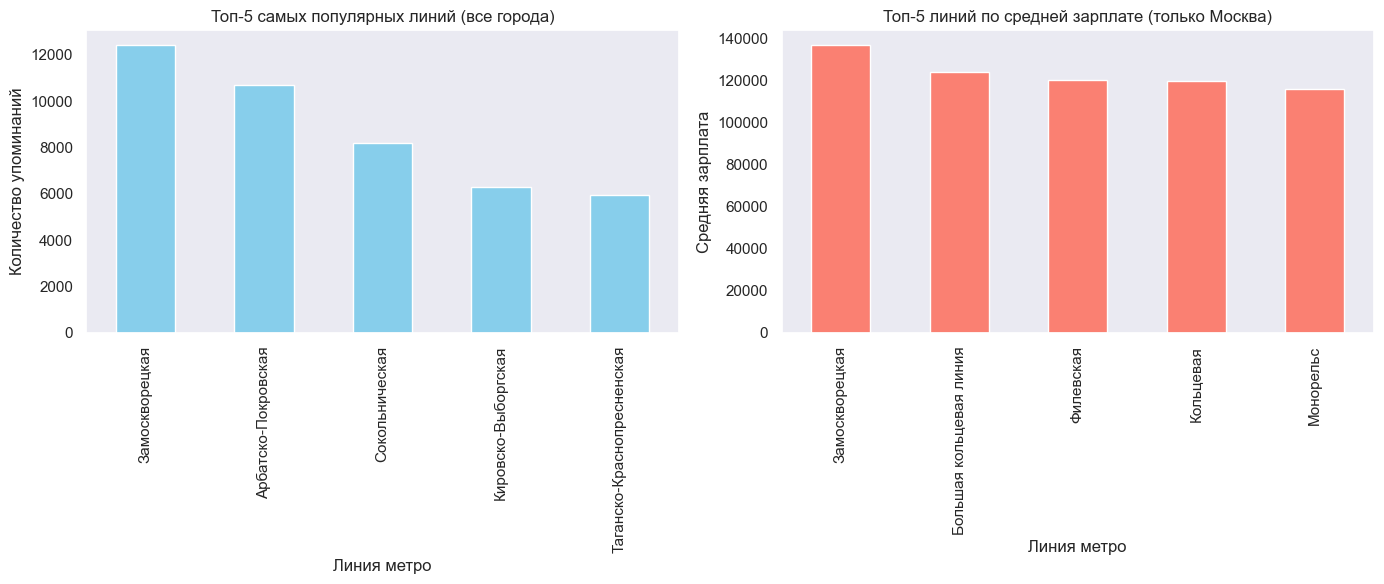

In [141]:
# Фильтрация данных для города Москва и только с указанными станциями
filtered_df = df[(df['area_name'] == 'Москва') & 
                 (df['address_metro_line_name'] != 'Нет метро') & 
                 (df['address_metro_line_name'] != 'Линия не указана')]

# Подсчет количества упоминаний и средней зарплаты по станциям
station_counts = filtered_df['address_metro_line_name'].value_counts().nlargest(5)
average_salaries = filtered_df.groupby('address_metro_line_name')['salary'].mean()

# Создание DataFrame для топ-5 станций
top_stations = pd.DataFrame({
    'Количество': station_counts,
    'Средняя зарплата': average_salaries[station_counts.index]
})

# Вывод результата в консоль
print(top_stations)

# Построение графика для топ-5 станций
fig, ax1 = plt.subplots(figsize=(10, 6))

# График количества станций
top_stations['Количество'].plot(kind='bar', ax=ax1, color='blue', position=0, width=0.4, label='Количество')
ax1.set_ylabel('Количество', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Создание второго Y-оси для средней зарплаты
ax2 = ax1.twinx()
top_stations['Средняя зарплата'].plot(kind='bar', ax=ax2, color='orange', position=1, width=0.4, label='Средняя зарплата')
ax2.set_ylabel('Средняя зарплата', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Настройки графика
plt.title('Топ-5 популярных линий метро в Москве')
ax1.set_xlabel('Станция метро')
ax1.set_xticklabels(top_stations.index, rotation=45)
plt.tight_layout()
plt.show()

# 1. Топ-5 самых популярных станций для всех городов (исключая "Нет метро" и "Не указана")
filtered_df_all = df[(df['address_metro_line_name'] != 'Нет метро') & (df['address_metro_line_name'] != 'Линия не указана')]
top_stations_all = filtered_df_all['address_metro_line_name'].value_counts().nlargest(5)

# 2. Топ-5 станций по средней зарплате для Москвы (исключая "Нет метро" и "Не указана")
filtered_df_moscow = df[(df['area_name'] == 'Москва') & (df['address_city'] == 'Москва') &
                        (df['address_metro_line_name'] != 'Нет метро') & 
                        (df['address_metro_line_name'] != 'Линия не указана')]
top_salary_stations_moscow = filtered_df_moscow.groupby('address_metro_line_name')['salary'].mean().nlargest(5)

print("Топ-5 самых популярных линий по количеству (все города):")
print(top_stations_all)
print("\nТоп-5 линий по средней зарплате (только Москва):")
print(top_salary_stations_moscow)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

top_stations_all.plot(kind='bar', ax=axs[0], color='skyblue')
axs[0].set_title('Топ-5 самых популярных линий (все города)')
axs[0].set_xlabel('Линия метро')
axs[0].set_ylabel('Количество упоминаний')

top_salary_stations_moscow.plot(kind='bar', ax=axs[1], color='salmon')
axs[1].set_title('Топ-5 линий по средней зарплате (только Москва)')
axs[1].set_xlabel('Линия метро')
axs[1].set_ylabel('Средняя зарплата')

# Показ графиков
plt.tight_layout()
plt.show()

##### Столбец address_metro_line_id

###### Ввиду повторения (наслаивания) уникальных значений у нас может возникнуть мультикорреляция данных, что плохо отразиться на обещающей способности модели. Удалим столбцы несущие схожую информацию.

In [46]:
del df['address_metro_line_id']

##### Столбец address_metro_stations_0_station_id

###### Ввиду повторения (наслаивания) уникальных значений у нас может возникнуть мультикорреляция данных, что плохо отразиться на обещающей способности модели. Удалим столбцы несущие схожую информацию.

In [45]:
del df['address_metro_stations_0_station_id']

##### Столбец snippet_requirement

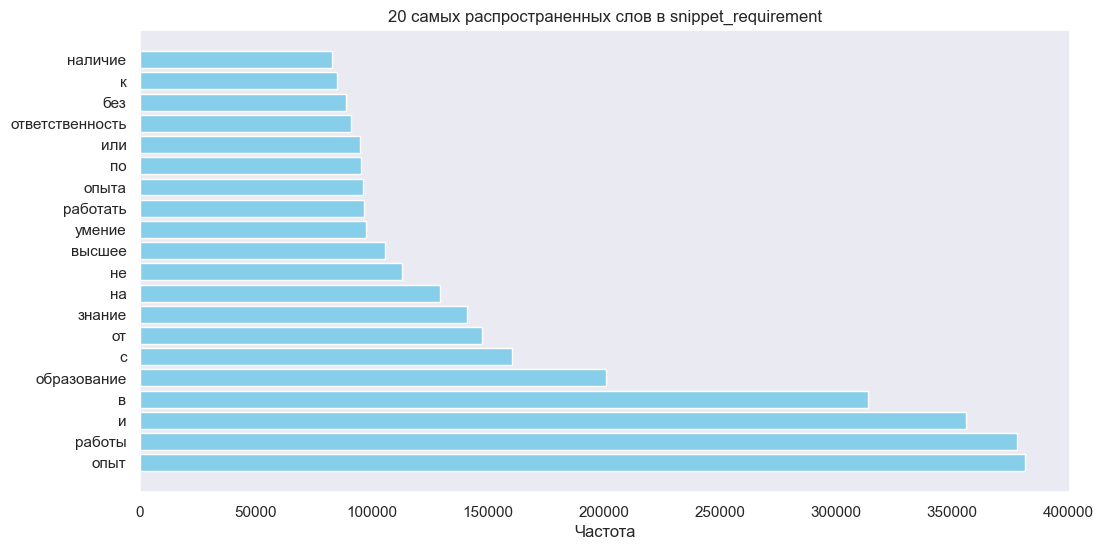

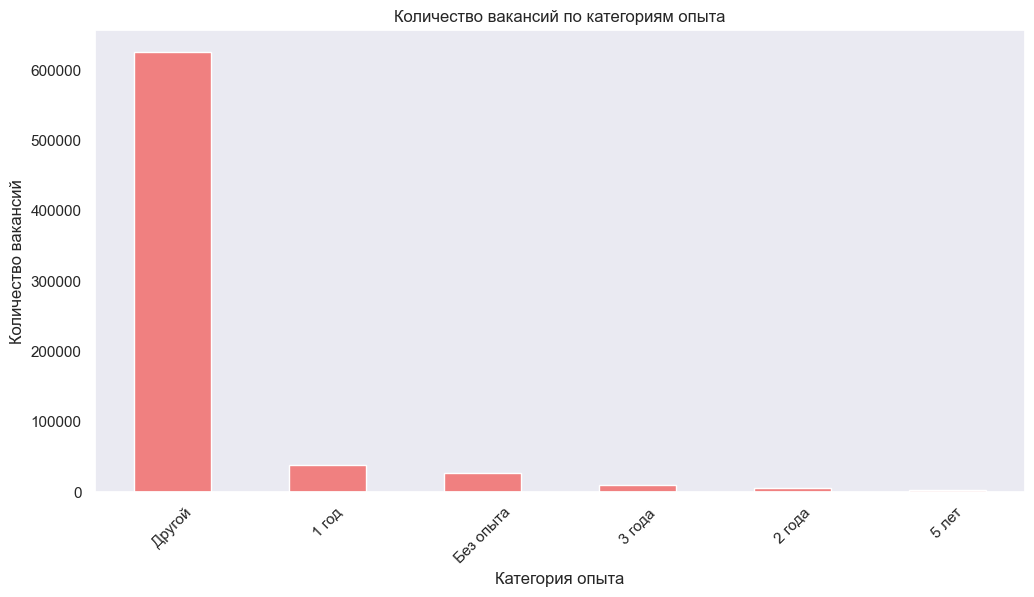

In [181]:
from collections import Counter
import re

df['snippet_requirement'] = df['snippet_requirement'].fillna("Без опыта")

df['cleaned_snippet'] = df['snippet_requirement'].str.lower().str.replace(r'[^\w\s]', '', regex=True)

# Создаем список всех слов
all_words = ' '.join(df['cleaned_snippet']).split()

# Считаем частоту слов
word_counts = Counter(all_words)

# Получаем 20 самых распространенных слов
common_words = word_counts.most_common(20)

# Создаем DataFrame для удобства визуализации
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Count'])

# Визуализируем
plt.figure(figsize=(12, 6))
plt.barh(common_words_df['Word'], common_words_df['Count'], color='skyblue')
plt.xlabel('Частота')
plt.title('20 самых распространенных слов в snippet_requirement')
plt.show()

def categorize_experience(requirement):
    if 'без опыта' in requirement:
        return 'Без опыта'
    elif 'от 1 года' in requirement:
        return '1 год'
    elif 'от 2 лет' in requirement:
        return '2 года'
    elif 'от 3 лет' in requirement:
        return '3 года'
    elif 'от 5 лет' in requirement:
        return '5 лет'
    else:
        return 'Другой'

df['experience_category'] = df['snippet_requirement'].apply(categorize_experience)

# Считаем количество вакансий по категориям опыта
experience_counts = df['experience_category'].value_counts()

# Визуализируем
plt.figure(figsize=(12, 6))
experience_counts.plot(kind='bar', color='lightcoral')
plt.title('Количество вакансий по категориям опыта')
plt.xlabel('Категория опыта')
plt.ylabel('Количество вакансий')
plt.xticks(rotation=45)
plt.show()

##### Столбец employer_accredited_it_employer

In [30]:
nan_per_employer_accredited_it_employer = df_nan.loc[df_nan.index == 'employer_accredited_it_employer', 'Процент пропущенных значений'][0]
print(f'Процент пропущенных значений в столбце employer_accredited_it_employer: {nan_per_employer_accredited_it_employer:.3%}')

NameError: name 'df_nan' is not defined

Хоть процент пропущенных значений слишком мал, заполним пропуски константой Unknown, чтобы не терять информацию. В дальнейшем посмотрим влияет ли пропуск на зарплату кандидата.

In [17]:
df['employer_accredited_it_employer'].fillna('Unknown', inplace=True)

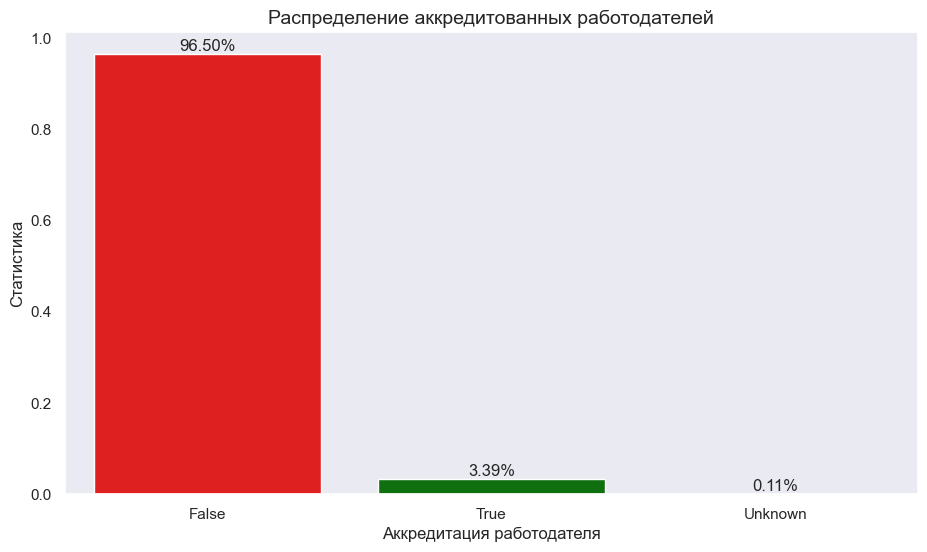

In [18]:
employer_accredited_it_employer_palette = {True: 'green', False: 'red', 'Unknown': 'black'}
f, ax = plt.subplots(figsize=(11, 6))

ax = sns.barplot(
    x=df['employer_accredited_it_employer'].value_counts(normalize=True).index,
    y=df['employer_accredited_it_employer'].value_counts(normalize=True),
    palette=employer_accredited_it_employer_palette,
    hue=df['employer_accredited_it_employer'].value_counts(normalize=True).index,
    legend=False
)
plt.title('Распределение аккредитованных работодателей', fontsize=14)
plt.xlabel('Аккредитация работодателя')
plt.ylabel('Статистика')

for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height())
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()

In [19]:
# Проверим группы на нормальность и гомогенность дисперсий, при положительном результате сделаем ANOVA тестирование

groupA = df.loc[df['employer_accredited_it_employer'] == False, 'salary']
groupB = df.loc[df['employer_accredited_it_employer'] == True, 'salary']
groupC = df.loc[df['employer_accredited_it_employer'] == 'Unknown', 'salary']

def check_normality(group, name):
    stat, p_value = stats.shapiro(group)
    print(f"Группа {name} - Тест Шапиро-Уилка: Статистика = {stat:.4f}, p-значение = {p_value:.4f}")
    if p_value > 0.05:
        print(f"Группа {name}: Данные распределены нормально.")
    else:
        print(f"Группа {name}: Данные не распределены нормально.")

check_normality(groupA, 'A')
print()
check_normality(groupB, 'B')
check_normality(groupC, 'C')

stat, p_value = stats.levene(groupA, groupB, groupC)
print(f"\nТест Левена: Статистика = {stat:.4f}, p-значение = {p_value:.4f}")
if p_value > 0.05:
    print("Дисперсии считать одинаковыми.")
else:
    print("Дисперсии считать неодинаковыми.")

Группа A - Тест Шапиро-Уилка: Статистика = 0.2987, p-значение = 0.0000
Группа A: Данные не распределены нормально.

Группа B - Тест Шапиро-Уилка: Статистика = 0.8964, p-значение = 0.0000
Группа B: Данные не распределены нормально.
Группа C - Тест Шапиро-Уилка: Статистика = 0.7347, p-значение = 0.0000
Группа C: Данные не распределены нормально.

Тест Левена: Статистика = 443.7701, p-значение = 0.0000
Дисперсии считать неодинаковыми.


In [20]:
# Посмотрим на Крускала-Уоллиса - непараметрический тест для сравнения различий двух и более выборок.

h_stat, p_value = stats.kruskal(groupA, groupB, groupC)
print(f'Kruskal-Wallis H-statistic: {h_stat}, P-value: {p_value}')

if p_value < 0.05:
    print('Есть статистически значимые различия между группами')
else:
    print('Нет статистически значимых различий между группами.')

Kruskal-Wallis H-statistic: 3847.9087704551407, P-value: 0.0
Есть статистически значимые различия между группами


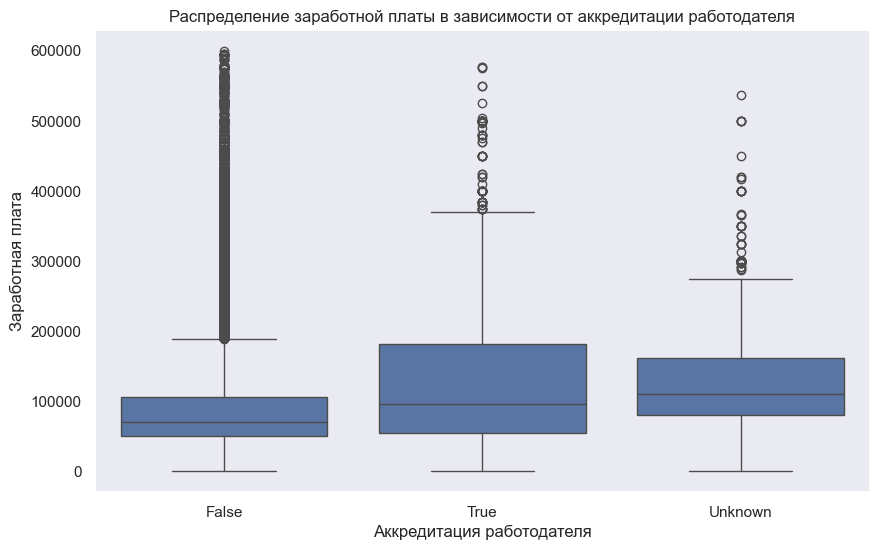

In [21]:
percentile_99 = df['salary'].quantile(0.999) # Для наглядной визуализации возьмём salary < 99.9% выборки
filtered_df = df[df['salary'] < percentile_99]

# Преобразование категориальной переменной в числовую
filtered_df['employer_accredited_it_employer_numeric'] = filtered_df['employer_accredited_it_employer'].map({True: 1, False: 0, 'Unknown': -1})

plt.figure(figsize=(10, 6))
sns.boxplot(x='employer_accredited_it_employer', y='salary', data=filtered_df)
plt.title('Распределение заработной платы в зависимости от аккредитации работодателя')
plt.xlabel('Аккредитация работодателя')
plt.ylabel('Заработная плата')
plt.show()

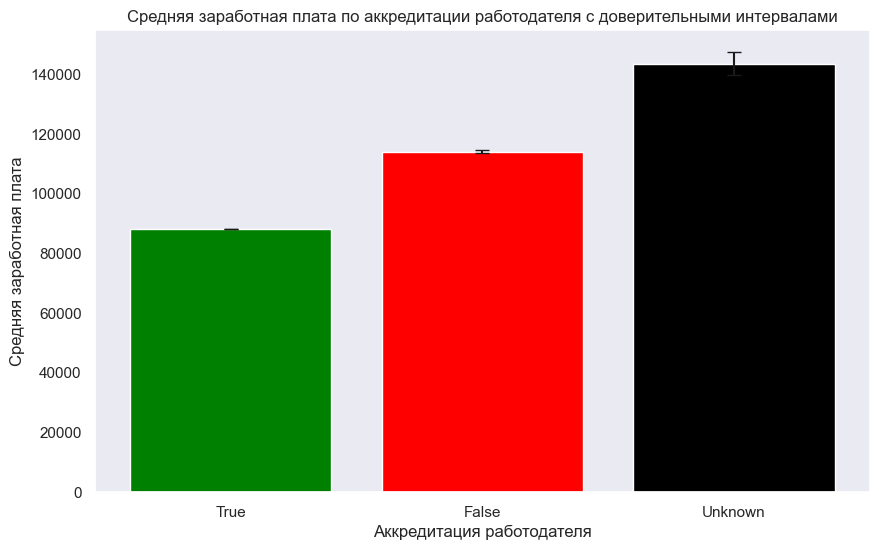

In [22]:
# Вычисляем средние значения и стандартные ошибки каждой группы
means = [
    np.mean(groupA),
    np.mean(groupB),
    np.mean(groupC)
]

std_errors = [
    stats.sem(groupA),
    stats.sem(groupB),
    stats.sem(groupC)
]

groups = ['True', 'False', 'Unknown']

plt.figure(figsize=(10, 6))
plt.bar(groups, means, yerr=std_errors, capsize=5, color=['green', 'red', 'black'])
plt.title('Средняя заработная плата по аккредитации работодателя с доверительными интервалами')
plt.xlabel('Аккредитация работодателя')
plt.ylabel('Средняя заработная плата')
plt.show()

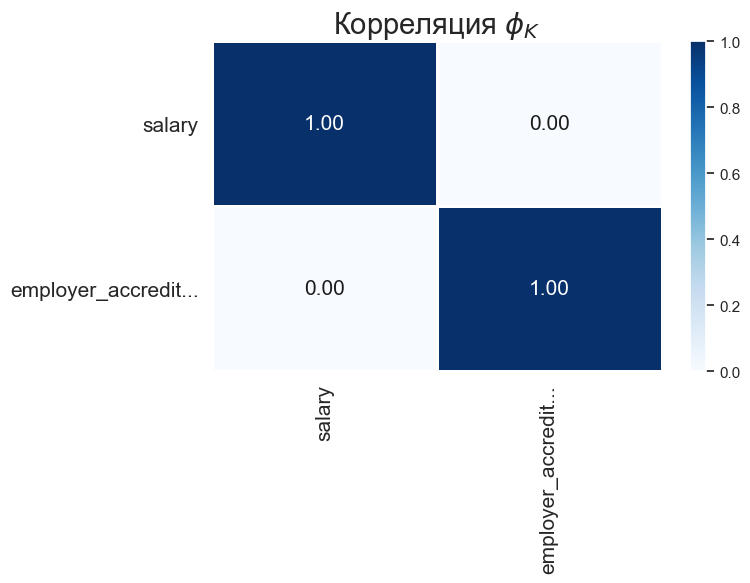

In [23]:
# Воспользуемся корреляцией Phik
binned_df = bin_data(df[['employer_accredited_it_employer', 'salary']].copy(), bins=100, cols=['salary'])

phik_overview = binned_df.phik_matrix(interval_cols=['salary'])
phik_overview.round(5)

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Blues",
                        title=r"Корреляция $\phi_K$",
                        fontsize_factor=1.5,
                        figsize=(8, 6))
plt.tight_layout()
plt.show()

Столбец employer_accredited_it_employer содержит в себе информацию об аккредитации компании. Object, можно перевести в int, чтобы понизить вес данных. В данных было 0.113% пропусков - заменили на константу Unknown. Большинство работодателей (~97%) не имею аккредитации, что влияет на медианную ЗП, которую платит работодатель:
-   С аккредитацией: медиана равна 96.242 рублей, 50% данных находится в диапазоне от ~60к до ~ 180к, максимальное значение усов доходит до ~360к. Есть выбросы;
-   Без аккредитации: медиана равна 70.000 рублей, 50% данных находится в диапазоне от ~50к до ~ 110к, максимальное значение усов доходит до ~200к. Есть выбросы;
-   Без уточения аккредитации: медиана равна 110.000 рублей, 50% данных находится в диапазоне от ~80к до ~ 160к, максимальное значение усов доходит до ~360к. Есть выбросы.

Тест Крускала-Уоллиса доказал, что есть статистически значимые различия между тремя группами, также доверительные интервалы средних значений различны. Зависимость через корреляцию Phik не была выявлена.

In [24]:
artem_columns = df.columns[61: 92]
artem_columns

Index(['snippet_requirement', 'snippet_responsibility', 'schedule_id',
       'schedule_name', 'accept_temporary', 'professional_roles_0_id',
       'professional_roles_0_name', 'accept_incomplete_resumes',
       'experience_id', 'experience_name', 'employment_id', 'employment_name',
       'is_adv_vacancy', 'address_metro_stations_3_station_name',
       'address_metro_stations_3_line_name',
       'address_metro_stations_3_station_id',
       'address_metro_stations_3_line_id', 'address_metro_stations_3_lat',
       'address_metro_stations_3_lng', 'working_time_intervals_0_id',
       'working_time_intervals_0_name', 'working_time_modes_0_id',
       'working_time_modes_0_name', 'working_days_0_id', 'working_days_0_name',
       'branding_type', 'branding_tariff', 'department_id', 'department_name',
       'insider_interview_id', 'insider_interview_url'],
      dtype='object')

##### Столбец schedule_id и schedule_name

In [25]:
df['schedule_id'].unique()

array(['fullDay', 'shift', 'remote', 'flexible', 'flyInFlyOut'],
      dtype=object)

In [26]:
df['schedule_name'].unique()

array(['Полный день', 'Сменный график', 'Удаленная работа',
       'Гибкий график', 'Вахтовый метод'], dtype=object)

In [27]:
df[['schedule_id', 'schedule_name']].head()

schedule_id     schedule_name
0     fullDay       Полный день
1       shift    Сменный график
2       shift    Сменный график
3      remote  Удаленная работа
4     fullDay       Полный день

Можем заметить, что данные столбцы несут в себе одну и ту же информацию - удалим один из них для избежания мультикорреляции, а также понизим масштаб данных.

In [28]:
del df['schedule_id']

In [29]:
nan_schedule_name = df['schedule_name'].isna().sum()
print(f'Колчиество NaN объектов: {nan_schedule_name}')

Колчиество NaN объектов: 0


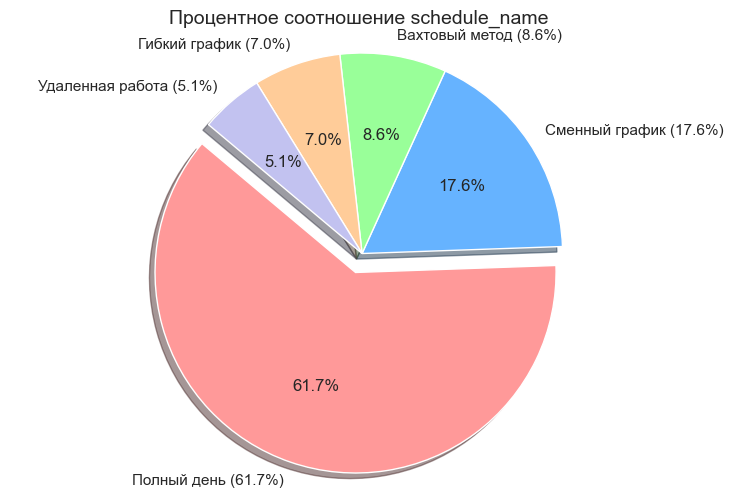

In [30]:
count_series = df['schedule_name'].value_counts()
percentage = count_series / count_series.sum() * 100
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#c2c2f0', '#ffb3e6']
explode = (0.1, 0, 0, 0, 0)

# Переименуем индекс для лучшего отображения на графике
percentage.index = [f'{i} ({p:.1f}%)' for i, p in zip(percentage.index, percentage)]

plt.figure(figsize=(9, 6))
plt.pie(percentage, labels=percentage.index, colors=colors, autopct='%1.1f%%', startangle=140, 
        explode=explode, shadow=True)
plt.title('Процентное соотношение schedule_name', fontsize=14)
plt.axis('equal') 
plt.show()

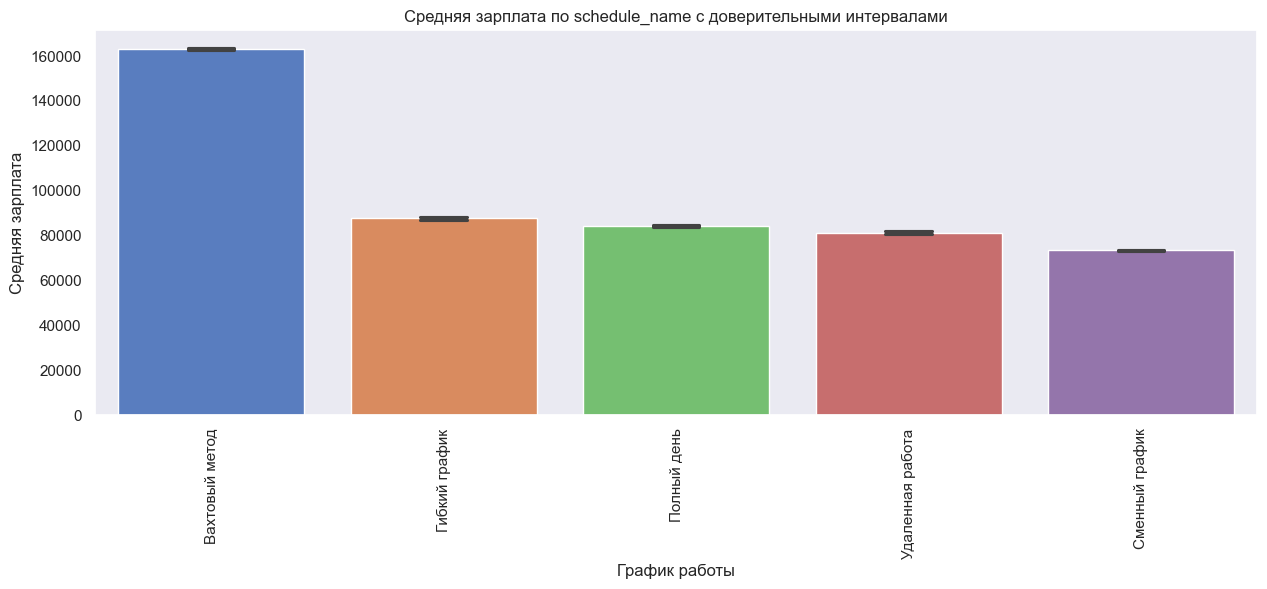

In [31]:
mean_salaries = df.groupby('schedule_name')['salary'].mean().sort_values(ascending=False)
sorted_categories = mean_salaries.index

plt.figure(figsize=(15, 5))
ax = sns.barplot(x='schedule_name', y='salary', data=df, order=sorted_categories, ci=95, palette='muted', capsize=.2)

plt.title(f'Средняя зарплата по schedule_name с доверительными интервалами')
plt.xlabel('График работы')
plt.ylabel('Средняя зарплата')
plt.xticks(rotation=90)
plt.show()

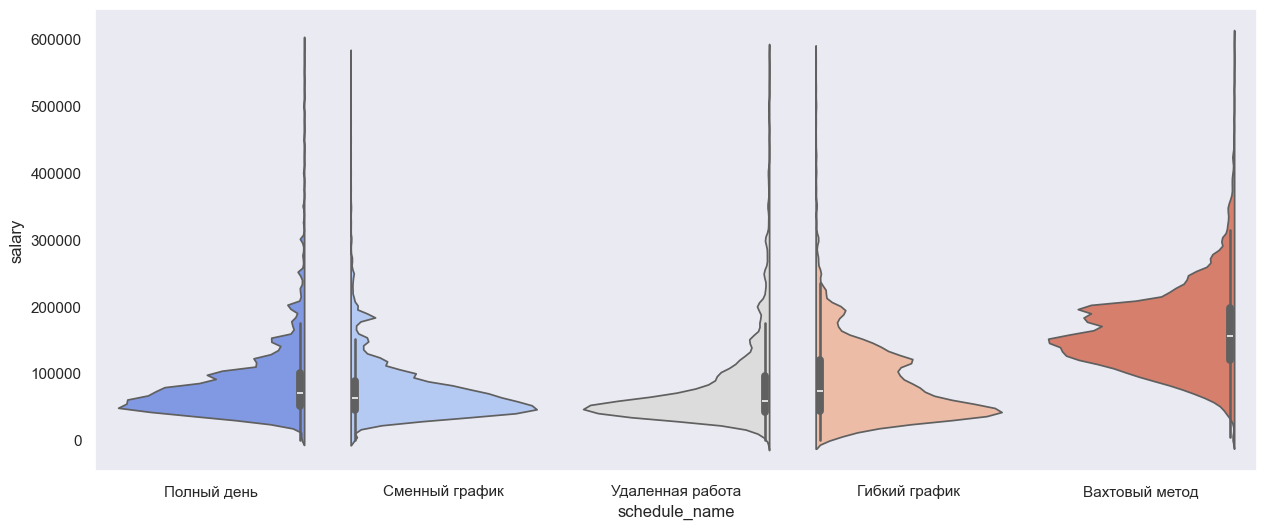

In [32]:
plt.figure(figsize = (15, 6))
sns.violinplot(
    x = filtered_df['schedule_name'],
    y = filtered_df['salary'],
    split = True,
    palette = "coolwarm"
)
plt.show()

In [33]:
filtered_df['schedule_name'].unique()

array(['Полный день', 'Сменный график', 'Удаленная работа',
       'Гибкий график', 'Вахтовый метод'], dtype=object)

In [34]:
name = 'Вахтовый метод'

print(df.loc[df['schedule_name'] == name, 'salary'].median())
print(df.loc[df['schedule_name'] == name, 'salary'].quantile(0.25))
print(df.loc[df['schedule_name'] == name, 'salary'].quantile(0.75))

155000.0
120000.0
197500.0


Был удалён столбец schedule_id, тк он полностью повторяет стоббец schedule_name - название графика рабочего дня. Пропусков и анамалий в данных нет, всего у нас 5 уникальных объектов:

1. **Полный день**. Самый частый график, который предлагает работодатель - 61,7%. При этом занимает 3 место по ЗП: медианное значение состовляет 70.000 рублей, 50% данных лежит в пределах 50к - 100к, max значение по усам достигает ~180к.
2. **Сменный график**. 17.6% от всех графиков. Последнее место по ЗП: медианное значение состовляет 62.010 рублей, 50% данных лежит в пределах 45.000 - 87.500, max значение по усам достигает ~140к.
3. **Удаленная работа**. Самый редкий график рабочего дня, который предлагает работодатель - 5.1%. Занимает 4 место по ЗП: медианное значение состовляет 58.500 рублей, 50% данных лежит в пределах 42.250 - 95.000, max значение по усам достигает ~160к.
4. **Гибкий график**. 7% от общего объёма вакансий. Занимает 2 место по ЗП: медианное значение состовляет 72.600 рублей, 50% данных лежит в пределах 43.400 - 120000, max значение по усам достигает ~240к.
5. **Вахтовый метод**. 8.6%. Очевидно 1 место по ЗП: медианное значение состовляет 155.000 рублей, 50% данных лежит в пределах 120.000 - 197.500, max значение по усам достигает ~320к.

##### Столбец accept_temporary

In [35]:
df['accept_temporary'].unique()

array([False,  True])

In [36]:
df['accept_temporary'].info()

<class 'pandas.core.series.Series'>
Index: 709524 entries, 0 to 709571
Series name: accept_temporary
Non-Null Count   Dtype
--------------   -----
709524 non-null  bool 
dtypes: bool(1)
memory usage: 6.1 MB


In [37]:
nan_accept_temporary = df['accept_temporary'].isna().sum()
print(f'Колчиество NaN объектов: {nan_accept_temporary}')

Колчиество NaN объектов: 0


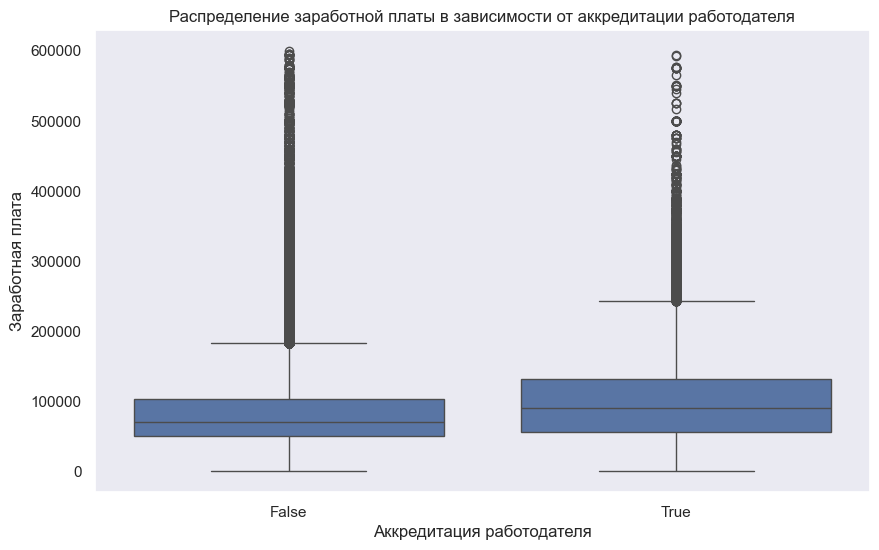

In [38]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='accept_temporary', y='salary', data=filtered_df)
plt.title('Распределение заработной платы в зависимости от аккредитации работодателя')
plt.xlabel('Аккредитация работодателя')
plt.ylabel('Заработная плата')
plt.show()

Столбец accept_temporary может означать:

- true: Соискатель готов принимать вакансии на временной основе (контрактные, краткосрочные проекты и т.д.).
- false: Соискатель заинтересован только в постоянных рабочих местах, и временные позиции его не устраивают.

При этом нет особой разницы в при разных значениях, разве что True немного превышет ЗП ожидания.

##### Столбец professional_roles_0_id и professional_roles_0_name

In [39]:
df['professional_roles_0_id'].unique()

array([ 70,  40,  48, 129, 131,  21,  55,   8,  39,  88,  85,  47,  74,
        64,   5,  94, 142,  33, 128, 130,  18,  97, 170,  24,  59, 109,
       119, 143, 146,  62, 102,  58,  35,  76, 132, 127, 104, 107,  86,
       148, 144,  99,  82,  96,  89,  45,  31, 111, 162,  57,  34,  92,
        81, 136,  10, 110,  73,  69, 113, 123, 118, 145,   9,  23,  66,
        27,  52,  67,  30,  71, 139,  28,  60,  95,  68, 115, 116, 121,
        78, 141,  32,  46,  17, 100,  61, 124,  91, 169,  84,  38,   1,
         7, 137, 133, 134,   6, 114,  19, 101,  83,  77,  72, 106, 120,
       152,  49,   3,  54, 163,  90,  20,  51,  16, 149, 135,  15, 117,
        26,  44, 125,  53, 138,  14,  63, 108,  50, 154, 159,   2, 140,
        80,  79, 174,  87, 166, 173, 105,  13, 150, 167, 153,  42, 165,
       151,  93,  36,  12, 103, 156, 158, 168,  98,  65, 160,  41, 122,
       112,   4,  56, 164,  37, 155, 161,  11, 172,  75, 171,  22,  29,
       126, 157, 147,  25,  43], dtype=int64)

In [40]:
df['professional_roles_0_name'].unique()

array(['Менеджер по продажам, менеджер по работе с клиентами', 'Другое',
       'Инженер-конструктор, инженер-проектировщик',
       'Торговый представитель', 'Упаковщик, комплектовщик', 'Водитель',
       'Копирайтер, редактор, корректор', 'Администратор', 'Диспетчер',
       'Офис-менеджер', 'Оператор производственной линии',
       'Инженер ПТО, инженер-сметчик', 'Менеджер ресторана',
       'Медицинская сестра, медицинский брат', 'Автослесарь, автомеханик',
       'Повар, пекарь, кондитер', 'Экономист',
       'Делопроизводитель, архивариус', 'Токарь, фрезеровщик, шлифовщик',
       'Уборщица, уборщик', 'Бухгалтер',
       'Продавец-консультант, продавец-кассир',
       'Руководитель отдела маркетинга и рекламы', 'Врач',
       'Маляр, штукатур', 'Сварщик', 'Специалист по тендерам',
       'Электромонтажник', 'Юрист', 'Мастер-приемщик', 'Разнорабочий',
       'Курьер', 'Директор магазина, директор сети магазинов',
       'Менеджер/руководитель АХО', 'Учитель, преподаватель, педагог

In [41]:
del df['professional_roles_0_id']

In [42]:
nan_professional_roles = df['professional_roles_0_name'].isna().sum()
print(f'Колчиество NaN объектов: {nan_professional_roles}')

Колчиество NaN объектов: 0


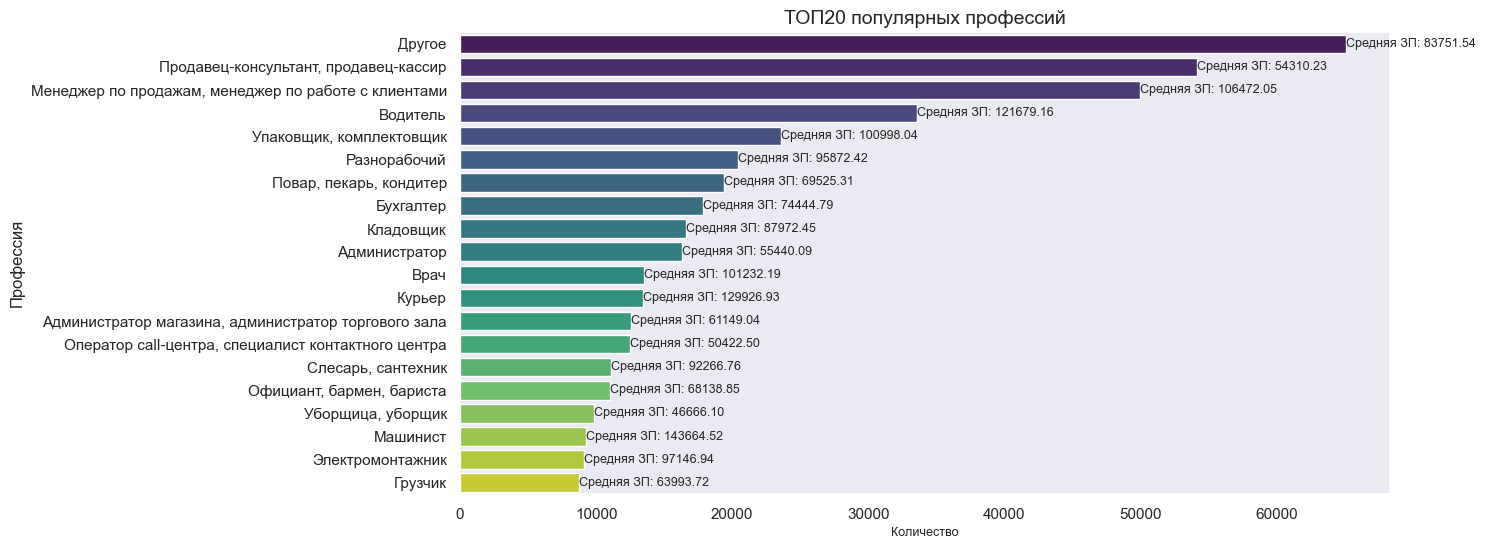

In [43]:
role_counts = df['professional_roles_0_name'].value_counts()

top_roles = role_counts.index
mean_salaries = df[df['professional_roles_0_name'].isin(top_roles[:20])].groupby('professional_roles_0_name')['salary'].mean()

role_counts = role_counts[:20]

plt.figure(figsize=(12, 6))
barplot = sns.barplot(x=role_counts.values, y=role_counts.index, palette='viridis')

for index, value in enumerate(role_counts.index):
    mean_salary = mean_salaries[value]
    barplot.text(role_counts.values[index], index, f'Средняя ЗП: {mean_salary:.2f}', va='center', ha='left', fontsize=9)

plt.title('ТОП20 популярных профессий', fontsize=14)
plt.xlabel('Количество', fontsize=9)
plt.ylabel('Профессия')
plt.show()

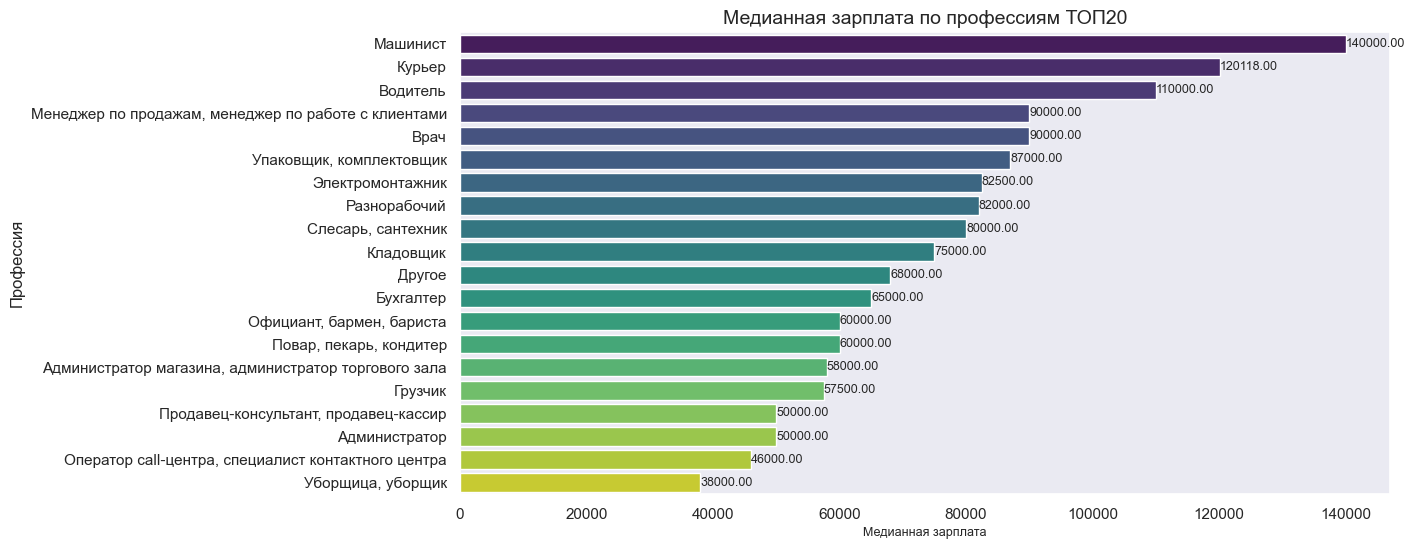

In [44]:
mean_salaries = df[df['professional_roles_0_name'].isin(top_roles[:20])].groupby('professional_roles_0_name')['salary'].median()
sorted_roles_by_salary = mean_salaries.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
barplot = sns.barplot(x=sorted_roles_by_salary.values, y=sorted_roles_by_salary.index, palette='viridis')

for index, value in enumerate(sorted_roles_by_salary.index):
    mean_salary = sorted_roles_by_salary[value]
    barplot.text(sorted_roles_by_salary.values[index], index, f'{mean_salary:.2f}', va='center', ha='left', fontsize=9)

plt.title('Медианная зарплата по профессиям ТОП20', fontsize=14)
plt.xlabel('Медианная зарплата', fontsize=9)
plt.ylabel('Профессия')
plt.show()

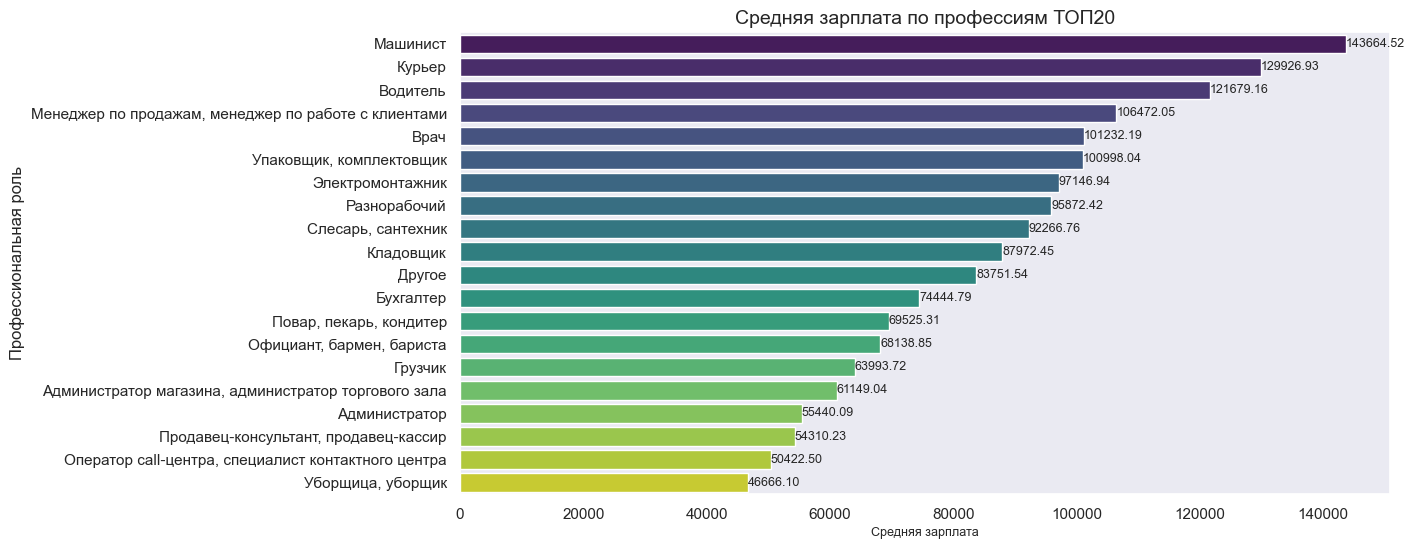

In [45]:
mean_salaries = df[df['professional_roles_0_name'].isin(top_roles[:20])].groupby('professional_roles_0_name')['salary'].mean()
sorted_roles_by_salary = mean_salaries.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
barplot = sns.barplot(x=sorted_roles_by_salary.values, y=sorted_roles_by_salary.index, palette='viridis')

for index, value in enumerate(sorted_roles_by_salary.index):
    mean_salary = sorted_roles_by_salary[value]
    barplot.text(sorted_roles_by_salary.values[index], index, f'{mean_salary:.2f}', va='center', ha='left', fontsize=9)

plt.title('Средняя зарплата по профессиям ТОП20', fontsize=14)
plt.xlabel('Средняя зарплата', fontsize=9)
plt.ylabel('Профессиональная роль')
plt.show()

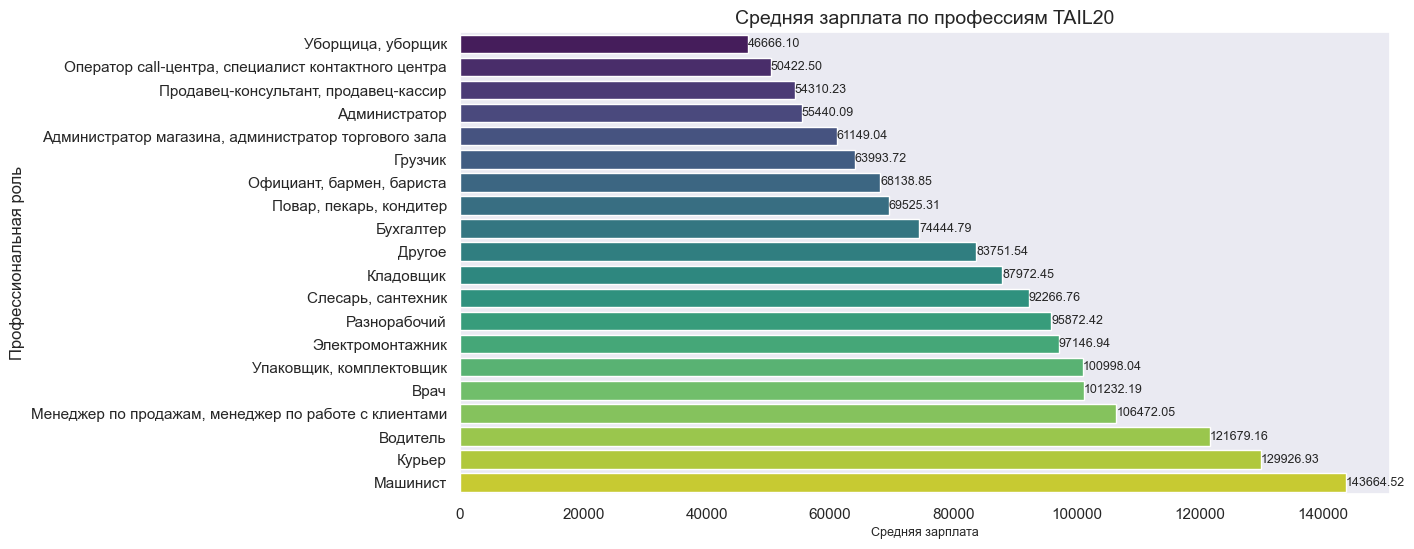

In [46]:
mean_salaries = df[df['professional_roles_0_name'].isin(top_roles[:20])].groupby('professional_roles_0_name')['salary'].mean()
sorted_roles_by_salary = mean_salaries.sort_values(ascending=True)

plt.figure(figsize=(12, 6))
barplot = sns.barplot(x=sorted_roles_by_salary.values, y=sorted_roles_by_salary.index, palette='viridis')

for index, value in enumerate(sorted_roles_by_salary.index):
    mean_salary = sorted_roles_by_salary[value]
    barplot.text(sorted_roles_by_salary.values[index], index, f'{mean_salary:.2f}', va='center', ha='left', fontsize=9)

plt.title('Средняя зарплата по профессиям TAIL20', fontsize=14)
plt.xlabel('Средняя зарплата', fontsize=9)
plt.ylabel('Профессиональная роль')
plt.show()

In [47]:
salary_groups = [group['salary'].values for _, group in df.groupby('professional_roles_0_name')]
statistic, p_value = kruskal(*salary_groups)

print(f'Статистика Краскела-Уоллиса: {statistic}')
print(f'P-value: {p_value}')

if p_value < 0.05:
    print('Существует статистически значимая зависимость между профессией и зарплатой')
else:
    print('Нет статистически значимой зависимости между профессиейи зарплатой')

Статистика Краскела-Уоллиса: 200428.42091922715
P-value: 0.0
Существует статистически значимая зависимость между профессией и зарплатой


Скоро будет вывод

##### Столбец accept_incomplete_resumes

In [48]:
df['accept_incomplete_resumes'].unique()

array([ True, False])

In [50]:
df['accept_incomplete_resumes'].info()

<class 'pandas.core.series.Series'>
Index: 709524 entries, 0 to 709571
Series name: accept_incomplete_resumes
Non-Null Count   Dtype
--------------   -----
709524 non-null  bool 
dtypes: bool(1)
memory usage: 6.1 MB


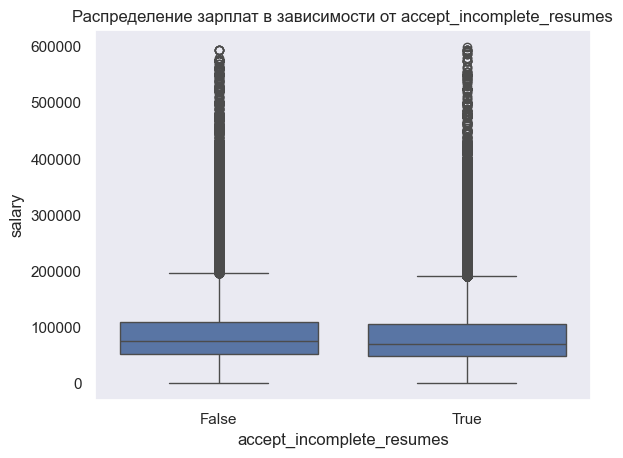

T-тест: статистика = 27.36125097251216, p-значение = 9.670966409659682e-165
Отклоняем нулевую гипотезу: Средние значения зарплат отличаются.


In [54]:
sns.boxplot(x='accept_incomplete_resumes', y='salary', data=filtered_df)
plt.title('Распределение зарплат в зависимости от accept_incomplete_resumes')
plt.show()

group1 = df[df['accept_incomplete_resumes'] == 0]['salary']
group2 = df[df['accept_incomplete_resumes'] == 1]['salary']
t_stat, t_p_value = ttest_ind(group1, group2)
print(f"T-тест: статистика = {t_stat}, p-значение = {t_p_value}")

alpha = 0.05
if t_p_value < alpha:
    print("Отклоняем нулевую гипотезу: Средние значения зарплат отличаются.")
else:
    print("Не имеем оснований отклонить нулевую гипотезу: Средние значения зарплат равны.")

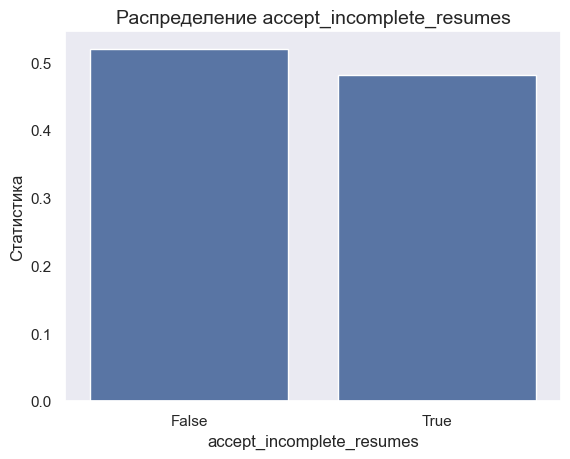

In [53]:
ax = sns.barplot(
    x=df['accept_incomplete_resumes'].value_counts(normalize=True).index,
    y=df['accept_incomplete_resumes'].value_counts(normalize=True),
)
plt.title('Распределение accept_incomplete_resumes', fontsize=14)
plt.xlabel('accept_incomplete_resumes')
plt.ylabel('Статистика')

plt.show()

##### Столбец experience_id и experience_name

In [56]:
df['experience_name'].unique()

array(['От 1 года до 3 лет', 'Нет опыта', 'От 3 до 6 лет', 'Более 6 лет'],
      dtype=object)

In [57]:
df['experience_id'].unique()

array(['between1And3', 'noExperience', 'between3And6', 'moreThan6'],
      dtype=object)

In [58]:
df[['experience_id', 'experience_name']].head(8)

experience_id     experience_name
0  between1And3  От 1 года до 3 лет
1  noExperience           Нет опыта
2  noExperience           Нет опыта
3  between1And3  От 1 года до 3 лет
4  between3And6       От 3 до 6 лет
5  between3And6       От 3 до 6 лет
6  noExperience           Нет опыта
7  noExperience           Нет опыта

In [59]:
del df['experience_id']

In [60]:
df['experience_name'].info()

<class 'pandas.core.series.Series'>
Index: 709524 entries, 0 to 709571
Series name: experience_name
Non-Null Count   Dtype 
--------------   ----- 
709524 non-null  object
dtypes: object(1)
memory usage: 10.8+ MB


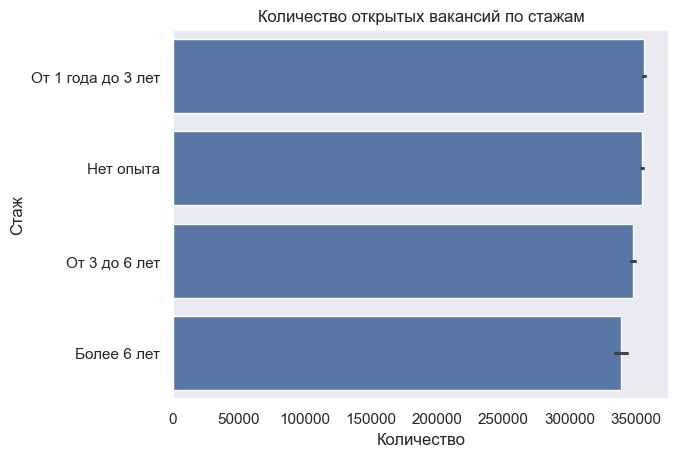

In [65]:
sns.barplot(y = df['experience_name'].index,
            x = df['experience_name'])
plt.title('Количество открытых вакансий по стажам')
plt.xlabel('Количество')
plt.ylabel('Стаж')
plt.show()

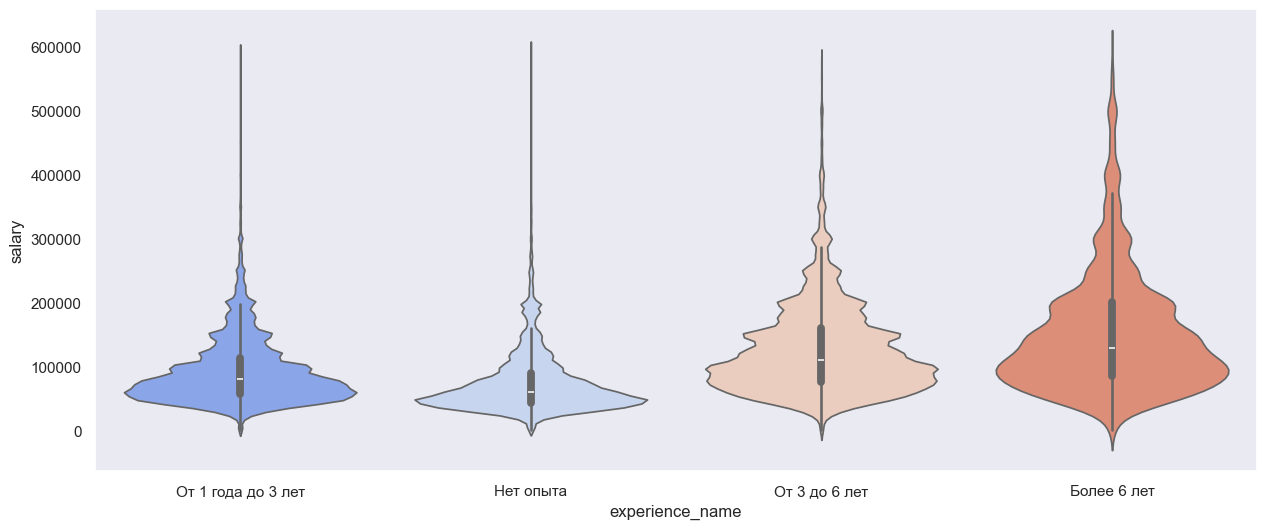

In [61]:
plt.figure(figsize = (15, 6))
sns.violinplot(
    x = filtered_df['experience_name'],
    y = filtered_df['salary'],
    split = False,
    palette = "coolwarm"
)
plt.show()

In [62]:
salary_groups = [group['salary'].values for _, group in df.groupby('experience_name')]
statistic, p_value = kruskal(*salary_groups)

print(f'Статистика Краскела-Уоллиса: {statistic}')
print(f'P-value: {p_value}')

if p_value < 0.05:
    print('Существует статистически значимая зависимость между стажем и зарплатой')
else:
    print('Нет статистически значимой зависимости между стажем и зарплатой')

Статистика Краскела-Уоллиса: 75507.47895808
P-value: 0.0
Существует статистически значимая зависимость между стажем и зарплатой


##### Столбец employment_id и employment_name

In [66]:
df['employment_id'].unique()

array(['full', 'part', 'project', 'probation', 'volunteer'], dtype=object)

In [67]:
df['employment_name'].unique()

array(['Полная занятость', 'Частичная занятость', 'Проектная работа',
       'Стажировка', 'Волонтерство'], dtype=object)

In [72]:
df[['employment_id', 'employment_name']].sample(10)

employment_id      employment_name
31544           full     Полная занятость
431411          full     Полная занятость
172863          full     Полная занятость
252147          full     Полная занятость
66978           full     Полная занятость
631828          full     Полная занятость
631806          part  Частичная занятость
601201          full     Полная занятость
210168          full     Полная занятость
357443          full     Полная занятость

In [74]:
del df['employment_id']

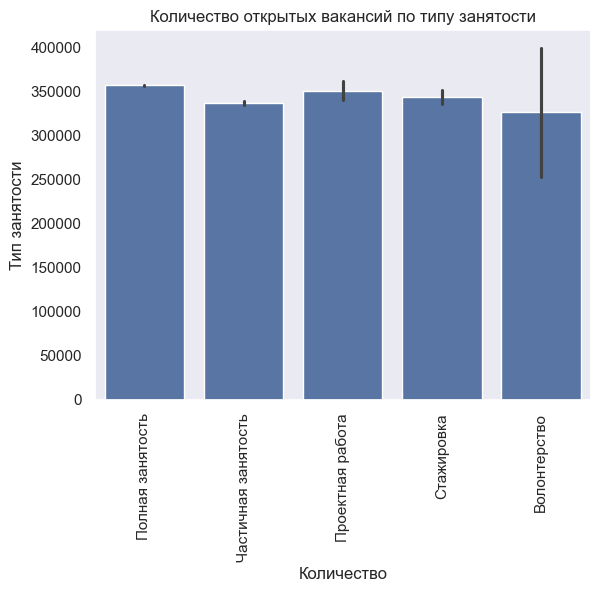

In [78]:
sns.barplot(y = df['employment_name'].index,
            x = df['employment_name'])
plt.title('Количество открытых вакансий по типу занятости')
plt.xlabel('Количество')
plt.xticks(rotation=90)
plt.ylabel('Тип занятости')
plt.show()

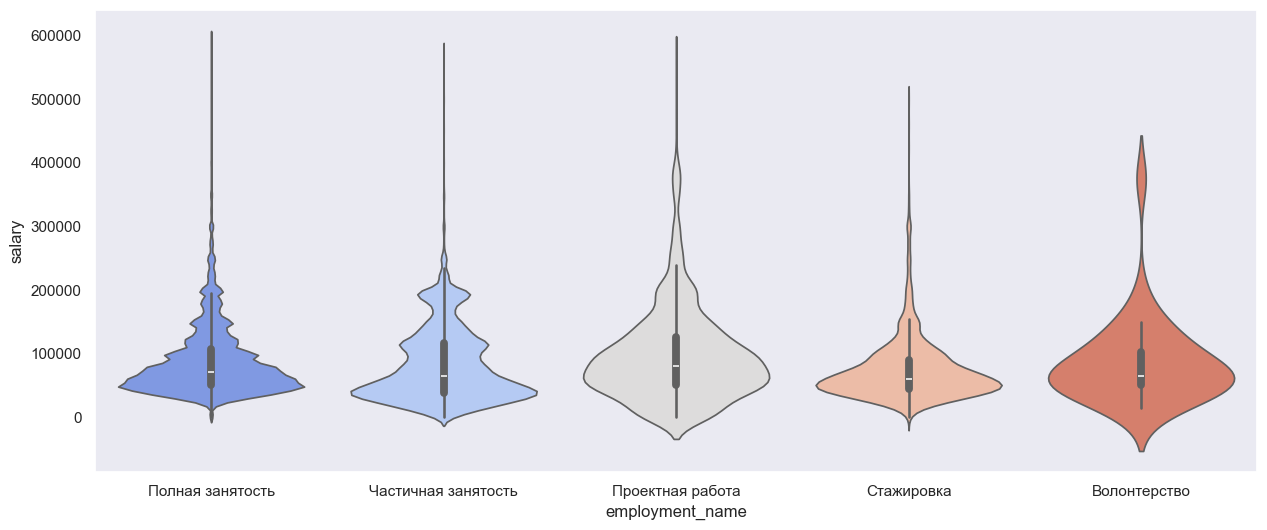

In [79]:
plt.figure(figsize = (15, 6))
sns.violinplot(
    x = filtered_df['employment_name'],
    y = filtered_df['salary'],
    split = False,
    palette = "coolwarm"
)
plt.show()

##### Столбец is_adv_vacancy

In [82]:
df['is_adv_vacancy'].unique()

array([False])

In [83]:
del df['is_adv_vacancy']

##### Столбец address_metro_stations_3_station_name и address_metro_stations_3_station_id

In [84]:
df['address_metro_stations_3_station_name'].unique()

array([nan, 'Москва-Сити', 'Ховрино', 'Тимирязевская', 'Ухтомская',
       'Электрозаводская', 'Селигерская', 'Фонвизинская', 'Речной вокзал',
       'Шоссе Энтузиастов', 'Петровско-Разумовская', 'Рязанский проспект',
       'Стахановская', 'Удельная', 'Юго-Восточная', 'Лихоборы',
       'Останкино', 'Лефортово', 'Новокосино', 'Перово',
       'Улица Дмитриевского', 'Чкаловская', 'Черкизовская',
       'Улица Горчакова', 'Чеховская', 'Красносельская', 'Театральная',
       'Площадь трёх вокзалов', 'Юго-Западная', 'Боровицкая',
       'Площадь Революции', 'Смоленская', 'Фрунзенская', 'Спортивная',
       'Киевская', 'Парк культуры', 'Первомайская', 'Сокольники',
       'Шелепиха', 'Преображенская площадь', 'Семеновская', 'Университет',
       'Серпуховская', 'Белорусская', 'Третьяковская', 'ЗИЛ', 'ЦСКА',
       'Марьино', 'Царицыно', 'Стрешнево', 'Красный Балтиец',
       'Новослободская', 'Дубровка', 'Петровский парк', 'Савёловская',
       'Сокол', 'Тверская', 'Каширская', 'Тушинская'

In [85]:
df['address_metro_stations_3_station_id'].unique()

array([    nan,   4.179,   2.558,   9.141, 135.862,  98.802,  10.597,
        10.547,   2.125,  95.524,  10.548,   7.127,   3.161,  98.764,
       135.849, 135.868,  98.762, 135.848, 135.85 ,  98.8  ,   8.189,
        97.803,   8.107,  98.676,  95.545, 135.857,  10.72 ,   1.155,
        12.168,   9.123,   1.6  ,   2.99 , 136.89 ,   1.162,   9.7  ,
         3.1  ,   3.131,   1.152,   1.135,   4.132,   5.49 ,   1.103,
         3.106,   1.134,  97.602,   1.117,   3.13 ,   1.149,   9.37 ,
       136.894,   8.91 ,  95.531,  97.6  ,  10.79 , 132.735, 132.72 ,
       132.721,   5.82 ,  95.529,  97.599, 131.699,   9.128,  95.542,
         2.133,   2.122,  97.832, 132.718,   2.96 ,  10.188, 131.704,
         3.463,   3.176,  95.523, 131.706,   3.174, 131.705, 131.703,
         4.151,   3.159,   7.146, 131.702, 135.852, 135.847,  10.113,
       135.845, 135.853, 135.864, 132.727,  96.552, 135.858,   1.143,
         9.154,   6.137,   1.64 , 132.724,   6.121,   9.163,   7.62 ,
         9.142,   5.

In [86]:
del df['address_metro_stations_3_station_id']

In [90]:
nan_address_metro_stations = df['address_metro_stations_3_station_name'].isna().sum()
print(f'Колчиество NaN объектов: {nan_address_metro_stations}')

Колчиество NaN объектов: 0


In [89]:
df['address_metro_stations_3_station_name'].fillna('Missing', inplace=True)

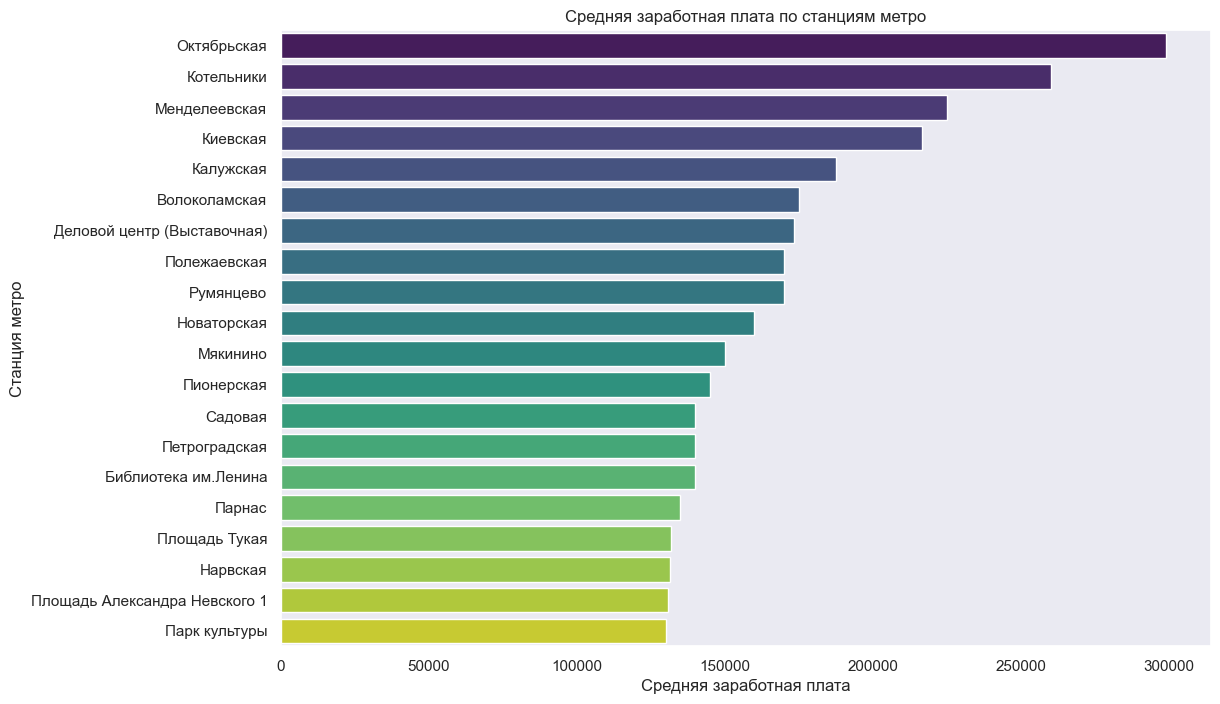

In [104]:
# Группировка данных по станциям метро и расчет средней заработной платы для каждой станции
station_salary = df.groupby('address_metro_stations_3_station_name')['salary'].median().reset_index().sort_values(by='salary', ascending=False)[:20]

# Построение barplot
plt.figure(figsize=(12, 8))
sns.barplot(data=station_salary, x='salary', y='address_metro_stations_3_station_name', palette='viridis')
plt.xlabel('Средняя заработная плата')
plt.ylabel('Станция метро')
plt.title('Средняя заработная плата по станциям метро ТОП')
plt.show()

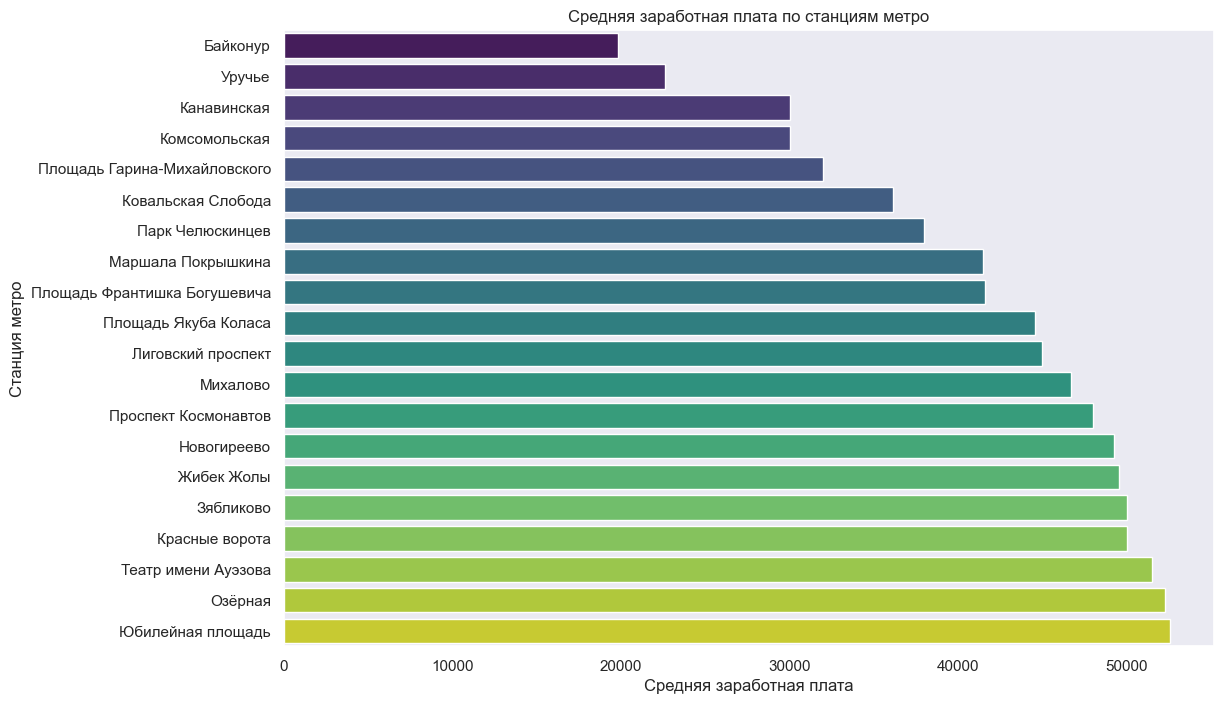

In [105]:
station_salary = df.groupby('address_metro_stations_3_station_name')['salary'].median().reset_index().sort_values(by='salary', ascending=True)[:20]

plt.figure(figsize=(12, 8))
sns.barplot(data=station_salary, x='salary', y='address_metro_stations_3_station_name', palette='viridis')
plt.xlabel('Средняя заработная плата')
plt.ylabel('Станция метро')
plt.title('Средняя заработная плата по станциям метро')
plt.show()

In [106]:
salary_groups = [group['salary'].values for _, group in df.groupby('address_metro_stations_3_station_name')]
statistic, p_value = kruskal(*salary_groups)

print(f'Статистика Краскела-Уоллиса: {statistic}')
print(f'P-value: {p_value}')

if p_value < 0.05:
    print('Существует статистически значимая зависимость между метро и зарплатой')
else:
    print('Нет статистически значимой зависимости между метро и зарплатой')

Статистика Краскела-Уоллиса: 4223.593874605901
P-value: 0.0
Существует статистически значимая зависимость между метро и зарплатой


##### Столбец address_metro_stations_3_line_name и address_metro_stations_3_line_id

In [92]:
df['address_metro_stations_3_line_name'].unique()

array([nan, 'Филевская', 'Замоскворецкая', 'Серпуховско-Тимирязевская',
       'МЦД-3', 'Некрасовская', 'Люблинско-Дмитровская', 'МЦК',
       'Таганско-Краснопресненская', 'Арбатско-Покровская', 'Калининская',
       'Большая кольцевая линия', 'Сокольническая', 'Бутовская', 'МЦД-4',
       'Кольцевая', 'МЦД-2', 'МЦД-1', 'Монорельс', 'Калужско-Рижская',
       'Солнцевская', 'Троицкая', 'Каховская', 'Правобережная',
       'Кировско-Выборгская', 'Первая', 'Автозаводская', 'Центральная',
       'Фрунзенско-Приморская', 'Московско-Петроградская', 'Ленинская',
       'Зеленолужская', 'Дзержинская', 'Невско-Василеостровская',
       'Московская', 'Север-Юг', 'Сормовская'], dtype=object)

In [93]:
df['address_metro_stations_3_line_id'].unique()

array([ nan,   4.,   2.,   9., 135.,  98.,  10.,  95.,   7.,   3.,   8.,
        97.,   1.,  12., 136.,   5., 132., 131.,  96.,   6., 133., 137.,
        11.,  17.,  14.,  54.,  64.,  63.,  49.,  18.,  50.,  15.,  52.,
       134.,  53.,  16.,  62.,  48.,  51.])

In [94]:
del df['address_metro_stations_3_line_id']

In [97]:
nan_address_metro_stations = df['address_metro_stations_3_line_name'].isna().sum()
print(f'Колчиество NaN объектов: {nan_address_metro_stations}')

Колчиество NaN объектов: 0


In [96]:
df['address_metro_stations_3_line_name'].fillna('Missing', inplace=True)

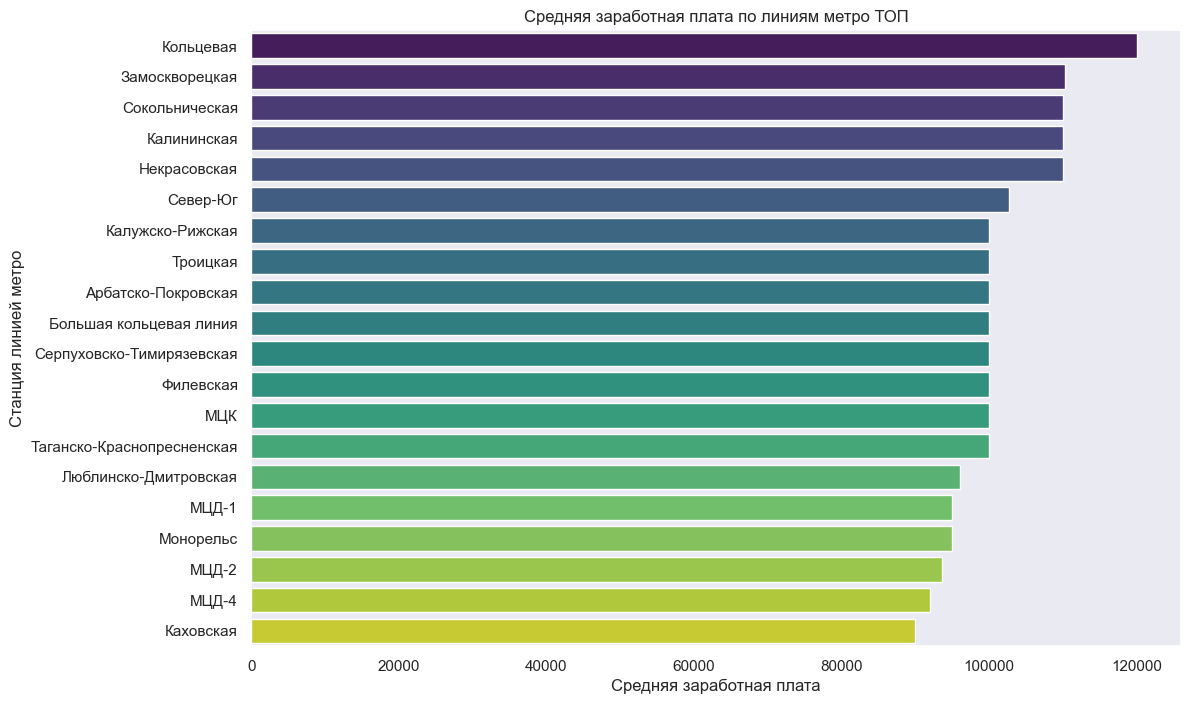

In [112]:
station_salary = df.groupby('address_metro_stations_3_line_name')['salary'].median().reset_index().sort_values(by='salary', ascending=False)[:20]

plt.figure(figsize=(12, 8))
sns.barplot(data=station_salary, x='salary', y='address_metro_stations_3_line_name', palette='viridis')
plt.xlabel('Средняя заработная плата')
plt.ylabel('Станция линией метро')
plt.title('Средняя заработная плата по линиям метро ТОП')
plt.show()

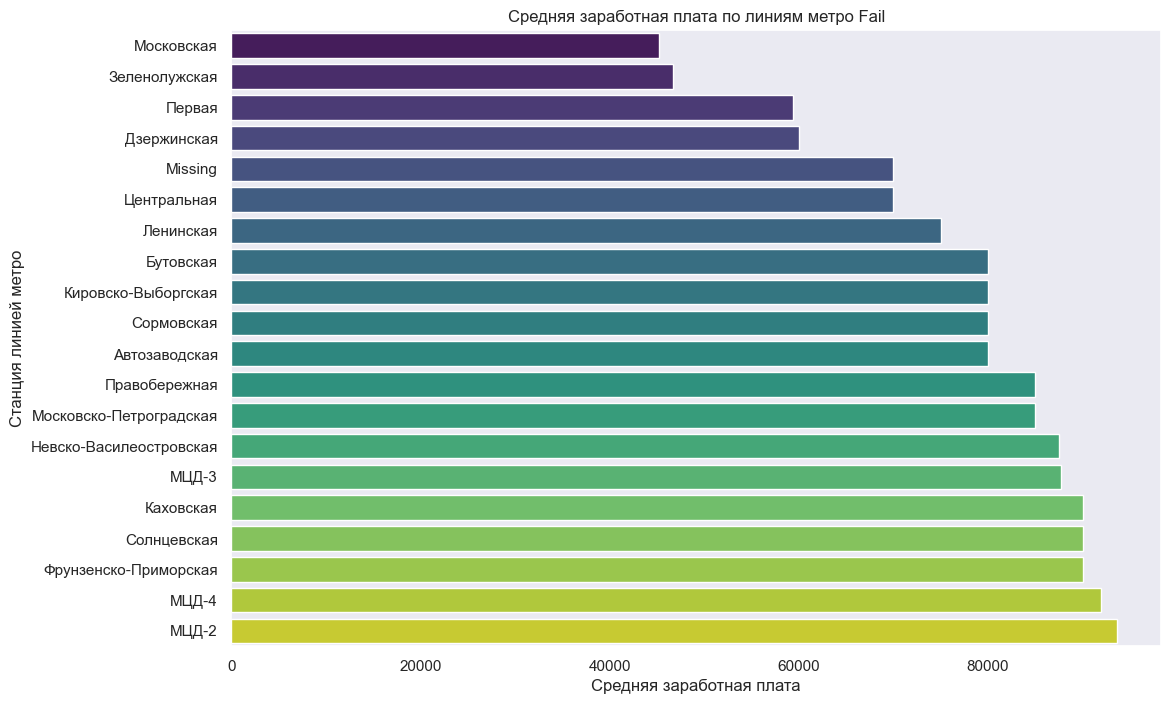

In [113]:
station_salary = df.groupby('address_metro_stations_3_line_name')['salary'].median().reset_index().sort_values(by='salary', ascending=True)[:20]

plt.figure(figsize=(12, 8))
sns.barplot(data=station_salary, x='salary', y='address_metro_stations_3_line_name', palette='viridis')
plt.xlabel('Средняя заработная плата')
plt.ylabel('Станция линией метро')
plt.title('Средняя заработная плата по линиям метро Fail')
plt.show()

In [115]:
salary_groups = [group['salary'].values for _, group in df.groupby('address_metro_stations_3_line_name')]
statistic, p_value = kruskal(*salary_groups)

print(f'Статистика Краскела-Уоллиса: {statistic}')
print(f'P-value: {p_value}')

if p_value < 0.05:
    print('Существует статистически значимая зависимость между линией метро и зарплатой')
else:
    print('Нет статистически значимой зависимости между линией метро и зарплатой')

Статистика Краскела-Уоллиса: 3716.1941771286283
P-value: 0.0
Существует статистически значимая зависимость между линией метро и зарплатой


##### Столбец address_metro_stations_3_lat и address_metro_stations_3_lng

In [116]:
df['address_metro_stations_3_lng'].nunique()

350

In [117]:
df['address_metro_stations_3_lat'].nunique()

346

In [ ]:
df[['address_metro_stations_3_lng', 'address_metro_stations_3_lat', 'salary']].corr()['salary']

In [ ]:
data = df[['address_metro_stations_3_lat', 'address_metro_stations_3_lng', 'salary']].copy()
city_center = (55.7558, 37.6173)
data['distance_to_center'] = df.apply(lambda row: distance((row['address_metro_stations_3_lat'], row['address_metro_stations_3_lng']), city_center).km, axis=1)

In [ ]:
plt.figure(figsize=(10, 8))

hb = plt.hexbin(df['address_metro_stations_3_lng'], df['address_metro_stations_3_lat'], C=df['salary'], gridsize=200, cmap='coolwarm', reduce_C_function=np.mean)
cb = plt.colorbar(hb, label='Средняя зарплата')

plt.title('Тепловая карта заработной платы')
plt.xlabel('Долгота (lng)')
plt.ylabel('Широта (lat)')

plt.show()

In [138]:
nan_address_metro_stations_lat = df['address_metro_stations_3_lat'].isna().sum()
nan_address_metro_stations_lng = df['address_metro_stations_3_lng'].isna().sum()
print(f'Колчиество NaN объектов: {nan_address_metro_stations_lat}')
print(f'Колчиество NaN объектов: {nan_address_metro_stations_lng}')

Колчиество NaN объектов: 0
Колчиество NaN объектов: 0


In [137]:
df['address_metro_stations_3_lat'].fillna(-999, inplace=True)
df['address_metro_stations_3_lng'].fillna(-999, inplace=True)

##### Столбец working_time_intervals_0_id и working_time_intervals_0_name

In [144]:
df['working_time_intervals_0_id'].unique()

array([nan, 'from_four_to_six_hours_in_a_day'], dtype=object)

In [148]:
df['working_time_intervals_0_name'].unique()

array([nan, 'Можно сменами по 4-6 часов в день'], dtype=object)

In [147]:
df['working_time_intervals_0_name'] = df['working_time_intervals_0_name'].replace('Можно сменами по\xa04-6\xa0часов в\xa0день', 'Можно сменами по 4-6 часов в день')

In [150]:
del df['working_time_intervals_0_id']

In [146]:
nan_working_time_intervals = df['working_time_intervals_0_name'].isna().sum()
print(f'Колчиество NaN объектов: {nan_working_time_intervals}')

Колчиество NaN объектов: 653043


In [152]:
df['working_time_intervals_0_name'].fillna('Unknown', inplace=True)

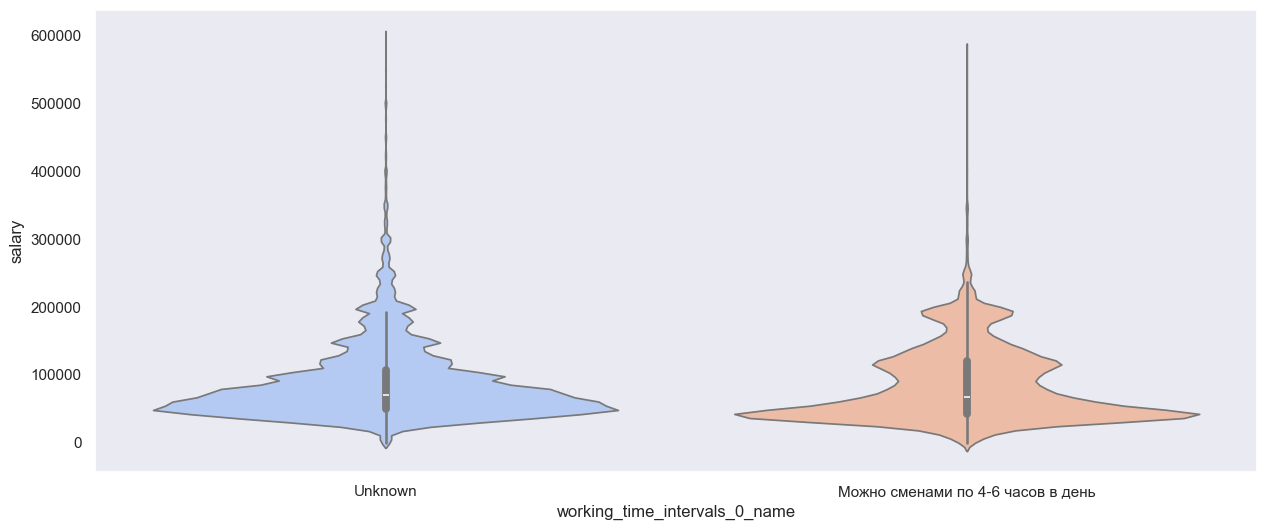

In [155]:
plt.figure(figsize = (15, 6))
sns.violinplot(
    x = df[df['salary'] < percentile_99]['working_time_intervals_0_name'],
    y = df[df['salary'] < percentile_99]['salary'],
    split = False,
    palette = "coolwarm"
)
plt.show()

In [168]:
group1 = df[df['working_time_intervals_0_name'] == 'Unknown']['salary']
group2 = df[df['working_time_intervals_0_name'] == 'Можно сменами по 4-6 часов в день']['salary']
t_stat, t_p_value = ttest_ind(group1, group2)
print(f"T-тест: статистика = {t_stat}, p-значение = {t_p_value}")

alpha = 0.05
if t_p_value < alpha:
    print("Отклоняем нулевую гипотезу: Средние значения зарплат отличаются.")
else:
    print("Не имеем оснований отклонить нулевую гипотезу: Средние значения зарплат равны.")

T-тест: статистика = 9.211563063560119, p-значение = 3.222455295762907e-20
Отклоняем нулевую гипотезу: Средние значения зарплат отличаются.


##### Столбец working_time_modes_0_id и working_time_modes_0_name

In [157]:
df['working_time_modes_0_id'].unique()

array([nan, 'start_after_sixteen'], dtype=object)

In [158]:
df['working_time_modes_0_name'].unique()

array([nan, 'С\xa0началом дня после 16:00'], dtype=object)

In [159]:
df['working_time_modes_0_name'] = df['working_time_modes_0_name'].replace('С\xa0началом дня после 16:00', 'С началом дня после 16:00')

In [160]:
del df['working_time_modes_0_id']

In [161]:
nan_working_time_modes = df['working_time_modes_0_name'].isna().sum()
print(f'Колчиество NaN объектов: {nan_working_time_modes}')

Колчиество NaN объектов: 663439


In [162]:
df['working_time_modes_0_name'].fillna('Unknown', inplace=True)

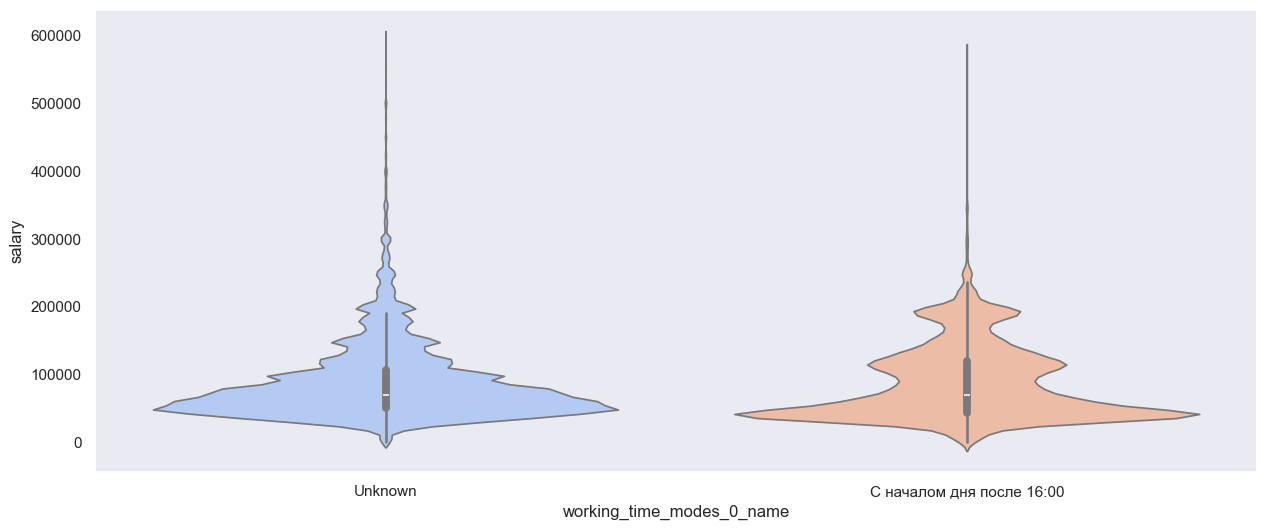

In [164]:
plt.figure(figsize = (15, 6))
sns.violinplot(
    x = df[df['salary'] < percentile_99]['working_time_modes_0_name'],
    y = df[df['salary'] < percentile_99]['salary'],
    split = False,
    palette = "coolwarm"
)
plt.show()

In [167]:
group1 = df[df['working_time_modes_0_name'] == 'Unknown']['salary']
group2 = df[df['working_time_modes_0_name'] == 'С началом дня после 16:00']['salary']
t_stat, t_p_value = ttest_ind(group1, group2)
print(f"T-тест: статистика = {t_stat}, p-значение = {t_p_value}")

alpha = 0.05
if t_p_value < alpha:
    print("Отклоняем нулевую гипотезу: Средние значения зарплат отличаются.")
else:
    print("Не имеем оснований отклонить нулевую гипотезу: Средние значения зарплат равны.")

T-тест: статистика = 1.5494603875181079, p-значение = 0.12127153289776893
Не имеем оснований отклонить нулевую гипотезу: Средние значения зарплат равны.


##### Столбец working_days_0_id и working_days_0_name

In [169]:
df['working_days_0_id'].unique()

array([nan, 'only_saturday_and_sunday'], dtype=object)

In [170]:
df['working_days_0_name'].unique()

array([nan, 'По\xa0субботам и\xa0воскресеньям'], dtype=object)

In [171]:
df['working_days_0_name'] = df['working_days_0_name'].replace('По\xa0субботам и\xa0воскресеньям', 'По субботам и воскресеньям')

In [173]:
del df['working_days_0_id']

In [175]:
nan_working_days = df['working_days_0_name'].isna().sum()
print(f'Колчиество NaN объектов: {nan_working_days}')

Колчиество NaN объектов: 678819


In [176]:
df['working_days_0_name'].fillna('Unknown', inplace=True)

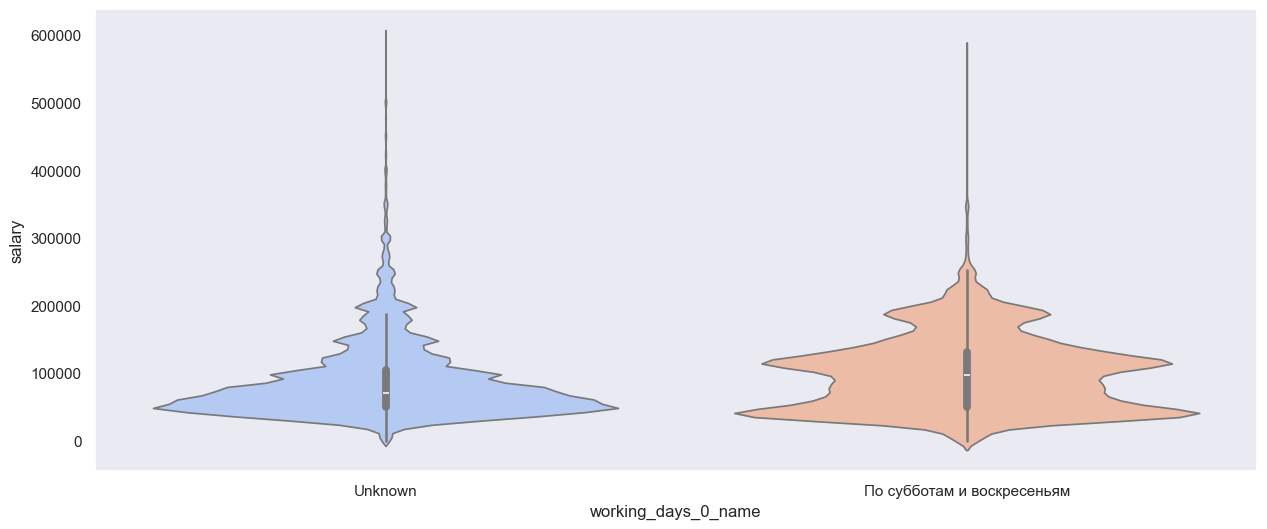

In [177]:
plt.figure(figsize = (15, 6))
sns.violinplot(
    x = df[df['salary'] < percentile_99]['working_days_0_name'],
    y = df[df['salary'] < percentile_99]['salary'],
    split = False,
    palette = "coolwarm"
)
plt.show()

In [178]:
group1 = df[df['working_days_0_name'] == 'Unknown']['salary']
group2 = df[df['working_days_0_name'] == 'По субботам и воскресеньям']['salary']
t_stat, t_p_value = ttest_ind(group1, group2)
print(f"T-тест: статистика = {t_stat}, p-значение = {t_p_value}")

alpha = 0.05
if t_p_value < alpha:
    print("Отклоняем нулевую гипотезу: Средние значения зарплат отличаются.")
else:
    print("Не имеем оснований отклонить нулевую гипотезу: Средние значения зарплат равны.")

T-тест: статистика = -19.523388484878527, p-значение = 7.314172349455211e-85
Отклоняем нулевую гипотезу: Средние значения зарплат отличаются.


##### Столбец branding_type

In [179]:
df['branding_type'].unique()

array([nan, 'MAKEUP', 'CONSTRUCTOR'], dtype=object)

In [182]:
nan_branding_type = df['branding_type'].isna().sum()
print(f'Колчиество NaN объектов: {nan_branding_type}')

Колчиество NaN объектов: 530062


In [184]:
df['branding_type'].fillna('Unknown', inplace=True)

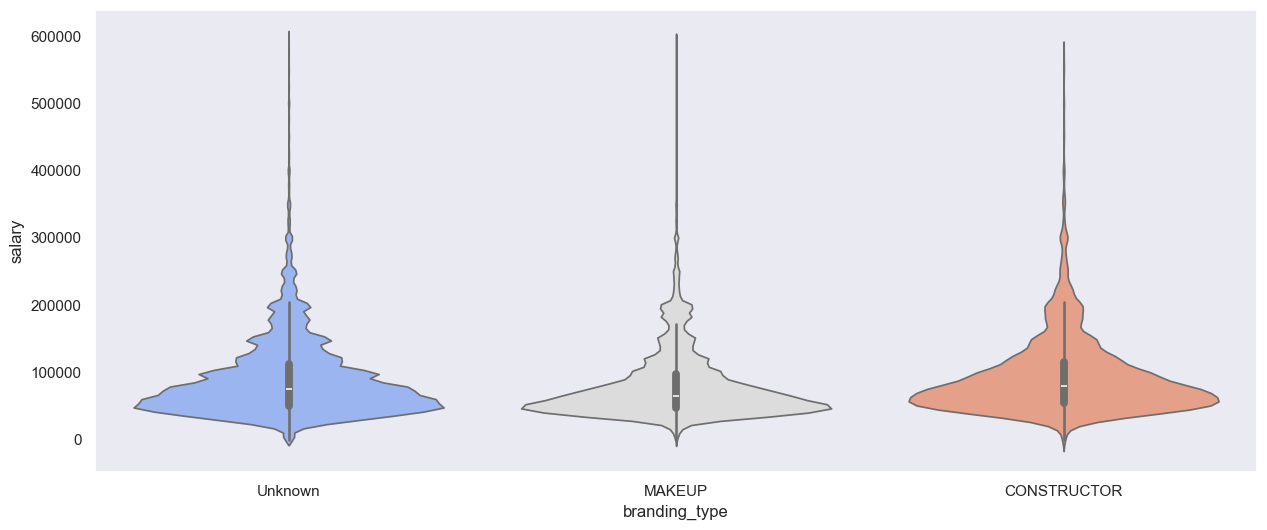

In [185]:
plt.figure(figsize = (15, 6))
sns.violinplot(
    x = df[df['salary'] < percentile_99]['branding_type'],
    y = df[df['salary'] < percentile_99]['salary'],
    split = False,
    palette = "coolwarm"
)
plt.show()

In [190]:
salary_groups = [group['salary'].values for _, group in filtered_df.groupby('branding_type')]
statistic, p_value = kruskal(*salary_groups)

print(f'Статистика Краскела-Уоллиса: {statistic}')
print(f'P-value: {p_value}')

if p_value < 0.05:
    print('Существует статистически значимая зависимость между  и зарплатой')
else:
    print('Нет статистически значимой зависимости между  и зарплатой')

Статистика Краскела-Уоллиса: 1298.950478741943
P-value: 1.91116186579962e-284
Существует статистически значимая зависимость между  и зарплатой


##### Столбец branding_tariff

In [181]:
df['branding_tariff'].unique()

array([nan, 'BASIC'], dtype=object)

In [187]:
nan_branding_tariff = df['branding_tariff'].isna().sum()
print(f'Колчиество NaN объектов: {nan_branding_tariff}')

Колчиество NaN объектов: 695718


In [188]:
df['branding_tariff'].fillna('Unknown', inplace=True)

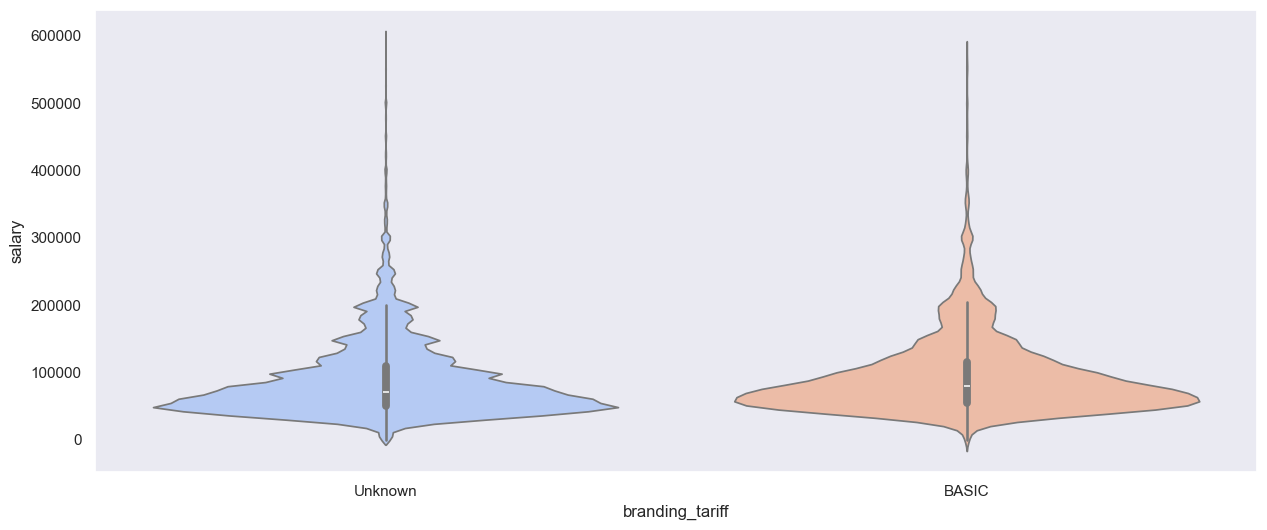

In [189]:
plt.figure(figsize = (15, 6))
sns.violinplot(
    x = df[df['salary'] < percentile_99]['branding_tariff'],
    y = df[df['salary'] < percentile_99]['salary'],
    split = False,
    palette = "coolwarm"
)
plt.show()

In [191]:
group1 = df[df['branding_tariff'] == 'Unknown']['salary']
group2 = df[df['branding_tariff'] == 'BASIC']['salary']
t_stat, t_p_value = ttest_ind(group1, group2)
print(f"T-тест: статистика = {t_stat}, p-значение = {t_p_value}")

alpha = 0.05
if t_p_value < alpha:
    print("Отклоняем нулевую гипотезу: Средние значения зарплат отличаются.")
else:
    print("Не имеем оснований отклонить нулевую гипотезу: Средние значения зарплат равны.")

T-тест: статистика = -7.792323711028853, p-значение = 6.587623757993402e-15
Отклоняем нулевую гипотезу: Средние значения зарплат отличаются.


##### Столбец department_id и department_name

In [192]:
df['department_id'].unique()

array([nan, '1942330-1942330-magaz', '1049556-1049556-work',
       'fixprice-196621-market', 'cherkizovo-1346-ofis', 'LCR-3344-mned',
       '1030733-1030733-ver', '10413982-10413982-emin',
       'pochta-4352-depart', 'pochta-4352-office', '99966-99966-ptz',
       '816144-816144-darkst', '62136-62136-invest',
       '62136-62136-comfort', '866666-866666-market', 'rns-5923-RKMo',
       '80-80-expert', '10413982-10413982-cfit', '80-80-bank',
       '4606-4606-shops', '1030733-1030733-magazin', 'tsum-52389-tsum',
       'okey-1276-market', '522-522-omk', '54979-54979-shop',
       'azbvk-2120-super', 'ozonru-2180-express', 'azbvk-2120-mini',
       '6591-6591-biz', 'azbvk-2120-gastr', 'vtb-4181-rbiz',
       'mari-231418-roznset', 'LCR-3344-gruz', '23186-23186-meat',
       '53797-53797-efkoanlt', '62136-62136-saleprod',
       '53797-53797-efkoadmn', '3529-3529-prof', 'CG-37318-tvoidom',
       '12550-12550-pick', '80-80-call', '4880-4880-office',
       '4880-4880-dm', '3414-3414-mv

In [193]:
df['department_name'].unique()

array([nan, 'Пятёрочка. Команда магазинов',
       'Почта Банк. Работа с клиентами', 'Fix Price. Магазины',
       '«Группа Черкизово», Центральный офис',
       'ЛСР. Недвижимость - Москва', 'Верный',
       'Restaurants by Emin Agalarov',
       '«Почта России», Отделение почтовой связи', '«Почта России», Офис',
       '«Spar»,Торговый зал', 'ВкусВилл. Даркстор',
       'Sminex Финансы, Юриспруденция и Инвестиции',
       'Sminex Служба комфорта', 'BetBoom.Маркетинг',
       'Ренессанс Банк, Москва', 'Альфа-Банк. Центральный офис',
       'Crocus Fitness', 'Альфа-Банк', 'Familia. Магазины',
       'Верный.Магазин', 'ЦУМ', ' О’КЕЙ Магазины', 'ОМК',
       'АШАН Ритейл Россия, Работа в магазине',
       'Супермаркеты «Азбука вкуса» ', 'Ozon fresh',
       'Минимаркеты «Азбука daily» ',
       'ПАО «Промсвязьбанк», Бизнес и инфраструктура',
       ' «Азбука вкуса». Ресторанная служба и приготовление на местах',
       'ПАО ВТБ, Розничный бизнес',
       'Компания «Мария». Вакансии в сту

In [194]:
del df['department_id']

In [195]:
nan_department_name = df['department_name'].isna().sum()
print(f'Колчиество NaN объектов: {nan_department_name}')

Колчиество NaN объектов: 634876


In [196]:
df['department_name'].fillna('Unknown', inplace=True)

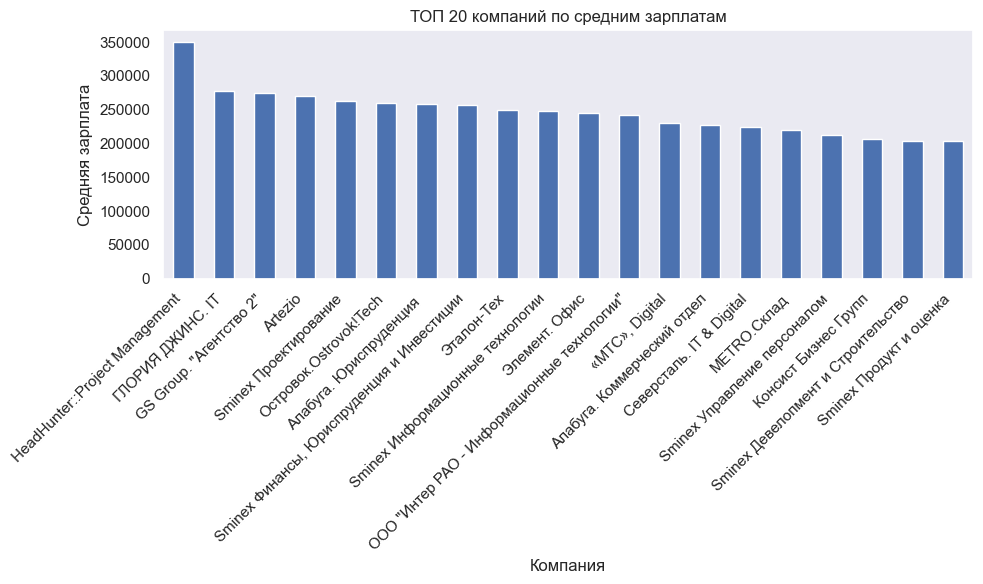

In [198]:
average_salary = df.groupby('department_name')['salary'].mean()
top_20_companies = average_salary.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
top_20_companies.plot(kind='bar')
plt.title('ТОП 20 компаний по средним зарплатам')
plt.xlabel('Компания')
plt.ylabel('Средняя зарплата')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

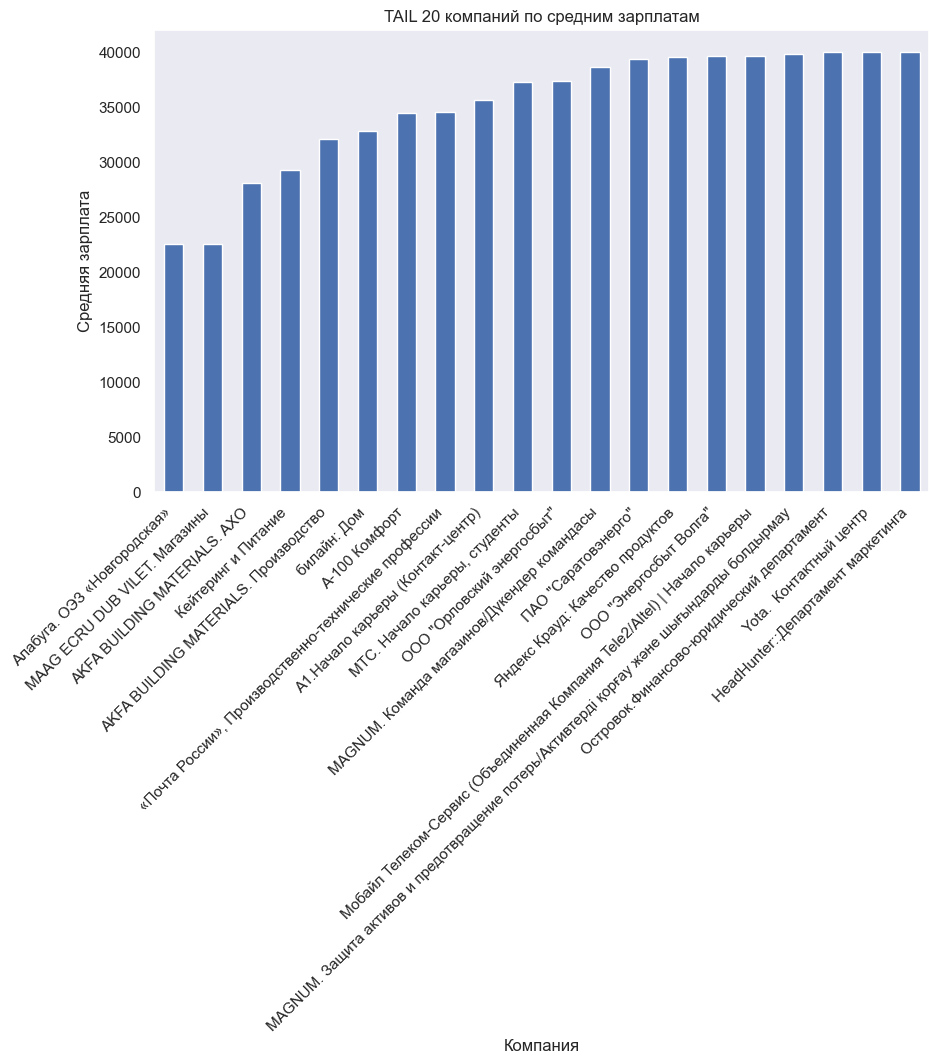

In [199]:
tail_20_companies = average_salary.sort_values(ascending=True).head(20)

plt.figure(figsize=(10, 6))
tail_20_companies.plot(kind='bar')
plt.title('TAIL 20 компаний по средним зарплатам')
plt.xlabel('Компания')
plt.ylabel('Средняя зарплата')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

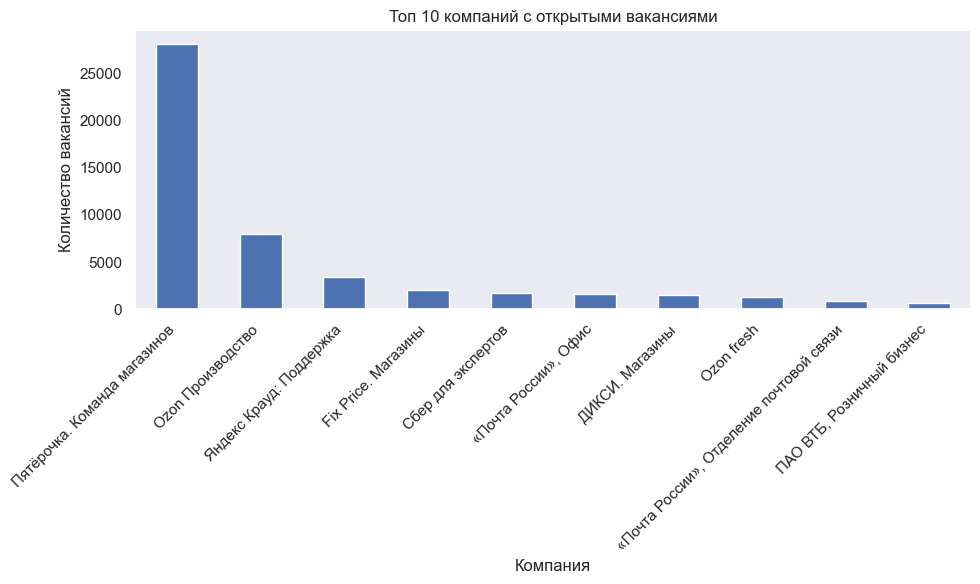

In [203]:
vacancies_count = df.loc[df['department_name'] != 'Unknown', 'department_name'].value_counts()
top_10_vacancies = vacancies_count.head(10)

plt.figure(figsize=(10, 6))
top_10_vacancies.plot(kind='bar')
plt.title('Топ 10 компаний с открытыми вакансиями')
plt.xlabel('Компания')
plt.ylabel('Количество вакансий')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [205]:
salary_groups = [group['salary'].values for _, group in df.loc[df['department_name'] != 'Unknown'].groupby('department_name')]
statistic, p_value = kruskal(*salary_groups)

print(f'Статистика Краскела-Уоллиса: {statistic}')
print(f'P-value: {p_value}')

if p_value < 0.05:
    print('Существует статистически значимая зависимость между компанией и зарплатой в ней')
else:
    print('Нет статистически значимой зависимости между компанией и зарплатой в ней')

Статистика Краскела-Уоллиса: 39034.597886333984
P-value: 0.0
Существует статистически значимая зависимость между компанией и зарплатой в ней


##### Столбец insider_interview_id и insider_interview_url

In [206]:
df['insider_interview_id'].unique()

array([   nan, 33161., 31486., 32631., 31426., 33200., 27906., 27120.,
       33004., 32978., 32903., 32938., 33155., 32346., 31084., 32937.,
       31891., 33096., 27832., 33098., 33047., 32857., 21442., 32890.,
       32984., 32278., 32905., 33003., 30809., 24989., 31262., 32032.,
       21446., 18140., 32866., 21444., 30757., 32891., 33045., 32665.,
       33046.])

In [207]:
df['insider_interview_url'].unique()

array([nan, 'https://hh.ru/interview/33161?employerId=10610846',
       'https://hh.ru/interview/31486?employerId=80',
       'https://hh.ru/interview/32631?employerId=80',
       'https://hh.ru/interview/31426?employerId=522',
       'https://hh.ru/interview/33200?employerId=54979',
       'https://hh.ru/interview/27906?employerId=2120',
       'https://hh.ru/interview/27120?employerId=27708',
       'https://hh.ru/interview/33004?employerId=4880',
       'https://hh.ru/interview/32978?employerId=78638',
       'https://hh.ru/interview/32903?employerId=895945',
       'https://hh.ru/interview/32938?employerId=2343',
       'https://hh.ru/interview/33155?employerId=697715',
       'https://hh.ru/interview/32346?employerId=77364',
       'https://hh.ru/interview/31084?employerId=4233',
       'https://hh.ru/interview/32937?employerId=1833',
       'https://hh.ru/interview/31891?employerId=1942330',
       'https://hh.ru/interview/33096?employerId=11036',
       'https://hh.ru/interview/

In [208]:
del df['insider_interview_id']
del df['insider_interview_url']